In [1]:
import polars as pl
import numpy as np
from typing import List

def lag_exprs(col: str, lag: int) -> pl.Expr:
    return pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")

def diff_expr(col: str, lag: int = 1) -> pl.Expr:
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_diff_{lag}")

def second_order_diff_expr(col: str, lag: int = 1) -> pl.Expr:
    # 二阶差分 = 一阶差分的差分
    first_diff = pl.col(col) - pl.col(col).shift(lag)
    second_diff = first_diff - first_diff.shift(lag)
    return second_diff.alias(f"{col}_second_order_diff_{lag}")

def momentum_ratio_expr(col: str, window: int = 200) -> pl.Expr:
    # 动量比率 = x_t / x_{t-lag}
    EPSILON = 1e-5
    return ((pl.col(col).abs() + EPSILON).log1p() - (pl.col(col).abs() + EPSILON).shift(window).log1p()).alias(f"{col}_momentum_ratio_{window}")

def rolling_volatility_expr(col: str, window: int) -> pl.Expr:
    return pl.col(col).rolling_std(window).alias(f"{col}_volatility_{window}")

def cross_minus_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) - (pl.col(b) + 1e-8)).alias(f"{a}_minus_{b}")

def cols_to_transforms(
        df: pl.DataFrame,
        exclude_cols: List[str] = None
) -> List[str]:
    if exclude_cols is None:
        exclude_cols = ['px', 'timestamp', 'timestamp_dt', 'symbol']

    if isinstance(df, pl.LazyFrame):
        cols = df.collect_schema().names()
    else:
        cols = df.columns

    cols = [
        col for col in cols
        if col not in exclude_cols and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_scaled')
        ) and col.startswith("z_")
    ]

    return cols

def batch_apply_single_exprs(
        window: int,
        lags: [int],
        cols: List[str] = None
) -> List[str]:
    single_exprs = []
    # single features transformation
    for col in cols:
        single_exprs.extend([
            momentum_ratio_expr(col, window),
            rolling_volatility_expr(col, window),
        ])
        for lag in lags:
            single_exprs.extend([
            lag_exprs(col, lag),
            diff_expr(col, lag),
            second_order_diff_expr(col, lag),
        ])
            
    return single_exprs

def batch_apply_multi_exprs(
        cols: List[str] = None
) -> List[str]:
    multi_exprs = []

    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = cols[i], cols[j]
            multi_exprs.extend([
                cross_minus_expr(a, b),
            ])

    return multi_exprs

def batch_apply_transforms(
        df_to_transforms: pl.DataFrame,
        window: int,
        lags: [int],
        exclude_cols: List[str] = None
) -> pl.DataFrame:
    base_cols = cols_to_transforms(df_to_transforms, exclude_cols)
   
    single_exprs = batch_apply_single_exprs(window, lags, base_cols)
    multi_exprs = batch_apply_multi_exprs(base_cols)

    exprs = single_exprs + multi_exprs
    return df_to_transforms.with_columns(exprs)



In [2]:
import polars as pl
import numpy as np
from typing import List
from tqdm import tqdm

def split_df_by_week(
    origin_input_df: pl.DataFrame,
    ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    origin_input_df = origin_input_df.with_columns([
        pl.col(ts_col).cast(pl.Datetime("ms")).alias(f"{ts_col}_dt")  # 注意这里加了 "ms"
    ])

    origin_input_df = origin_input_df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1w").alias("week_start")
    ])

    unique_weeks = origin_input_df.select("week_start").unique().sort("week_start")

    weekly_dfs = [
        origin_input_df.filter(pl.col("week_start") == wk).drop("week_start")
        for wk in unique_weeks["week_start"]
    ]

    return weekly_dfs

def clean_df_drop_nulls(
        df_to_clean: pl.DataFrame,
        null_threshold: int = 10000,
        verbose: bool = True
) -> pl.DataFrame:
    pd_df = df_to_clean.to_pandas()

    null_counts = pd_df.isnull().sum()
    cols_to_drop = null_counts[null_counts > null_threshold].index

    pd_df_cleaned = pd_df.drop(columns=cols_to_drop)
    pd_df_clean = pd_df_cleaned.dropna()
    pl_df_clean = pl.from_pandas(pd_df_clean)

    if verbose:
        max_null_col = null_counts.idxmax()
        max_null_count = null_counts.max()
        print("各列空值数量：")
        print(null_counts[null_counts > 0])
        print(f"删除空值超过 {null_threshold} 的列：{list(cols_to_drop)}")
        print(f"删除列后，DataFrame形状：{pd_df_cleaned.shape}")
        print(f"空值最多的列是：{max_null_col}，共有 {max_null_count} 个空值")
        print(f"删除空值行后，DataFrame形状：{pd_df_clean.shape}")

    return pl_df_clean

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> int:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.mean(steps_list))

def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

def rolling_minmax_scaled_expr(
        col: str,
        min_col: str,
        max_col: str,
        scaled_col: str
) -> pl.Expr:
    return (
        ((pl.col(col) - pl.col(min_col)) / (pl.col(max_col) - pl.col(min_col) + 1e-9))
        .clip(0.0, 1.0)
        .fill_null(0.5)
        .alias(scaled_col)
    )

def rolling_minmax_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')  # scaled 是最终产物，保留
           and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_rolling_max') or
                col.endswith('_rolling_min')
        )
    ]

    rolling_cols = []
    for column in columns_to_normalize:
        rolling_cols.extend([
            pl.col(column).rolling_max(window, min_samples=1).alias(f"{column}_rolling_max"),
            pl.col(column).rolling_min(window, min_samples=1).alias(f"{column}_rolling_min"),
        ])

    intermediate_cols = [
                            f"{column}_rolling_max" for column in columns_to_normalize
                        ] + [
                            f"{column}_rolling_min" for column in columns_to_normalize
                        ]

    return (
        rollin_df
        .with_columns(rolling_cols)
        .with_columns([
            rolling_minmax_scaled_expr(
                col=column,
                min_col=f"{column}_rolling_min",
                max_col=f"{column}_rolling_max",
                scaled_col=f"{column}_scaled"
            ) for column in columns_to_normalize
        ])
        .drop(intermediate_cols)
    )

def rolling_mean_tanh_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        # .rolling_mean(window, min_samples=1)
        .tanh()
        .rolling_mean(window, min_samples=1)
        .alias(scaled_col)
    )

def rolling_mean_tanh_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_tanh_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_normalize
    ])

def rolling_z_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        z_score_expr(
            col=column,
            scaled_col=f"{column}_zd",
            window=window
        ) for column in columns_to_normalize
    ]) 

def z_score_expr(
    col: str,
    scaled_col: str,
    window: int
) -> pl.Expr:
    EPSILON = 1e-6
    mean_expr = pl.col(col).rolling_mean(window)
    std_expr = pl.col(col).rolling_std(window).fill_nan(0)

    return (
        ((pl.col(col) - mean_expr) / (std_expr + EPSILON))
        .fill_nan(0)
        .fill_null(0)
        .clip(-1.0, 1.0)
        .alias(scaled_col)
    )


def rolling_mean_smooth(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_smooth = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_smooth
    ])

def rolling_mean_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        .rolling_mean(window)
        .fill_null(strategy="zero")  # 或 strategy="forward" 也行
        .alias(scaled_col)
    )


def rolling_ic_ir_icto_index(
        df: pl.DataFrame,
        target_col: str,
        exclude_prefixes: list[str],
        window_size: int,
        step: int = 1,
) -> pl.DataFrame:
    feature_cols = [
        col for col in df.columns
        if col.endswith("_scaled") 
            and (col.startswith("z_") or col.startswith("raw_")) 
            and all(not col.startswith(prefix) for prefix in exclude_prefixes)
            and not col.startswith("future_return_")
            and col != "px"
    ]

    # feature_cols = [
    #     col for col in df.columns
    #     if col.startswith("z_") 
    #         and all(not col.startswith(prefix) for prefix in exclude_prefixes)
    #         and not col.startswith("future_return_")
    #         and col != "px"
    # ]

    n = df.height
    results = []
    prev_ranks = {}

    for start in tqdm(range(0, n - window_size + 1, step), desc="Rolling IC & ICTO"):
        end = start + window_size
        df_win = df.slice(start, window_size)

        # rank 转换
        df_ranked = df_win.with_columns([
            (pl.col(c).rank(method="average") / window_size).alias(c + "_rank") for c in feature_cols + [target_col]
        ])
        target_rank_col = target_col + "_rank"

        for feat in feature_cols:
            feat_rank_col = feat + "_rank"
            ic = df_ranked.select(
                pl.corr(pl.col(feat_rank_col), pl.col(target_rank_col)).alias("ic")
            ).to_series()[0]

            turnover = None
            if feat in prev_ranks:
                cur_ranks = df_ranked[feat_rank_col].to_numpy()
                prev = prev_ranks[feat]
                if len(prev) == len(cur_ranks):
                    turnover = np.mean(np.abs(cur_ranks - prev))

            # 更新 prev_ranks
            prev_ranks[feat] = df_ranked[feat_rank_col].to_numpy()

            results.append({
                "window_start": int(start),
                "window_end": int(end - 1),
                "factor": str(feat),
                "ic": float(ic) if not np.isnan(ic) else None,
                "turnover": float(turnover) if turnover is not None else None
            })

    df_result = pl.DataFrame(
        results,
        schema={
            "window_start": pl.Int64,
            "window_end": pl.Int64,
            "factor": pl.Utf8,
            "ic": pl.Float64,
            "turnover": pl.Float64,
        }
    )      
    return (
        df_result
        .group_by("factor")
        .agg([
            pl.mean("ic").alias("mean_ic"),
            pl.std("ic").alias("std_ic"),
            pl.mean("turnover").alias("mean_turnover")
        ])
        .with_columns([
            (pl.col("mean_ic") / pl.col("std_ic")).alias("ir"),
            (pl.col("mean_ic") / (pl.col("mean_turnover") + 1e-8)).abs().alias("icto")
        ])
        .sort("icto", descending=True)
    )

In [3]:
symbol = "ethusdt"
symbol.upper()
threshold = "0.002"
feat_cal_window = "500"
file = symbol + "_factors_threshold" + threshold + "_rolling" + feat_cal_window + ".csv"
path = "C:/quant/data/binance_resampled_data/" + file
origin_df = pl.read_csv(path)
# origin_df = pl.read_parquet("C:/quant/data/data_test/ethusdt_thresh0.002_hybrid.parquet")

# # 先把那两列单独 shift
# shifted_cols = origin_df.select([
#     pl.col("raw_factor_buy_sell_vlm_diff").shift(-5).alias("raw_factor_buy_sell_vlm_diff_shifted"),
#     pl.col("z_factor_buy_sell_vlm_diff").shift(-5).alias("z_factor_buy_sell_vlm_diff_shifted"),
# ])

# 删除原来的两列
# origin_df = origin_df.drop([ "z_factor_buy_sell_vlm_diff"])

# # 合并回去（按顺序拼接）
# origin_df = origin_df.with_columns([
#     shifted_cols["raw_factor_buy_sell_vlm_diff_shifted"],
#     shifted_cols["z_factor_buy_sell_vlm_diff_shifted"]
# ])
feat_trans_lags = [5, 10, 20, 50, 100, 200]
feat_trans_window = 250
feat_norm_window = 500
print(origin_df)
step = 125

origin_df = origin_df.with_columns([
    future_return_expr("px", step),
])
print(origin_df)

origin_df = batch_apply_transforms(origin_df, feat_trans_window, feat_trans_lags)
origin_df = rolling_z_normalize(origin_df, feat_norm_window)
origin_df = rolling_mean_tanh_normalize(origin_df, feat_norm_window)
print(origin_df)
stds = origin_df.select([
    pl.col(col).std().alias(col) for col in origin_df.columns if origin_df[col].dtype in (pl.Float64, pl.Int64)
])
zero_std_cols = [col for col in stds.columns if stds[0, col] == 0.0]
print(zero_std_cols)
origin_df = origin_df.drop(zero_std_cols)
print(origin_df[f"future_return_{step}"])



shape: (30_430, 112)
┌───────────────┬─────────┬────────────┬─────────────┬───┬──────────────────────┬─────────────────────┬─────────────────────┬─────────────────────┐
│ timestamp     ┆ px      ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ z_factor_momentum_tr ┆ z_factor_order_sent ┆ z_factor_oi_momentu ┆ z_factor_oi_momentu │
│ ---           ┆ ---     ┆ ---        ┆ ---         ┆   ┆ end_confir…          ┆ iment_diver…        ┆ m_punch             ┆ m_long_term…        │
│ i64           ┆ f64     ┆ f64        ┆ f64         ┆   ┆ ---                  ┆ ---                 ┆ ---                 ┆ ---                 │
│               ┆         ┆            ┆             ┆   ┆ f64                  ┆ f64                 ┆ f64                 ┆ f64                 │
╞═══════════════╪═════════╪════════════╪═════════════╪═══╪══════════════════════╪═════════════════════╪═════════════════════╪═════════════════════╡
│ 1744032949188 ┆ 1500.94 ┆ 1976.771   ┆ 3478.64     ┆ … ┆ 3.0                  ┆ 3.0      

In [4]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.mixture import GaussianMixture
from sklearn.utils.class_weight import compute_sample_weight

import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.preprocessing import LabelEncoder
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# pdf = origin_df.to_pandas()
# # pdf["timestamp"] = pd.to_datetime(pdf["timestamp"], unit="ms")

# # 计算百分比变化（return）
# pdf["px_pct"] = pdf["px"].pct_change()

# # 绘图
# plt.figure(figsize=(8, 4))
# plt.hist(pdf["px_pct"].dropna() * 100, bins=50, color="orange", edgecolor="k")
# plt.title("Distribution of Percentage Price Change (px.pct_change())")
# plt.xlabel("Price Change (%)")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [6]:
def plot_last_n_rows_with_px(y_test, y_test_binary, y_pred_prob, px, std_array=None, n=700, m=-1, alpha=1):
    # 截取最后 n 行
    y_test_slice = y_test[n:m]
    y_test_binary_slice = y_test_binary[n:m]
    y_pred_prob_slice = y_pred_prob[n:m]
    px_slice = px[n:m]
    
    if std_array is not None:
        std_slice = std_array[n:m]
    else:
        std_slice = None

    time_index = np.arange(len(y_test_slice))

    fig, ax1 = plt.subplots(figsize=(16, 7))

    # # 原始收益
    # ax1.plot(time_index, y_test_slice, label="Original Future Returns", color='gray', alpha=0.8)
    # ax1.set_ylabel("Original Future Returns", color='gray')
    # ax1.tick_params(axis='y', labelcolor='gray')

    # GMM 标签
    ax2 = ax1.twinx()
    ax2.scatter(time_index, y_test_binary_slice, label="GMM Labels", color='tab:blue', marker='o', s=5, alpha=0.7)
    ax2.set_ylabel("GMM Labels (0 or 1)", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim(-0.1, 1.1)

    # 模型预测概率
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.plot(time_index, y_pred_prob_slice, label="MODEL Predicted Probability", color='tab:green', alpha=0.4)
    ax3.set_ylabel("MODEL Predicted Probability", color='tab:green')
    ax3.tick_params(axis='y', labelcolor='tab:green')
    ax3.set_ylim(-0.05, 1.05)

    # 价格线 (第4轴)
    ax4 = ax1.twinx()
    ax4.spines.right.set_position(("outward", 120))  # 再右移一层
    ax4.plot(time_index, px_slice, label="Price (px)", color='tab:blue', linestyle='--', alpha=0.6)

    # 加上下轨线
    if std_slice is not None:
        ax4.plot(time_index, px_slice + alpha * std_slice, label="Price + std", color='tab:gray', linestyle=':', alpha=0.4)
        ax4.plot(time_index, px_slice - alpha * std_slice, label="Price - std", color='tab:gray', linestyle=':', alpha=0.4)

    ax4.set_ylabel("Price (px)", color='tab:red')
    ax4.tick_params(axis='y', labelcolor='tab:red')

    # x轴
    ax1.set_xlabel("Time Index")
    plt.title(f"Compare Returns, Labels, Prediction & Price (Last {n} Rows)")

    # 图例
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    lines_4, labels_4 = ax4.get_legend_handles_labels()

    ax1.legend(
        lines_1 + lines_2 + lines_3 + lines_4,
        labels_1 + labels_2 + labels_3 + labels_4,
        loc='upper left'
    )

    plt.tight_layout()
    plt.show()


In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

def evaluate_with_confidence(
    y_true,
    y_pred_proba,                      
    model_name="Model",                    
    lower_thresh=0.2,                  
    upper_thresh=0.8,       
    print_report=True,
):

    # ===== 基础评估 (全样本) =====
    base_pred = (y_pred_proba >= 0.5).astype(int)
    base_acc = accuracy_score(y_true, base_pred)
    
    # ===== 置信预测评估 =====
    # 生成交易信号 (-1: 不交易, 0: 做空, 1: 做多)
    signals = np.full_like(y_pred_proba, fill_value=-1, dtype=int)
    signals[y_pred_proba <= lower_thresh] = 0
    signals[y_pred_proba >= upper_thresh] = 1
    
    # 计算置信预测指标
    mask = signals != -1
    conf_acc = accuracy_score(y_true[mask], signals[mask]) if any(mask) else np.nan
    trading_rate = mask.mean()
    
    # ===== 结果组织 =====
    eval_dict = {
        'model': model_name,
        'thresholds': f"{lower_thresh}-{upper_thresh}",
        'base_accuracy': base_acc,
        'confident_accuracy': conf_acc,
        'trading_rate': trading_rate,
        'conf_matrix': confusion_matrix(y_true[mask], signals[mask]) if any(mask) else None,
        'class_report': classification_report(y_true[mask], signals[mask], output_dict=True) if any(mask) else None,
        'y_test_binary': y_true, 
        'y_pred_proba': y_pred_proba, 
        'signal': signals,
    }
    
    # ===== 打印输出 =====
    if print_report:
        print(f"\n=== {model_name} 评估结果 ===")
        print(f"📊 全样本准确率: {base_acc:.4f}")
        print(f"✅ 自信预测准确率: {conf_acc:.4f} (阈值 {lower_thresh}-{upper_thresh})")
        print(f"📈 出手率: {trading_rate:.2%}")
        
        if any(mask):
            print("\n🧮 自信预测混淆矩阵:")
            print(eval_dict['conf_matrix'])
            
            print("\n📝 分类报告:")
            print(classification_report(y_true[mask], signals[mask]))
        else:
            print("⚠️ 无自信预测样本!")
    
    return eval_dict


In [8]:
from sklearn.mixture import GaussianMixture
import numpy as np

def gmm_label_binarize(y_train, y_val=None, y_test=None, verbose=True, random_state=42):
    """
    用 GMM 对收益率进行聚类，然后按均值高低映射为上涨(1)/下跌(0)标签。
    
    参数:
        y_train, y_val, y_test: Series 或 ndarray
        verbose: 是否打印详细映射信息
    返回:
        y_train_binary, y_val_binary, y_test_binary, gmm_model
    """
    y_train_np = np.asarray(y_train).reshape(-1, 1)
    y_val_np = np.asarray(y_val).reshape(-1, 1) if y_val is not None else None
    y_test_np = np.asarray(y_test).reshape(-1, 1) if y_test is not None else None

    # GMM 拟合
    gmm = GaussianMixture(n_components=2, random_state=random_state)
    gmm.fit(y_train_np)

    means = gmm.means_.flatten()
    upward_label = np.argmax(means)
    downward_label = np.argmin(means)

    if verbose:
        print(f"GMM 分量均值: {means}")
        print(f"上涨标签: {upward_label}, 下跌标签: {downward_label}")

    # 标签转换函数
    def transform_labels(y_np):
        raw = gmm.predict(y_np)
        binary = (raw == upward_label).astype(int)
        return binary, raw

    y_train_binary, train_raw = transform_labels(y_train_np)
    y_val_binary, val_raw = transform_labels(y_val_np) if y_val_np is not None else (None, None)
    y_test_binary, test_raw = transform_labels(y_test_np) if y_test_np is not None else (None, None)

    if verbose:
        print("\n--- GMM 原始标签 => 最终二元标签映射 ---")
        for label in [0, 1]:
            print(f"GMM 内部标签 {label} (均值: {means[label]:.6f}) => 二元标签: {1 if label == upward_label else 0}")

        print("\n--- 示例标签 ---")
        print("训练集原始收益:", y_train_np[:10].flatten())
        print("训练集GMM标签:", train_raw[:10])
        print("训练集二元标签:", y_train_binary[:10])

        if y_test_binary is not None:
            print("\n测试集原始收益:", y_test_np[:10].flatten())
            print("测试集GMM标签:", test_raw[:10])
            print("测试集二元标签:", y_test_binary[:10])

    return y_train_binary, y_val_binary, y_test_binary, gmm


In [9]:
# import polars as pl
# import numpy as np
# from tqdm import tqdm

# rolling_window = 20
# alpha = 5

# a_df = (
#     origin_df
#     .with_columns([
#         pl.col("px").rolling_std(window_size=rolling_window).alias("rolling_std"),
#     ])
# )

# def label_by_future_std(px: np.ndarray, std: np.ndarray) -> np.ndarray:
#     n = len(px)
#     labels = np.full(n, -1)  # 初始化为 -1（未触发）

#     for i in tqdm(range(n), desc="Labeling by future std"):
#         anchor_price = px[i]
#         for j in range(i + 1, n):
#             upper_bound = anchor_price + alpha * std[j]
#             lower_bound = anchor_price - alpha * std[j]
#             if px[j] >= upper_bound:
#                 labels[i] = 1
#                 break
#             elif px[j] <= lower_bound:
#                 labels[i] = 0
#                 break

#             else:
#                 labels[i] = -1

#     return labels

# px_np = a_df["px"].to_numpy()
# std_np = a_df["rolling_std"].to_numpy()

# labels_np = label_by_future_std(px_np, std_np)

# a_df = a_df.with_columns(pl.Series("future_std_label", labels_np))
# print(a_df)
# a_df_filtered = a_df.filter(pl.col("future_std_label") >= 0)
# a_df_filtered = clean_df_drop_nulls(a_df_filtered)
# print(a_df_filtered)

# weekly_dataframes = split_df_by_week(a_df_filtered)
# print("num weekly dfs: ", len(weekly_dataframes))

In [10]:
import polars as pl
import numpy as np
from tqdm import tqdm

# //////////////////////////////
rolling_window = 500
alpha = 4

a_df = origin_df.with_columns([
    pl.col("px").rolling_std(window_size=rolling_window).alias("rolling_std"),
])

def label_by_future_std_with_duration_and_bars(px: np.ndarray, std: np.ndarray, ts: np.ndarray):
    n = len(px)
    labels = np.full(n, -1, dtype=np.int8)
    durations = np.full(n, -1, dtype=np.int64)  # 微秒差
    bar_counts = np.full(n, -1, dtype=np.int32) # bar 数

    for i in tqdm(range(n), desc="Labeling by future std"):
        anchor_price = px[i]
        anchor_ts = ts[i]

        for j in range(i + 1, n):
            upper_bound = anchor_price + alpha * std[j]
            lower_bound = anchor_price - alpha * std[j]

            if px[j] >= upper_bound:
                labels[i] = 1
                durations[i] = ts[j] - anchor_ts
                bar_counts[i] = j - i
                break
            elif px[j] <= lower_bound:
                labels[i] = 0
                durations[i] = ts[j] - anchor_ts
                bar_counts[i] = j - i
                break

    return labels, durations, bar_counts


px_np = a_df["px"].to_numpy()
std_np = a_df["rolling_std"].to_numpy()
ts_np = a_df["timestamp"].to_numpy()

labels_np, durations_np, bar_counts_np = label_by_future_std_with_duration_and_bars(px_np, std_np, ts_np)

a_df = a_df.with_columns([
    pl.Series("future_std_label", labels_np),
    pl.Series("label_duration_us", durations_np),
    pl.Series("label_bar_count", bar_counts_np),
])

a_df_filtered = a_df.filter(pl.col("future_std_label") >= 0)
a_df_filtered = clean_df_drop_nulls(a_df_filtered)
print(a_df_filtered)

weekly_dataframes = split_df_by_week(a_df_filtered)
print("num weekly dfs:", len(weekly_dataframes))

Labeling by future std: 100%|█████████████████████████████████████████████████████████████████████████████| 30430/30430 [00:10<00:00, 2845.61it/s]


各列空值数量：
z_factor_oi_change_momentum_ratio_250                                250
z_factor_oi_change_volatility_250                                    249
z_factor_oi_change_lag_5                                               5
z_factor_oi_change_diff_5                                              5
z_factor_oi_change_second_order_diff_5                                10
                                                                    ... 
z_factor_oi_momentum_long_term_punch_second_order_diff_100_scaled    200
z_factor_oi_momentum_long_term_punch_lag_200_scaled                  200
z_factor_oi_momentum_long_term_punch_diff_200_scaled                 200
z_factor_oi_momentum_long_term_punch_second_order_diff_200_scaled    400
rolling_std                                                          499
Length: 1841, dtype: int64
删除空值超过 10000 的列：[]
删除列后，DataFrame形状：(29857, 8257)
空值最多的列是：rolling_std，共有 499 个空值
删除空值行后，DataFrame形状：(29358, 8257)
shape: (29_358, 8_257)
┌───────────────┬────────

In [11]:
mean_duration = a_df_filtered.select(pl.col("label_duration_us").mean()).item()
mean_bar_count = a_df_filtered.select(pl.col("label_bar_count").mean()).item()
mean_ret = a_df_filtered.select(pl.col(f"future_return_{step}").mean()).item()
mean_std = a_df_filtered.select(pl.col("rolling_std").mean()).item()

print(a_df_filtered[f"future_return_{step}"])
print(mean_ret)
print(f"Mean duration: {mean_duration/1_000}")
print(f"Mean bar count: {mean_bar_count}")
print(mean_std)
print(mean_std * alpha)
print((mean_std * alpha) / a_df_filtered.select("px").tail(1).item())
print((mean_std) / a_df_filtered.select("px").tail(1).item())


shape: (29_358,)
Series: 'future_return_125' [f64]
[
	-0.001362
	0.002724
	-0.001324
	-0.00134
	-0.001337
	…
	-0.02189
	-0.021892
	-0.017944
	-0.017937
	-0.017533
]
0.0030215369846380113
Mean duration: 279251.943960045
Mean bar count: 950.3638871857756
40.660878325294604
162.64351330117842
0.053966617769438514
0.013491654442359629


In [12]:
# print(
#     a_df_filtered
#     .select(pl.col("future_std_label").value_counts(sort=True))
# )


In [13]:
import os
import json
import pickle
from pathlib import Path
from datetime import datetime

def save_tabnet_checkpoint(
    model,
    symbol,
    base_save_dir: str,
    model_params: dict,
    feature_names: list[str],
    training_meta: dict,
    unique_id: str = None, 
):
    if unique_id is None:
        timestamp = str(datetime.now().strftime("%Y-%m-%d_%H-%M"))
        save_dir = os.path.join(base_save_dir, f"{symbol}_{timestamp}")
    else:
        save_dir = os.path.join(base_save_dir, f"{symbol}_{unique_id}")

    os.makedirs(save_dir, exist_ok=True)

    model_path = os.path.join(save_dir, "tabnet_model")
    model.save_model(model_path)

    config_path = os.path.join(save_dir, "model_metadata.json")
    with open(config_path, "w") as f:
        json.dump({
            "model_params": model_params,
            "meta_info": training_meta,
        }, f, indent=4)

    aux_path = os.path.join(save_dir, "auxiliary.pkl")
    with open(aux_path, "wb") as f:
        pickle.dump({
            "feature_names": feature_names,
        }, f)

    print(f"model and meta info saved to {save_dir}")


Fold 0: Train 0~2, Val 3, Test 4
Train: 2025-04-07 15:31:03.701000 to 2025-04-27 23:44:00.083000
Val: 2025-04-28 00:07:09.088000 to 2025-05-04 23:52:02.529000
Test: 2025-05-05 00:13:13.815000 to 2025-05-11 23:59:42.444000
GMM 分量均值: [ 0.01308131 -0.01438346]
上涨标签: 0, 下跌标签: 1

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: 0.013081) => 二元标签: 1
GMM 内部标签 1 (均值: -0.014383) => 二元标签: 0

--- 示例标签 ---
训练集原始收益: [-0.00136217  0.00272354 -0.0013235  -0.00134011 -0.00133743  0.00278349
  0.00276971 -0.00126285 -0.00124746 -0.00532604]
训练集GMM标签: [0 0 0 0 0 0 0 0 0 0]
训练集二元标签: [1 1 1 1 1 1 1 1 1 1]

测试集原始收益: [0.00014352 0.00020383 0.00439444 0.0084359  0.01251614 0.01661251
 0.01695774 0.016931   0.0127874  0.01287444]
测试集GMM标签: [0 0 0 0 0 0 0 0 0 0]
测试集二元标签: [1 1 1 1 1 1 1 1 1 1]
[0.73231598 0.73231598 0.73231598 ... 0.73231598 0.73231598 0.73231598]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.89541 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 10 | loss: 0.14181 | val_0_balanced_accuracy: 0.5     |  0:00:08s
epoch 20 | loss: 0.12565 | val_0_balanced_accuracy: 0.5     |  0:00:16s
epoch 30 | loss: 0.09686 | val_0_balanced_accuracy: 0.55314 |  0:00:24s
epoch 40 | loss: 0.09183 | val_0_balanced_accuracy: 0.52155 |  0:00:31s
epoch 50 | loss: 0.08784 | val_0_balanced_accuracy: 0.49674 |  0:00:39s
epoch 60 | loss: 0.07807 | val_0_balanced_accuracy: 0.5144  |  0:00:47s
epoch 70 | loss: 0.07892 | val_0_balanced_accuracy: 0.51601 |  0:00:55s

Early stopping occurred at epoch 79 with best_epoch = 29 and best_val_0_balanced_accuracy = 0.56694


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetr


=== tabnet 评估结果 ===
📊 全样本准确率: 0.5995
✅ 自信预测准确率: 0.6328 (阈值 0.2-0.8)
📈 出手率: 44.94%

🧮 自信预测混淆矩阵:
[[  0 199]
 [  0 343]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       199
           1       0.63      1.00      0.78       343

    accuracy                           0.63       542
   macro avg       0.32      0.50      0.39       542
weighted avg       0.40      0.63      0.49       542


=== tabnet 评估结果 ===
📊 全样本准确率: 0.6229
✅ 自信预测准确率: 0.7553 (阈值 0.2-0.8)
📈 出手率: 46.96%

🧮 自信预测混淆矩阵:
[[   3  389]
 [   0 1198]]

📝 分类报告:
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       392
           1       0.75      1.00      0.86      1198

    accuracy                           0.76      1590
   macro avg       0.88      0.50      0.44      1590
weighted avg       0.82      0.76      0.65      1590



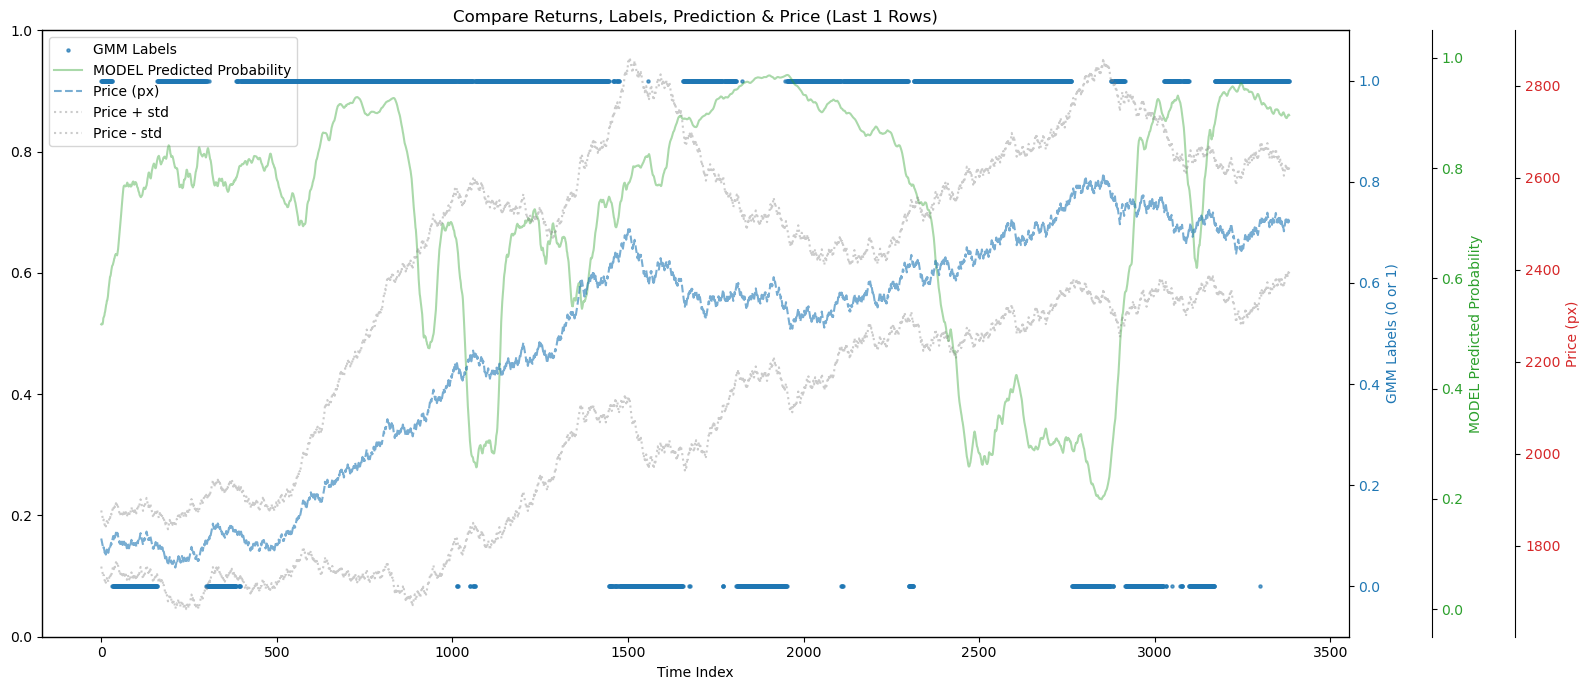

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.89541 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 10 | loss: 0.14181 | val_0_balanced_accuracy: 0.5     |  0:00:08s
epoch 20 | loss: 0.12565 | val_0_balanced_accuracy: 0.5     |  0:00:16s
epoch 30 | loss: 0.09686 | val_0_balanced_accuracy: 0.55314 |  0:00:24s
epoch 40 | loss: 0.09183 | val_0_balanced_accuracy: 0.52155 |  0:00:32s
epoch 50 | loss: 0.08784 | val_0_balanced_accuracy: 0.49674 |  0:00:40s
epoch 60 | loss: 0.07807 | val_0_balanced_accuracy: 0.5144  |  0:00:48s
epoch 70 | loss: 0.07892 | val_0_balanced_accuracy: 0.51601 |  0:00:55s

Early stopping occurred at epoch 79 with best_epoch = 29 and best_val_0_balanced_accuracy = 0.56694


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetr


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5995
✅ 自信预测准确率: 0.6328 (阈值 0.2-0.8)
📈 出手率: 44.94%

🧮 自信预测混淆矩阵:
[[  0 199]
 [  0 343]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       199
           1       0.63      1.00      0.78       343

    accuracy                           0.63       542
   macro avg       0.32      0.50      0.39       542
weighted avg       0.40      0.63      0.49       542


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6229
✅ 自信预测准确率: 0.7553 (阈值 0.2-0.8)
📈 出手率: 46.96%

🧮 自信预测混淆矩阵:
[[   3  389]
 [   0 1198]]

📝 分类报告:
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       392
           1       0.75      1.00      0.86      1198

    accuracy                           0.76      1590
   macro avg       0.88      0.50      0.44      1590
weighted avg       0.82      0.76      0.65      1590



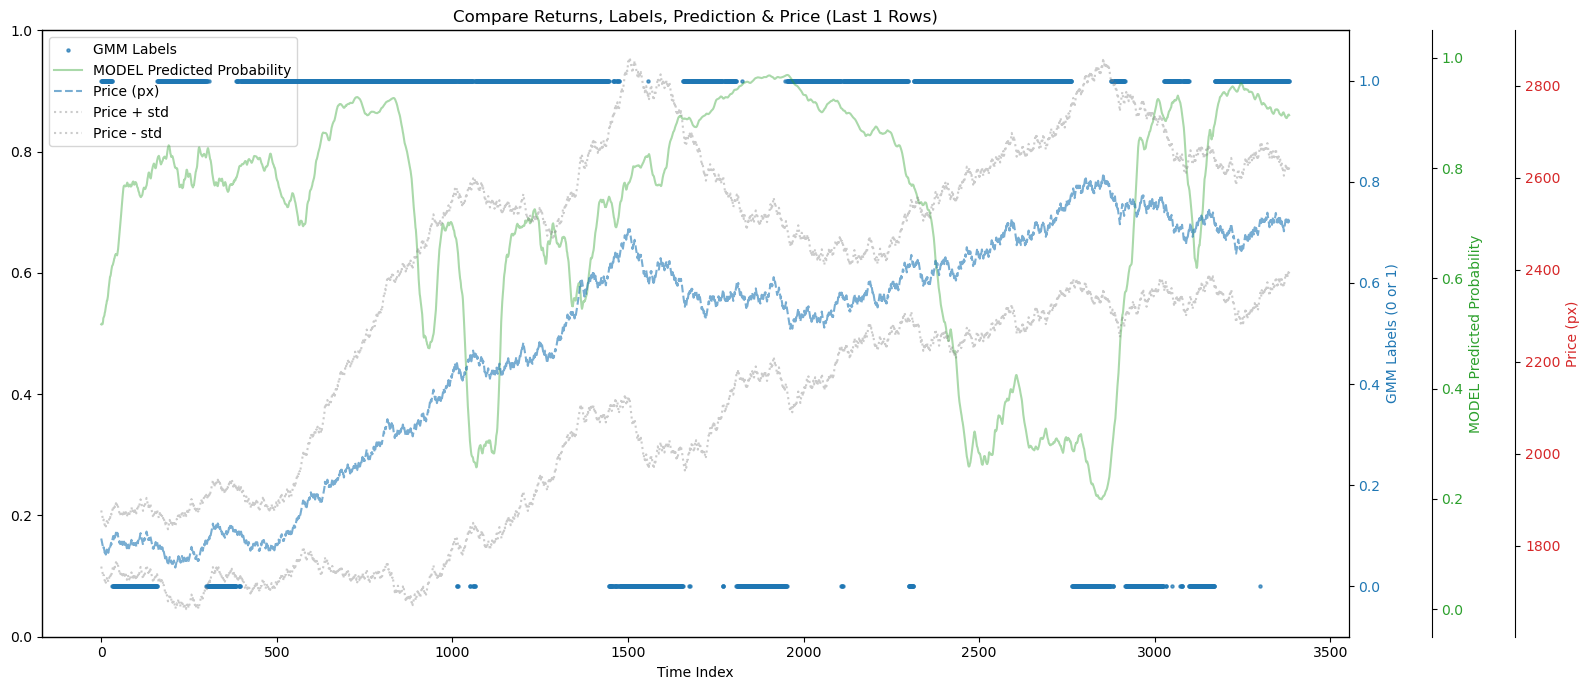

Test Week 3 Evaluation Completed
Fold 1: Train 1~3, Val 4, Test 5
Train: 2025-04-14 00:03:17.936000 to 2025-05-04 23:52:02.529000
Val: 2025-05-05 00:13:13.815000 to 2025-05-11 23:59:42.444000
Test: 2025-05-12 00:03:16.764000 to 2025-05-18 23:59:05.332000
GMM 分量均值: [ 0.01680066 -0.0088352 ]
上涨标签: 0, 下跌标签: 1

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: 0.016801) => 二元标签: 1
GMM 内部标签 1 (均值: -0.008835) => 二元标签: 0

--- 示例标签 ---
训练集原始收益: [0.01971666 0.01973837 0.01979889 0.01993364 0.01569599 0.01575155
 0.01152831 0.00721093 0.00719606 0.0066974 ]
训练集GMM标签: [0 0 0 0 0 0 0 0 0 0]
训练集二元标签: [1 1 1 1 1 1 1 1 1 1]

测试集原始收益: [0.01343143 0.01763264 0.01767684 0.01341697 0.01360223 0.00927834
 0.0133399  0.01341973 0.01333444 0.01334307]
测试集GMM标签: [0 0 0 0 0 0 0 0 0 0]
测试集二元标签: [1 1 1 1 1 1 1 1 1 1]
[1.17873832 1.17873832 1.17873832 ... 0.86833046 0.86833046 0.86833046]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95149 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 10 | loss: 0.2348  | val_0_balanced_accuracy: 0.5     |  0:00:06s
epoch 20 | loss: 0.15163 | val_0_balanced_accuracy: 0.45855 |  0:00:11s
epoch 30 | loss: 0.13547 | val_0_balanced_accuracy: 0.36981 |  0:00:17s
epoch 40 | loss: 0.1148  | val_0_balanced_accuracy: 0.43134 |  0:00:23s
epoch 50 | loss: 0.11901 | val_0_balanced_accuracy: 0.45524 |  0:00:28s

Early stopping occurred at epoch 50 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.5


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.5794
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!

=== tabnet 评估结果 ===
📊 全样本准确率: 0.3628
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


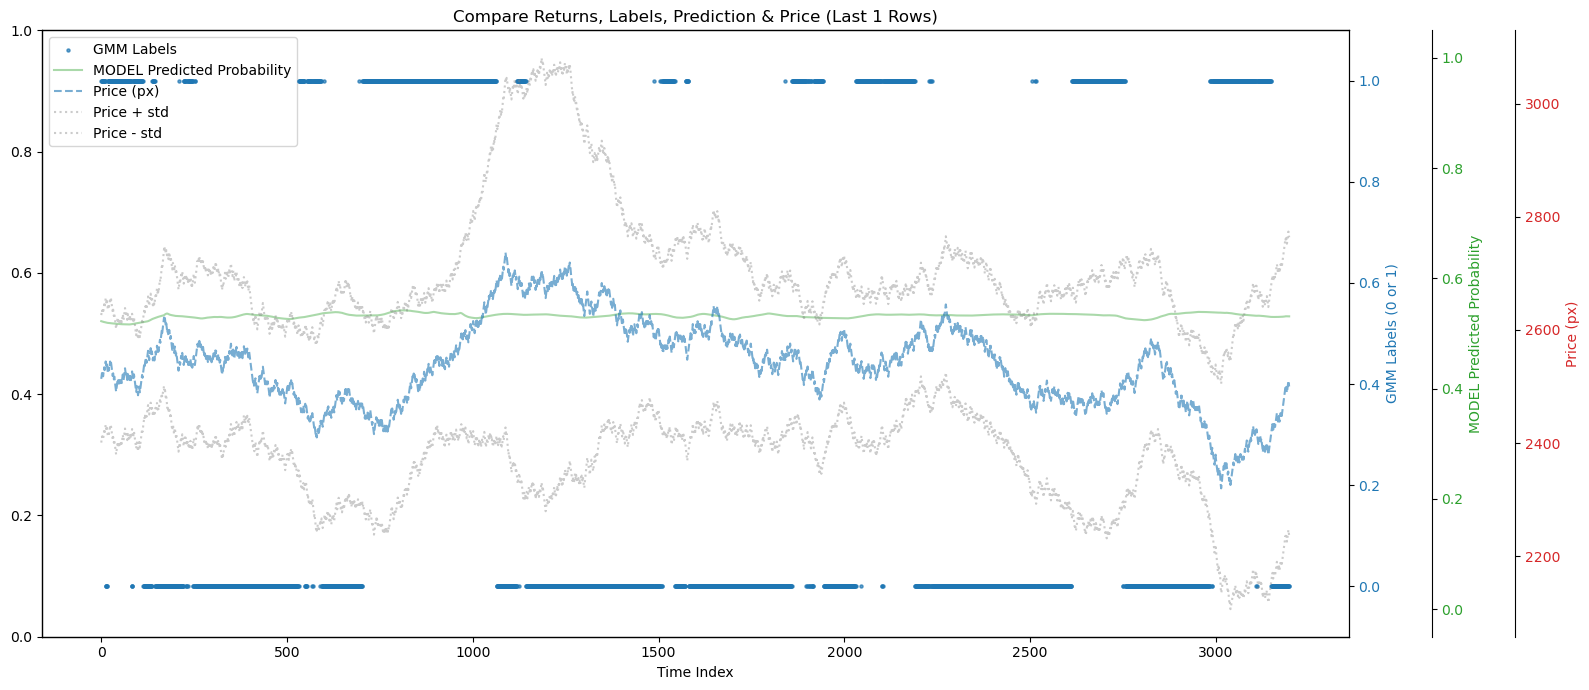

epoch 0  | loss: 0.65133 | val_0_balanced_accuracy: 0.42421 |  0:00:00s
epoch 10 | loss: 0.15612 | val_0_balanced_accuracy: 0.50947 |  0:00:06s

Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.549


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5260
✅ 自信预测准确率: 0.4380 (阈值 0.2-0.8)
📈 出手率: 42.14%

🧮 自信预测混淆矩阵:
[[310 280]
 [522 315]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.37      0.53      0.44       590
           1       0.53      0.38      0.44       837

    accuracy                           0.44      1427
   macro avg       0.45      0.45      0.44      1427
weighted avg       0.46      0.44      0.44      1427


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6112
✅ 自信预测准确率: 0.6283 (阈值 0.2-0.8)
📈 出手率: 41.03%

🧮 自信预测混淆矩阵:
[[698 239]
 [249 127]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       937
           1       0.35      0.34      0.34       376

    accuracy                           0.63      1313
   macro avg       0.54      0.54      0.54      1313
weighted avg       0.63      0.63      0.63      1313



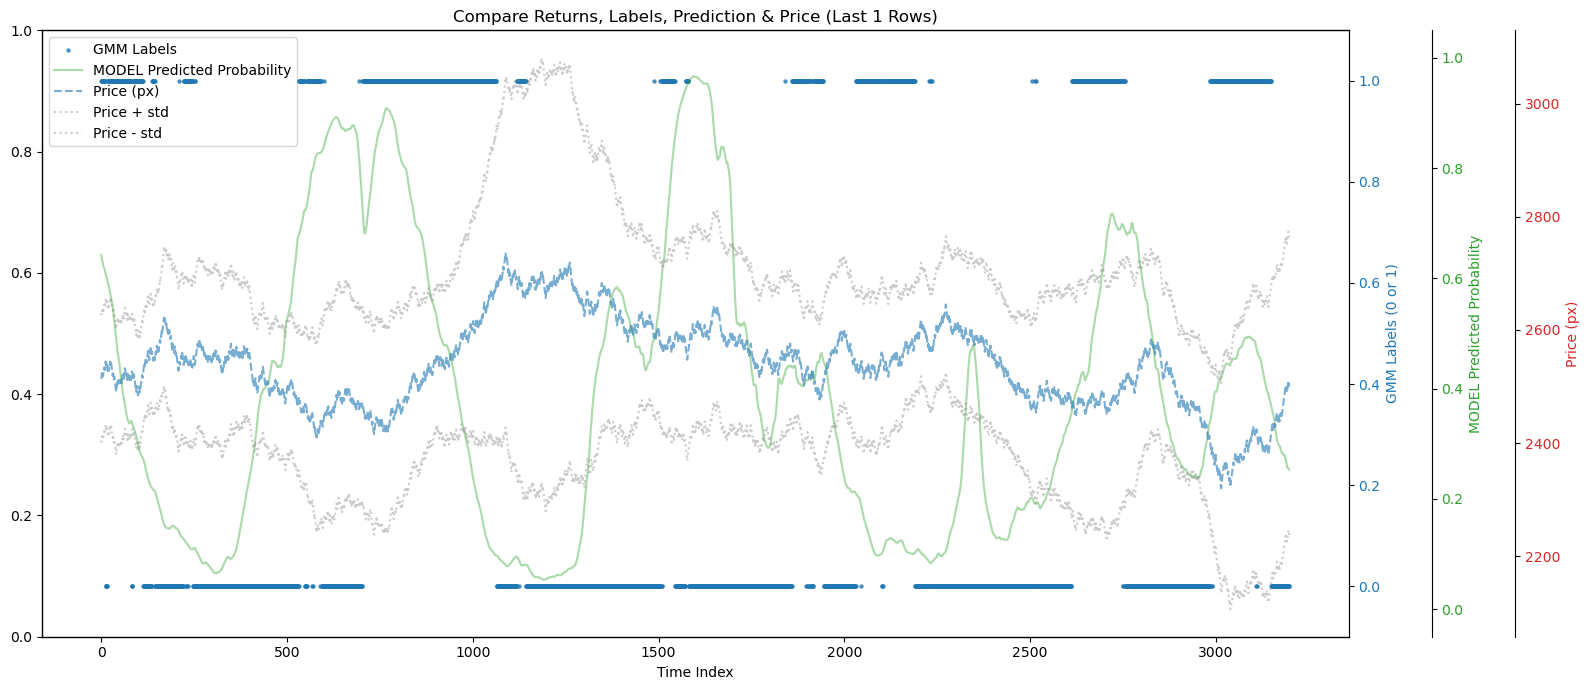

Test Week 4 Evaluation Completed
Fold 2: Train 2~4, Val 5, Test 6
Train: 2025-04-21 00:06:26.581000 to 2025-05-11 23:59:42.444000
Val: 2025-05-12 00:03:16.764000 to 2025-05-18 23:59:05.332000
Test: 2025-05-19 00:00:37.037000 to 2025-05-25 23:56:39.408000
GMM 分量均值: [-0.00512552  0.02719347]
上涨标签: 1, 下跌标签: 0

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: -0.005126) => 二元标签: 0
GMM 内部标签 1 (均值: 0.027193) => 二元标签: 1

--- 示例标签 ---
训练集原始收益: [0.02250527 0.02259717 0.01841655 0.01432233 0.01012496 0.01009195
 0.01009655 0.01419499 0.01002752 0.00595843]
训练集GMM标签: [1 1 1 0 0 0 0 0 0 0]
训练集二元标签: [1 1 1 0 0 0 0 0 0 0]

测试集原始收益: [-0.04629526 -0.04244371 -0.04244895 -0.03845025 -0.04231377 -0.03843045
 -0.03447929 -0.03851767 -0.04250991 -0.04251289]
测试集GMM标签: [0 0 0 0 0 0 0 0 0 0]
测试集二元标签: [0 0 0 0 0 0 0 0 0 0]
[1.33608166 1.33608166 1.33608166 ... 1.33608166 0.79901385 0.79901385]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.94878 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 10 | loss: 0.18511 | val_0_balanced_accuracy: 0.47518 |  0:00:08s
epoch 20 | loss: 0.15568 | val_0_balanced_accuracy: 0.50507 |  0:00:16s
epoch 30 | loss: 0.12035 | val_0_balanced_accuracy: 0.55232 |  0:00:24s
epoch 40 | loss: 0.11423 | val_0_balanced_accuracy: 0.51049 |  0:00:32s
epoch 50 | loss: 0.09501 | val_0_balanced_accuracy: 0.49793 |  0:00:40s
epoch 60 | loss: 0.08923 | val_0_balanced_accuracy: 0.50567 |  0:00:47s
epoch 70 | loss: 0.08406 | val_0_balanced_accuracy: 0.49963 |  0:00:55s

Early stopping occurred at epoch 77 with best_epoch = 27 and best_val_0_balanced_accuracy = 0.55433


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetr


=== tabnet 评估结果 ===
📊 全样本准确率: 0.7178
✅ 自信预测准确率: 0.7514 (阈值 0.2-0.8)
📈 出手率: 51.78%

🧮 自信预测混淆矩阵:
[[1245    0]
 [ 412    0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      1245
           1       0.00      0.00      0.00       412

    accuracy                           0.75      1657
   macro avg       0.38      0.50      0.43      1657
weighted avg       0.56      0.75      0.64      1657


=== tabnet 评估结果 ===
📊 全样本准确率: 0.6702
✅ 自信预测准确率: 0.6761 (阈值 0.2-0.8)
📈 出手率: 41.45%

🧮 自信预测混淆矩阵:
[[764   0]
 [366   0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       764
           1       0.00      0.00      0.00       366

    accuracy                           0.68      1130
   macro avg       0.34      0.50      0.40      1130
weighted avg       0.46      0.68      0.55      1130



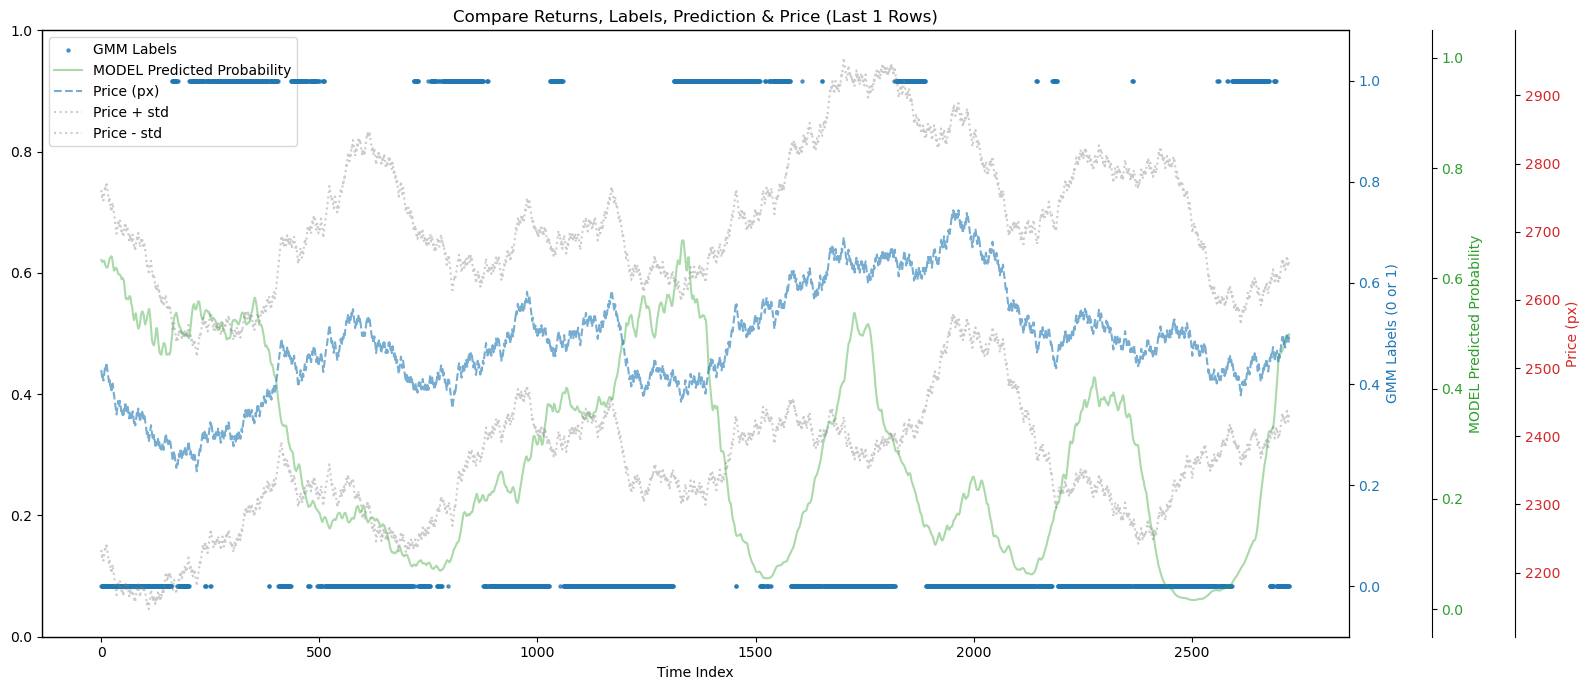

epoch 0  | loss: 0.48146 | val_0_balanced_accuracy: 0.59317 |  0:00:00s
epoch 10 | loss: 0.1398  | val_0_balanced_accuracy: 0.38071 |  0:00:08s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.59317


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6269
✅ 自信预测准确率: 0.5973 (阈值 0.2-0.8)
📈 出手率: 9.31%

🧮 自信预测混淆矩阵:
[[169 120]
 [  0   9]]

📝 分类报告:
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       289
           1       0.07      1.00      0.13         9

    accuracy                           0.60       298
   macro avg       0.53      0.79      0.43       298
weighted avg       0.97      0.60      0.72       298


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5858
✅ 自信预测准确率: 0.8530 (阈值 0.2-0.8)
📈 出手率: 15.22%

🧮 自信预测混淆矩阵:
[[240  58]
 [  3 114]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       298
           1       0.66      0.97      0.79       117

    accuracy                           0.85       415
   macro avg       0.83      0.89      0.84       415
weighted avg       0.90      0.85      0.86       415



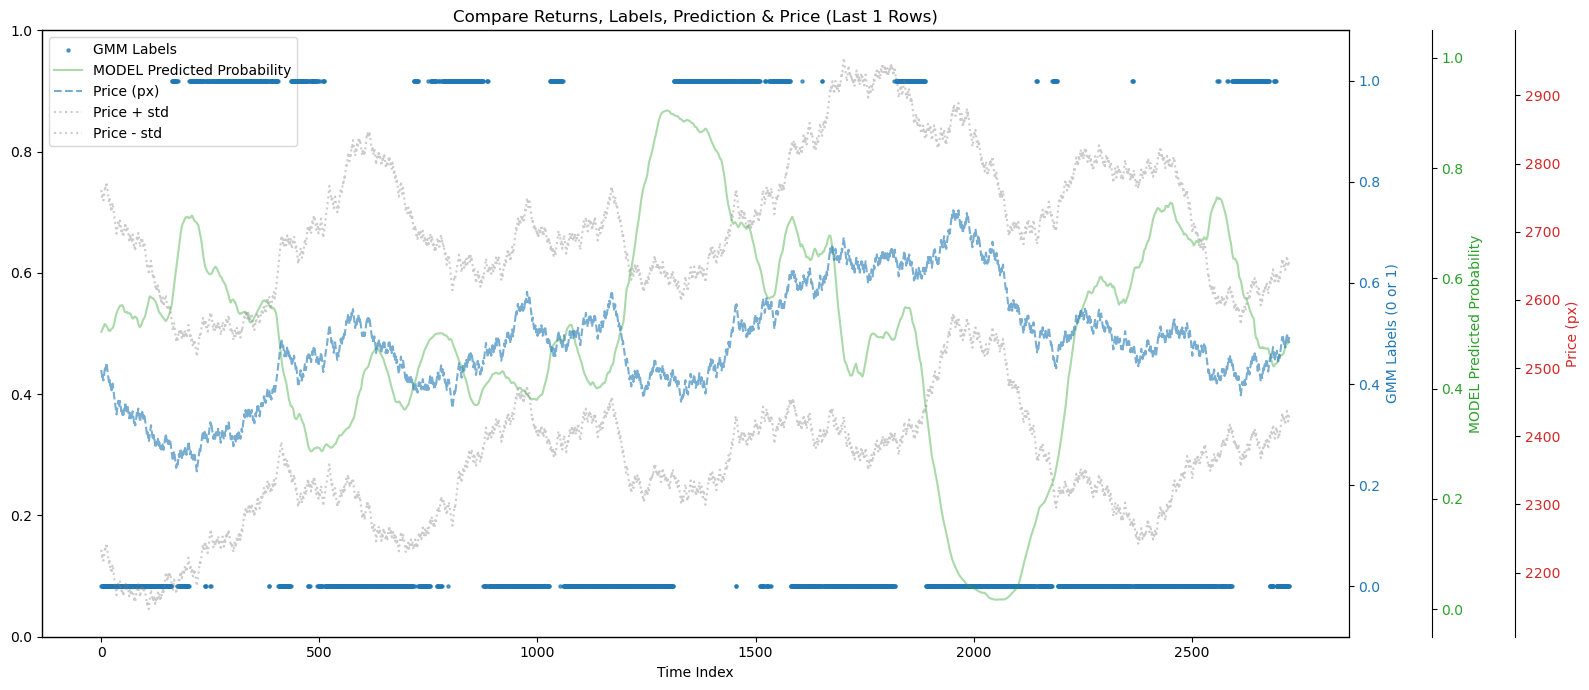

Test Week 5 Evaluation Completed
Fold 3: Train 3~5, Val 6, Test 7
Train: 2025-04-28 00:07:09.088000 to 2025-05-18 23:59:05.332000
Val: 2025-05-19 00:00:37.037000 to 2025-05-25 23:56:39.408000
Test: 2025-05-26 00:03:04.226000 to 2025-06-01 23:42:44.132000
GMM 分量均值: [-0.00966613  0.02616709]
上涨标签: 1, 下跌标签: 0

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: -0.009666) => 二元标签: 0
GMM 内部标签 1 (均值: 0.026167) => 二元标签: 1

--- 示例标签 ---
训练集原始收益: [0.01341895 0.01368825 0.01938975 0.01494005 0.01979166 0.01539629
 0.01959183 0.01964257 0.01551814 0.01463321]
训练集GMM标签: [1 1 1 1 1 1 1 1 1 1]
训练集二元标签: [1 1 1 1 1 1 1 1 1 1]

测试集原始收益: [0.00229329 0.00226657 0.00225418 0.00629772 0.0062947  0.01070934
 0.01073498 0.01024515 0.01020392 0.00616318]
测试集GMM标签: [0 0 0 0 0 0 0 0 0 0]
测试集二元标签: [0 0 0 0 0 0 0 0 0 0]
[1.28115751 1.28115751 1.28115751 ... 0.82003789 0.82003789 0.82003789]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.94545 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 10 | loss: 0.15844 | val_0_balanced_accuracy: 0.6137  |  0:00:09s
epoch 20 | loss: 0.10773 | val_0_balanced_accuracy: 0.48412 |  0:00:18s
epoch 30 | loss: 0.10024 | val_0_balanced_accuracy: 0.52867 |  0:00:26s
epoch 40 | loss: 0.08412 | val_0_balanced_accuracy: 0.57368 |  0:00:34s
epoch 50 | loss: 0.08575 | val_0_balanced_accuracy: 0.48137 |  0:00:43s
epoch 60 | loss: 0.07932 | val_0_balanced_accuracy: 0.48704 |  0:00:51s

Early stopping occurred at epoch 60 with best_epoch = 10 and best_val_0_balanced_accuracy = 0.6137


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.6310
✅ 自信预测准确率: 0.8931 (阈值 0.2-0.8)
📈 出手率: 5.83%

🧮 自信预测混淆矩阵:
[[142  12]
 [  5   0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       154
           1       0.00      0.00      0.00         5

    accuracy                           0.89       159
   macro avg       0.48      0.46      0.47       159
weighted avg       0.94      0.89      0.91       159


=== tabnet 评估结果 ===
📊 全样本准确率: 0.3621
✅ 自信预测准确率: 0.9800 (阈值 0.2-0.8)
📈 出手率: 14.70%

🧮 自信预测混淆矩阵:
[[245   0]
 [  5   0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       245
           1       0.00      0.00      0.00         5

    accuracy                           0.98       250
   macro avg       0.49      0.50      0.49       250
weighted avg       0.96      0.98      0.97       250



C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

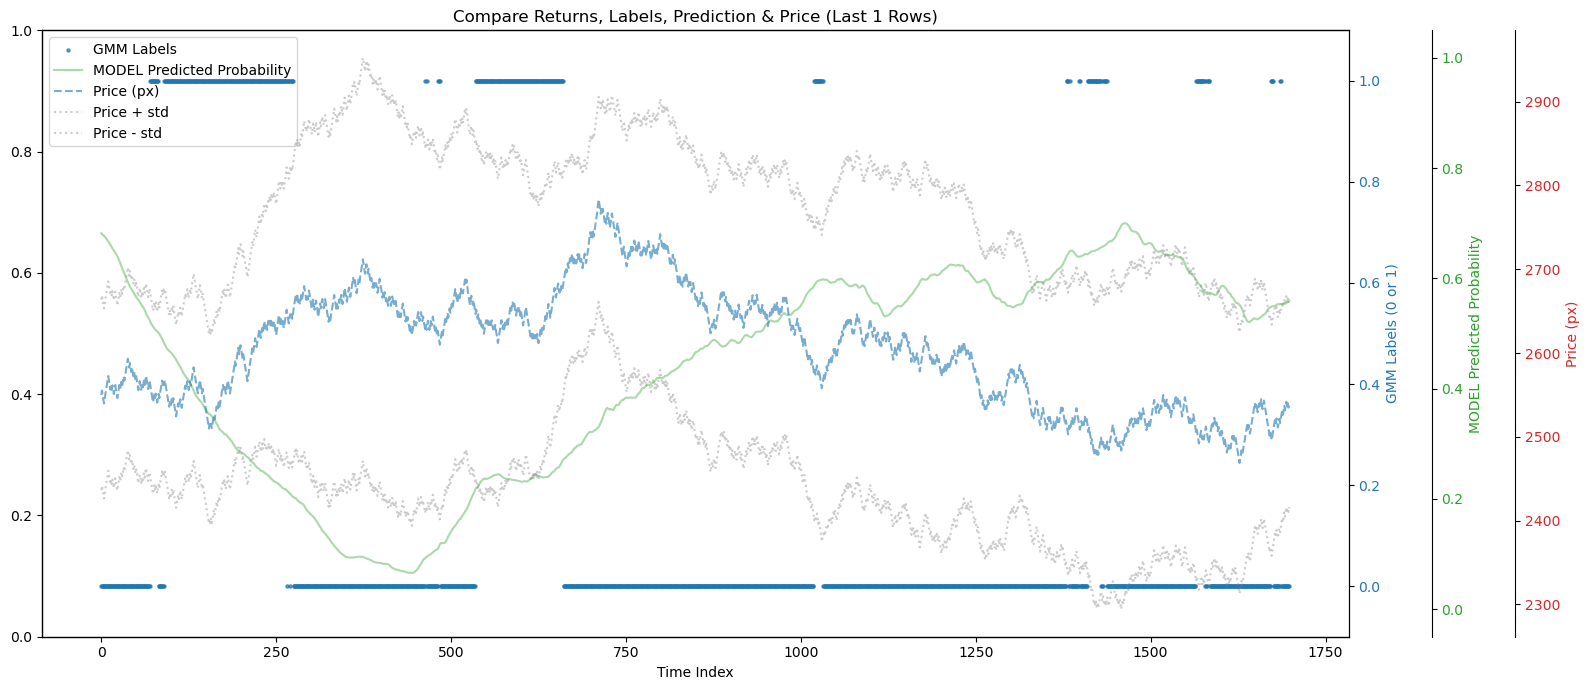

epoch 0  | loss: 0.40703 | val_0_balanced_accuracy: 0.58383 |  0:00:00s
epoch 10 | loss: 0.12953 | val_0_balanced_accuracy: 0.61262 |  0:00:09s

Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.64546


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6790
✅ 自信预测准确率: 0.6968 (阈值 0.2-0.8)
📈 出手率: 46.22%

🧮 自信预测混淆矩阵:
[[632 115]
 [267 246]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       747
           1       0.68      0.48      0.56       513

    accuracy                           0.70      1260
   macro avg       0.69      0.66      0.67      1260
weighted avg       0.69      0.70      0.68      1260


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5226
✅ 自信预测准确率: 0.4793 (阈值 0.2-0.8)
📈 出手率: 56.79%

🧮 自信预测混淆矩阵:
[[432 248]
 [255  31]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.63      0.64      0.63       680
           1       0.11      0.11      0.11       286

    accuracy                           0.48       966
   macro avg       0.37      0.37      0.37       966
weighted avg       0.48      0.48      0.48       966



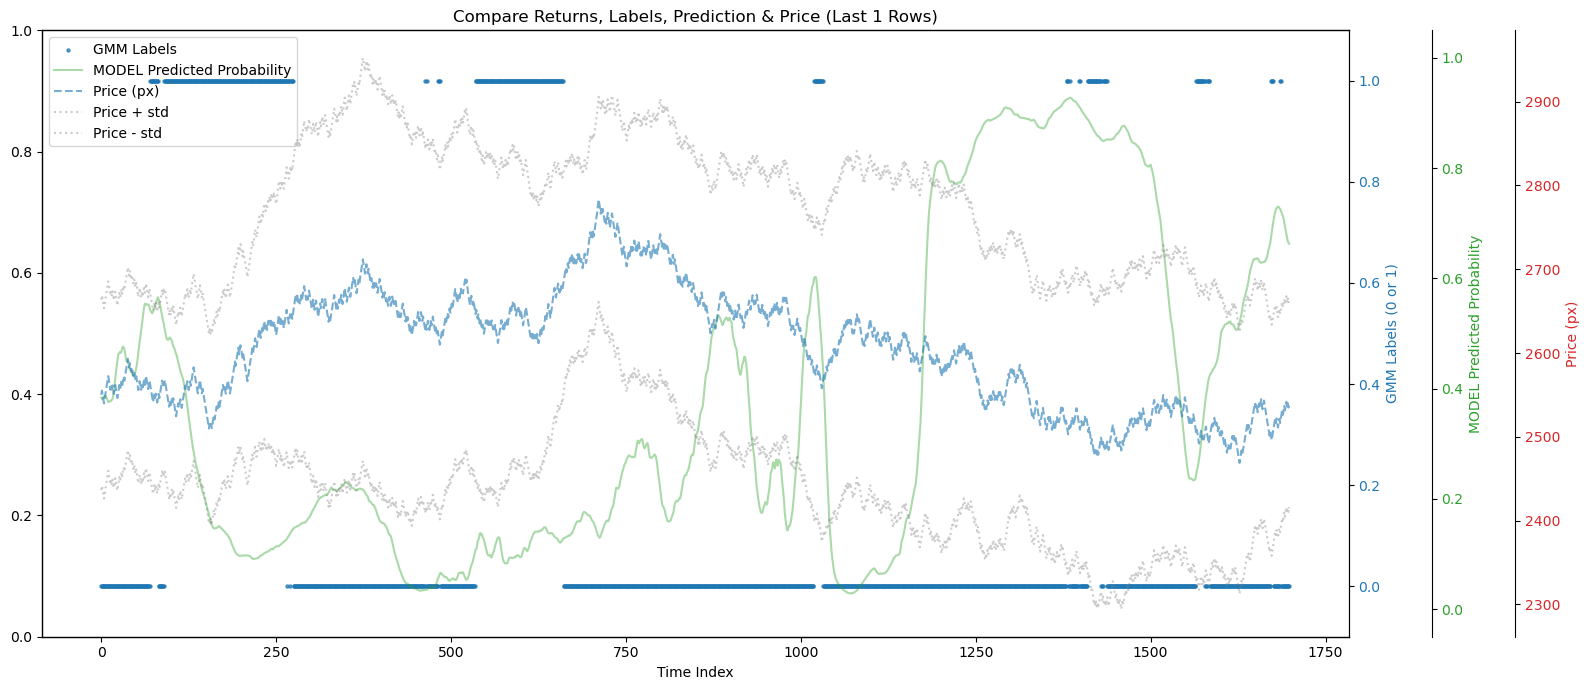

Test Week 6 Evaluation Completed
Fold 4: Train 4~6, Val 7, Test 8
Train: 2025-05-05 00:13:13.815000 to 2025-05-25 23:56:39.408000
Val: 2025-05-26 00:03:04.226000 to 2025-06-01 23:42:44.132000
Test: 2025-06-02 00:19:42.487000 to 2025-06-08 23:42:19.548000
GMM 分量均值: [ 0.02201604 -0.01132371]
上涨标签: 0, 下跌标签: 1

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: 0.022016) => 二元标签: 1
GMM 内部标签 1 (均值: -0.011324) => 二元标签: 0

--- 示例标签 ---
训练集原始收益: [0.00014352 0.00020383 0.00439444 0.0084359  0.01251614 0.01661251
 0.01695774 0.016931   0.0127874  0.01287444]
训练集GMM标签: [1 1 1 0 0 0 0 0 0 0]
训练集二元标签: [0 0 0 1 1 1 1 1 1 1]

测试集原始收益: [0.0041259  0.00413421 0.00414569 0.00821725 0.00409048 0.0040275
 0.00399943 0.00399529 0.00802637 0.01216559]
测试集GMM标签: [1 1 1 0 1 1 1 1 0 0]
测试集二元标签: [0 0 0 1 0 0 0 0 1 1]
[0.96158612 0.96158612 0.96158612 ... 1.04161074 1.04161074 1.04161074]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.88427 | val_0_balanced_accuracy: 0.5     |  0:00:01s
epoch 10 | loss: 0.16344 | val_0_balanced_accuracy: 0.4073  |  0:00:12s
epoch 20 | loss: 0.13396 | val_0_balanced_accuracy: 0.39814 |  0:00:24s
epoch 30 | loss: 0.11329 | val_0_balanced_accuracy: 0.4305  |  0:00:36s
epoch 40 | loss: 0.11172 | val_0_balanced_accuracy: 0.441   |  0:00:48s
epoch 50 | loss: 0.10809 | val_0_balanced_accuracy: 0.48428 |  0:00:59s

Early stopping occurred at epoch 50 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.5


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.3004
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!

=== tabnet 评估结果 ===
📊 全样本准确率: 0.3960
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


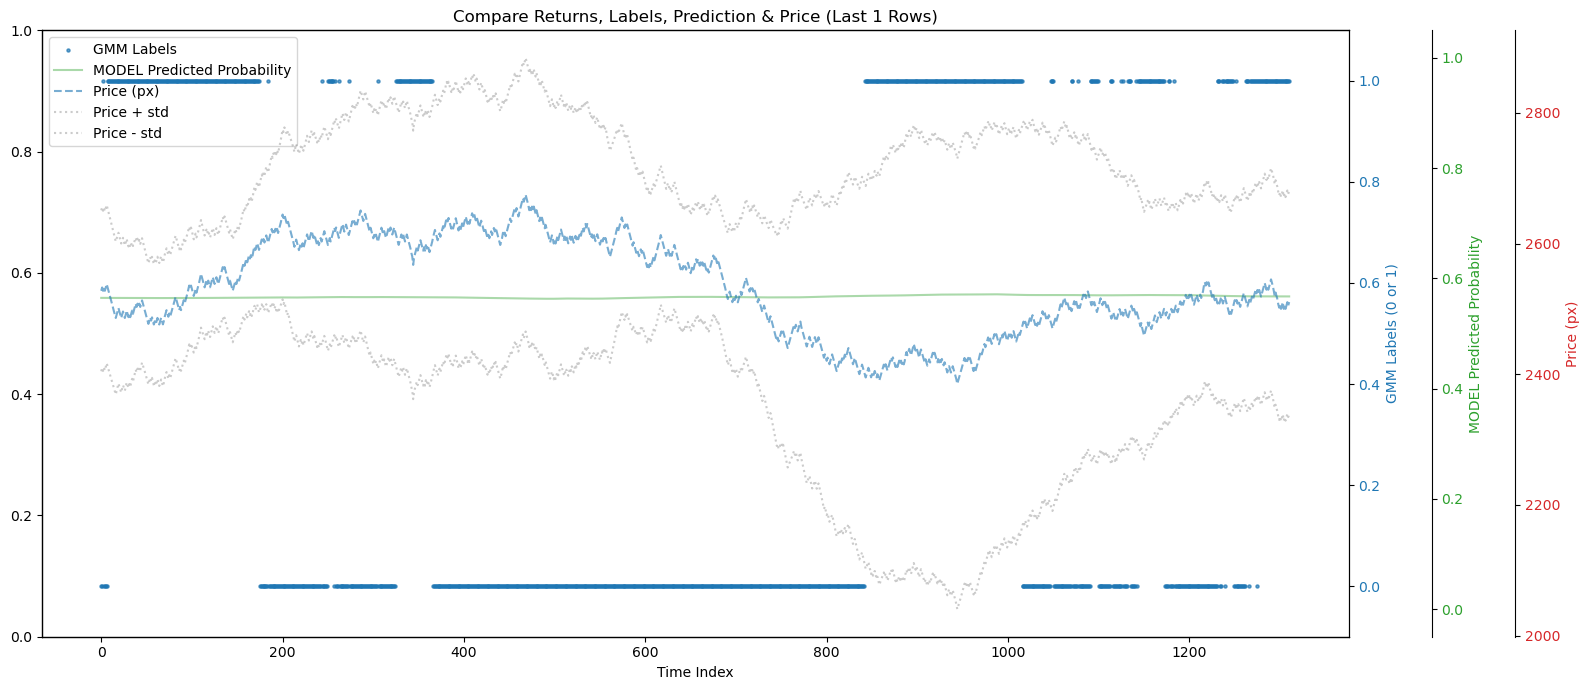

epoch 0  | loss: 0.27211 | val_0_balanced_accuracy: 0.33681 |  0:00:01s
epoch 10 | loss: 0.12153 | val_0_balanced_accuracy: 0.36185 |  0:00:13s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.39782


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.4098
✅ 自信预测准确率: 0.2249 (阈值 0.2-0.8)
📈 出手率: 36.33%

🧮 自信预测混淆矩阵:
[[ 74 387]
 [ 92  65]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.45      0.16      0.24       461
           1       0.14      0.41      0.21       157

    accuracy                           0.22       618
   macro avg       0.29      0.29      0.22       618
weighted avg       0.37      0.22      0.23       618


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6146
✅ 自信预测准确率: 0.6175 (阈值 0.2-0.8)
📈 出手率: 67.10%

🧮 自信预测混淆矩阵:
[[412 145]
 [192 132]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.68      0.74      0.71       557
           1       0.48      0.41      0.44       324

    accuracy                           0.62       881
   macro avg       0.58      0.57      0.57       881
weighted avg       0.61      0.62      0.61       881



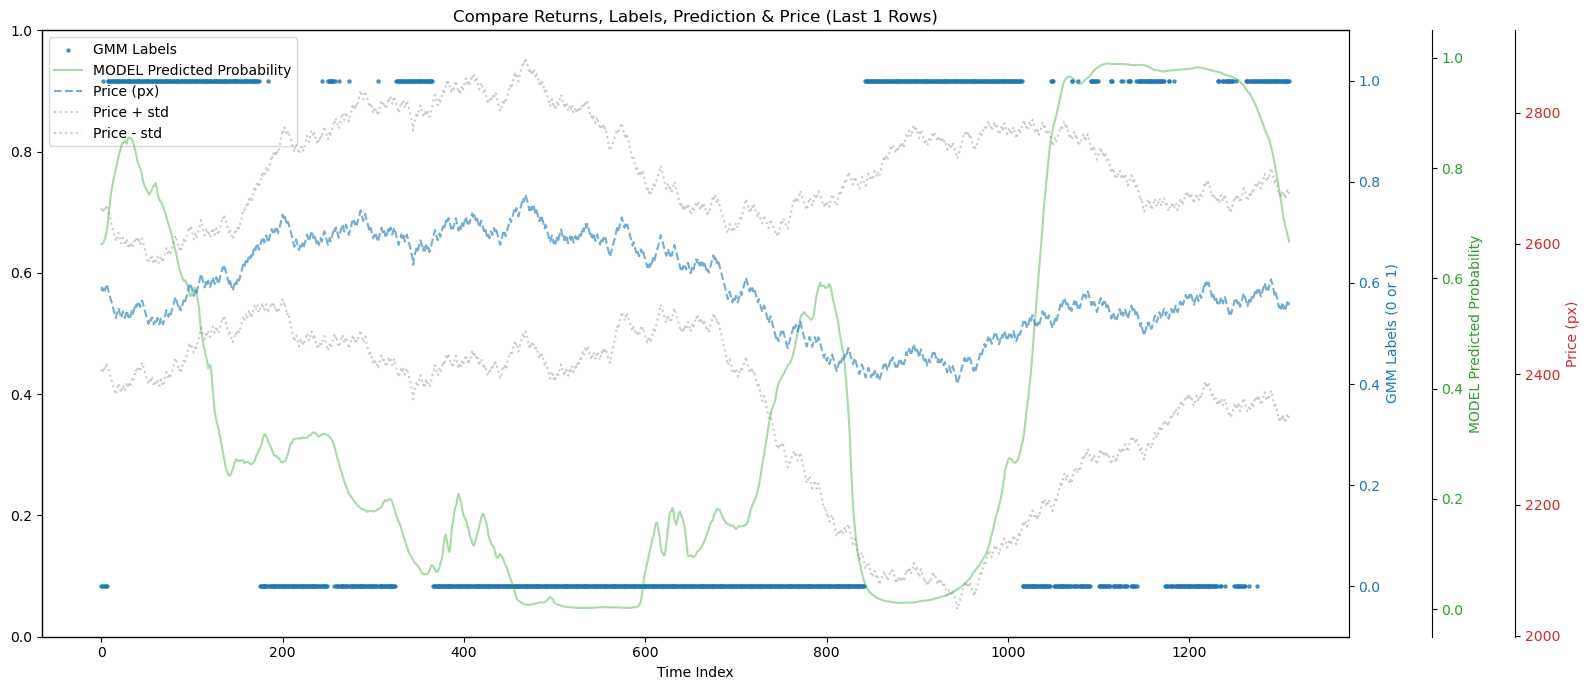

Test Week 7 Evaluation Completed
Fold 5: Train 5~7, Val 8, Test 9
Train: 2025-05-12 00:03:16.764000 to 2025-06-01 23:42:44.132000
Val: 2025-06-02 00:19:42.487000 to 2025-06-08 23:42:19.548000
Test: 2025-06-09 00:07:33.575000 to 2025-06-15 23:19:26.719000
GMM 分量均值: [-0.01422265  0.01594877]
上涨标签: 1, 下跌标签: 0

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: -0.014223) => 二元标签: 0
GMM 内部标签 1 (均值: 0.015949) => 二元标签: 1

--- 示例标签 ---
训练集原始收益: [0.01343143 0.01763264 0.01767684 0.01341697 0.01360223 0.00927834
 0.0133399  0.01341973 0.01333444 0.01334307]
训练集GMM标签: [1 1 1 1 1 1 1 1 1 1]
训练集二元标签: [1 1 1 1 1 1 1 1 1 1]

测试集原始收益: [0.0355201  0.03551678 0.03969094 0.04004704 0.04004394 0.04434988
 0.04436099 0.04859029 0.048567   0.04860669]
测试集GMM标签: [1 1 1 1 1 1 1 1 1 1]
测试集二元标签: [1 1 1 1 1 1 1 1 1 1]
[1.08000566 1.08000566 1.08000566 ... 0.93103027 0.93103027 1.08000566]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.91042 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 10 | loss: 0.17925 | val_0_balanced_accuracy: 0.59322 |  0:00:07s
epoch 20 | loss: 0.126   | val_0_balanced_accuracy: 0.52077 |  0:00:14s
epoch 30 | loss: 0.11539 | val_0_balanced_accuracy: 0.45457 |  0:00:22s
epoch 40 | loss: 0.10627 | val_0_balanced_accuracy: 0.4881  |  0:00:30s
epoch 50 | loss: 0.09697 | val_0_balanced_accuracy: 0.41582 |  0:00:38s

Early stopping occurred at epoch 55 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.79412


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.7944
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!

=== tabnet 评估结果 ===
📊 全样本准确率: 0.5520
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


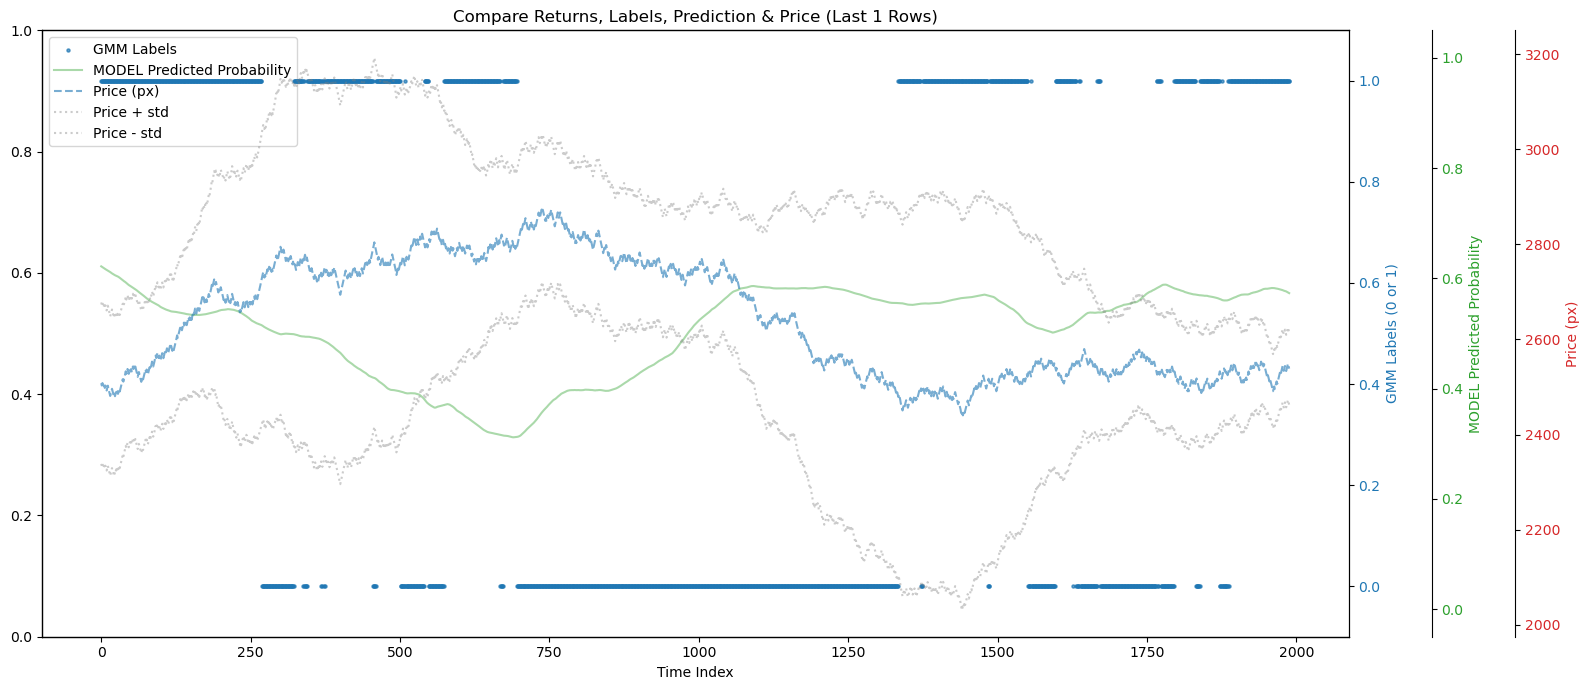

epoch 0  | loss: 0.31002 | val_0_balanced_accuracy: 0.54463 |  0:00:00s
epoch 10 | loss: 0.1245  | val_0_balanced_accuracy: 0.64677 |  0:00:08s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.65822


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6580
✅ 自信预测准确率: 0.5503 (阈值 0.2-0.8)
📈 出手率: 54.53%

🧮 自信预测混淆矩阵:
[[193 123]
 [199 201]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.49      0.61      0.55       316
           1       0.62      0.50      0.56       400

    accuracy                           0.55       716
   macro avg       0.56      0.56      0.55       716
weighted avg       0.56      0.55      0.55       716


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6554
✅ 自信预测准确率: 0.7418 (阈值 0.2-0.8)
📈 出手率: 38.12%

🧮 自信预测混淆矩阵:
[[272 191]
 [  5 291]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.98      0.59      0.74       463
           1       0.60      0.98      0.75       296

    accuracy                           0.74       759
   macro avg       0.79      0.79      0.74       759
weighted avg       0.83      0.74      0.74       759



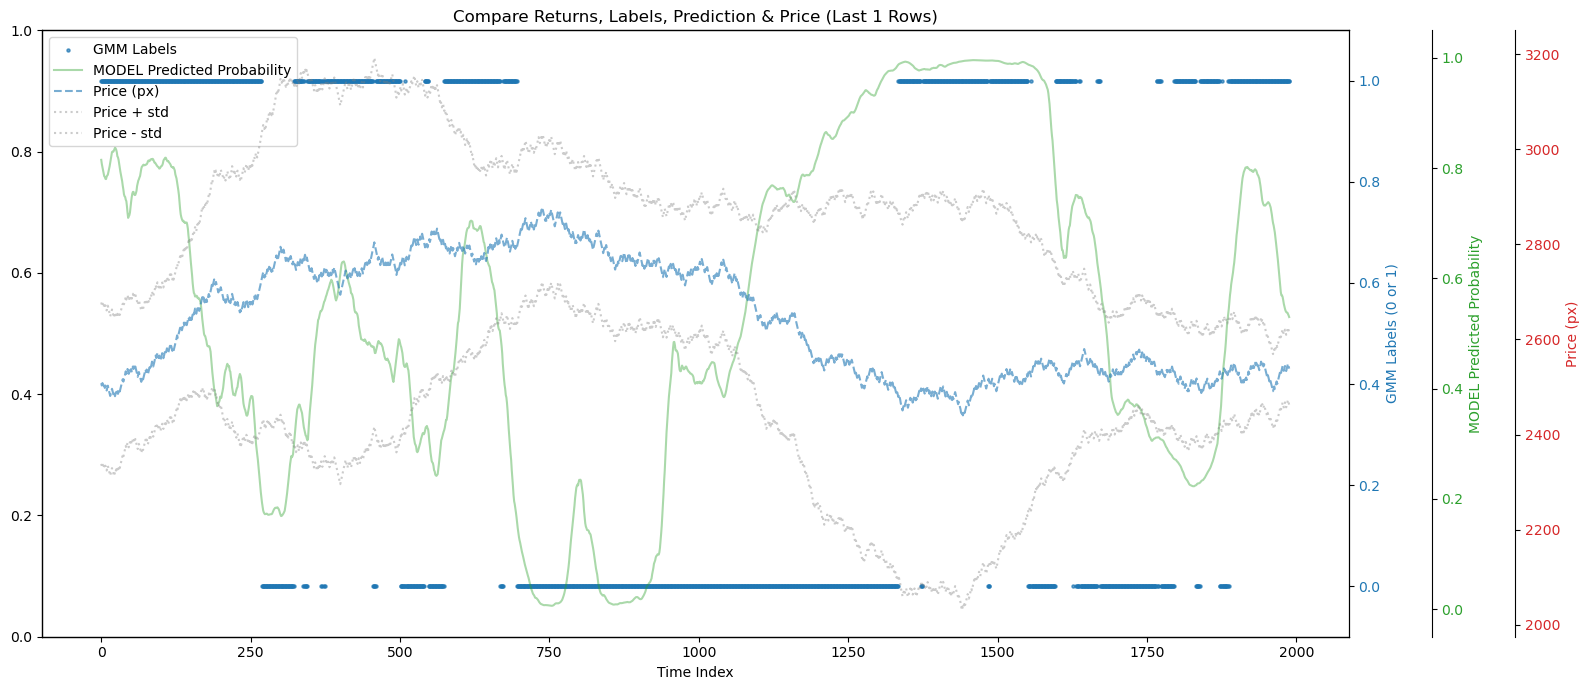

Test Week 8 Evaluation Completed
Fold 6: Train 6~8, Val 9, Test 10
Train: 2025-05-19 00:00:37.037000 to 2025-06-08 23:42:19.548000
Val: 2025-06-09 00:07:33.575000 to 2025-06-15 23:19:26.719000
Test: 2025-06-16 00:11:53.040000 to 2025-06-22 23:50:14.167000
GMM 分量均值: [ 0.01403018 -0.01495412]
上涨标签: 0, 下跌标签: 1

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: 0.014030) => 二元标签: 1
GMM 内部标签 1 (均值: -0.014954) => 二元标签: 0

--- 示例标签 ---
训练集原始收益: [-0.04629526 -0.04244371 -0.04244895 -0.03845025 -0.04231377 -0.03843045
 -0.03447929 -0.03851767 -0.04250991 -0.04251289]
训练集GMM标签: [1 1 1 1 1 1 1 1 1 1]
训练集二元标签: [0 0 0 0 0 0 0 0 0 0]

测试集原始收益: [0.04100931 0.03671717 0.03240447 0.03662512 0.0365845  0.03657392
 0.040845   0.04091854 0.04107878 0.04114851]
测试集GMM标签: [0 0 0 0 0 0 0 0 0 0]
测试集二元标签: [1 1 1 1 1 1 1 1 1 1]
[1.20436425 1.20436425 1.20436425 ... 0.85493    0.85493    0.85493   ]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.98025 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 10 | loss: 0.18402 | val_0_balanced_accuracy: 0.49306 |  0:00:07s
epoch 20 | loss: 0.16265 | val_0_balanced_accuracy: 0.47082 |  0:00:12s
epoch 30 | loss: 0.13358 | val_0_balanced_accuracy: 0.47076 |  0:00:18s
epoch 40 | loss: 0.11329 | val_0_balanced_accuracy: 0.54698 |  0:00:24s
epoch 50 | loss: 0.11538 | val_0_balanced_accuracy: 0.55373 |  0:00:29s
epoch 60 | loss: 0.09456 | val_0_balanced_accuracy: 0.6308  |  0:00:36s
epoch 70 | loss: 0.0934  | val_0_balanced_accuracy: 0.60181 |  0:00:42s
epoch 80 | loss: 0.0986  | val_0_balanced_accuracy: 0.63442 |  0:00:48s
epoch 90 | loss: 0.08387 | val_0_balanced_accuracy: 0.6118  |  0:00:54s
epoch 100| loss: 0.08441 | val_0_balanced_accuracy: 0.62913 |  0:01:01s
epoch 110| loss: 0.0858  | val_0_balanced_accuracy: 0.6418  |  0:01:07s
epoch 120| loss: 0.08595 | val_0_balanced_accuracy: 0.65039 |  0:01:13s
epoch 130| loss: 0.06694 | val_0_balanced_accuracy: 0.63303 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.6986
✅ 自信预测准确率: 0.7348 (阈值 0.2-0.8)
📈 出手率: 81.62%

🧮 自信预测混淆矩阵:
[[575 121]
 [310 619]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.65      0.83      0.73       696
           1       0.84      0.67      0.74       929

    accuracy                           0.73      1625
   macro avg       0.74      0.75      0.73      1625
weighted avg       0.76      0.73      0.74      1625


=== tabnet 评估结果 ===
📊 全样本准确率: 0.5456
✅ 自信预测准确率: 0.5401 (阈值 0.2-0.8)
📈 出手率: 73.50%

🧮 自信预测混淆矩阵:
[[357 601]
 [218 605]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.62      0.37      0.47       958
           1       0.50      0.74      0.60       823

    accuracy                           0.54      1781
   macro avg       0.56      0.55      0.53      1781
weighted avg       0.57      0.54      0.53      1781



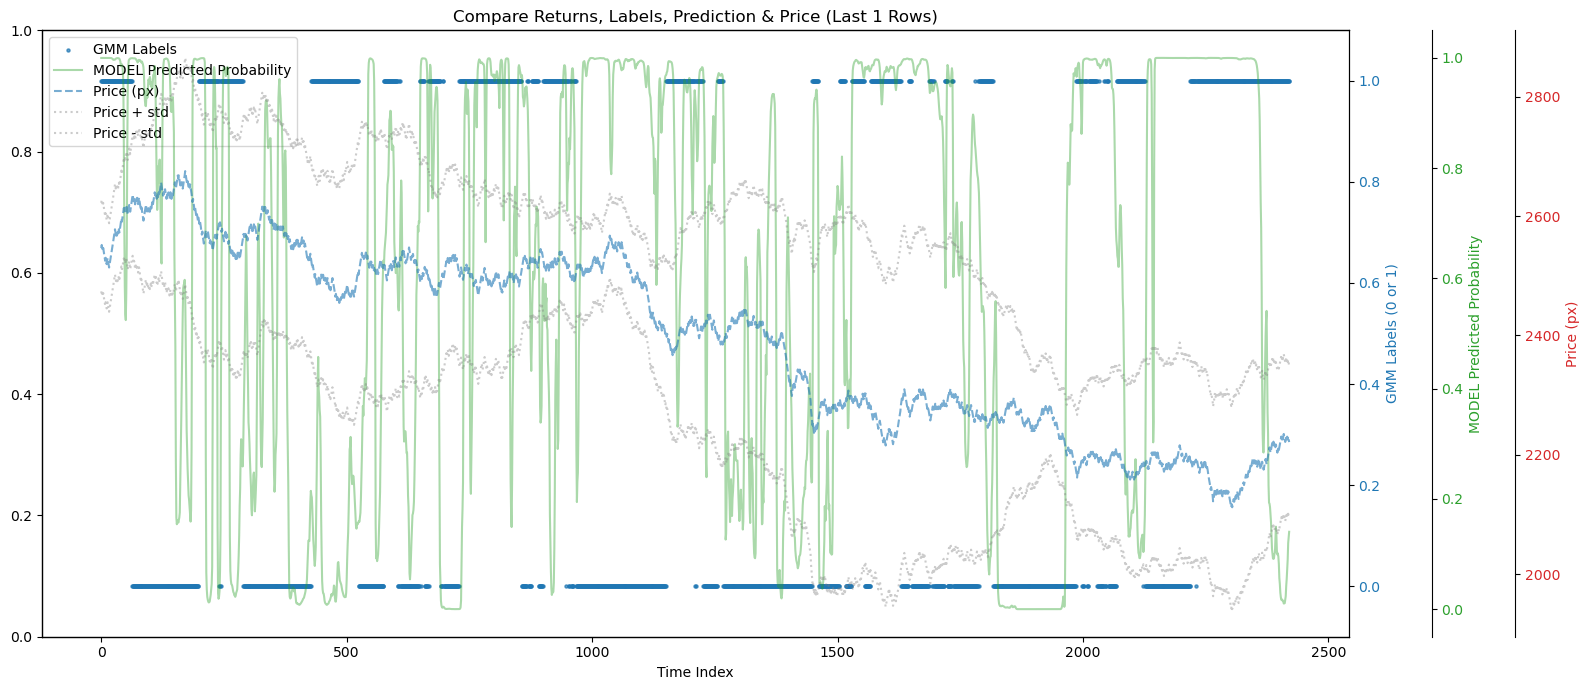

epoch 0  | loss: 0.33533 | val_0_balanced_accuracy: 0.60082 |  0:00:00s
epoch 10 | loss: 0.13884 | val_0_balanced_accuracy: 0.51671 |  0:00:06s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.60082


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6027
✅ 自信预测准确率: 0.5878 (阈值 0.2-0.8)
📈 出手率: 46.06%

🧮 自信预测混淆矩阵:
[[149 220]
 [158 390]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.49      0.40      0.44       369
           1       0.64      0.71      0.67       548

    accuracy                           0.59       917
   macro avg       0.56      0.56      0.56       917
weighted avg       0.58      0.59      0.58       917


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.4812
✅ 自信预测准确率: 0.5651 (阈值 0.2-0.8)
📈 出手率: 39.29%

🧮 自信预测混淆矩阵:
[[422  89]
 [325 116]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.56      0.83      0.67       511
           1       0.57      0.26      0.36       441

    accuracy                           0.57       952
   macro avg       0.57      0.54      0.52       952
weighted avg       0.57      0.57      0.53       952



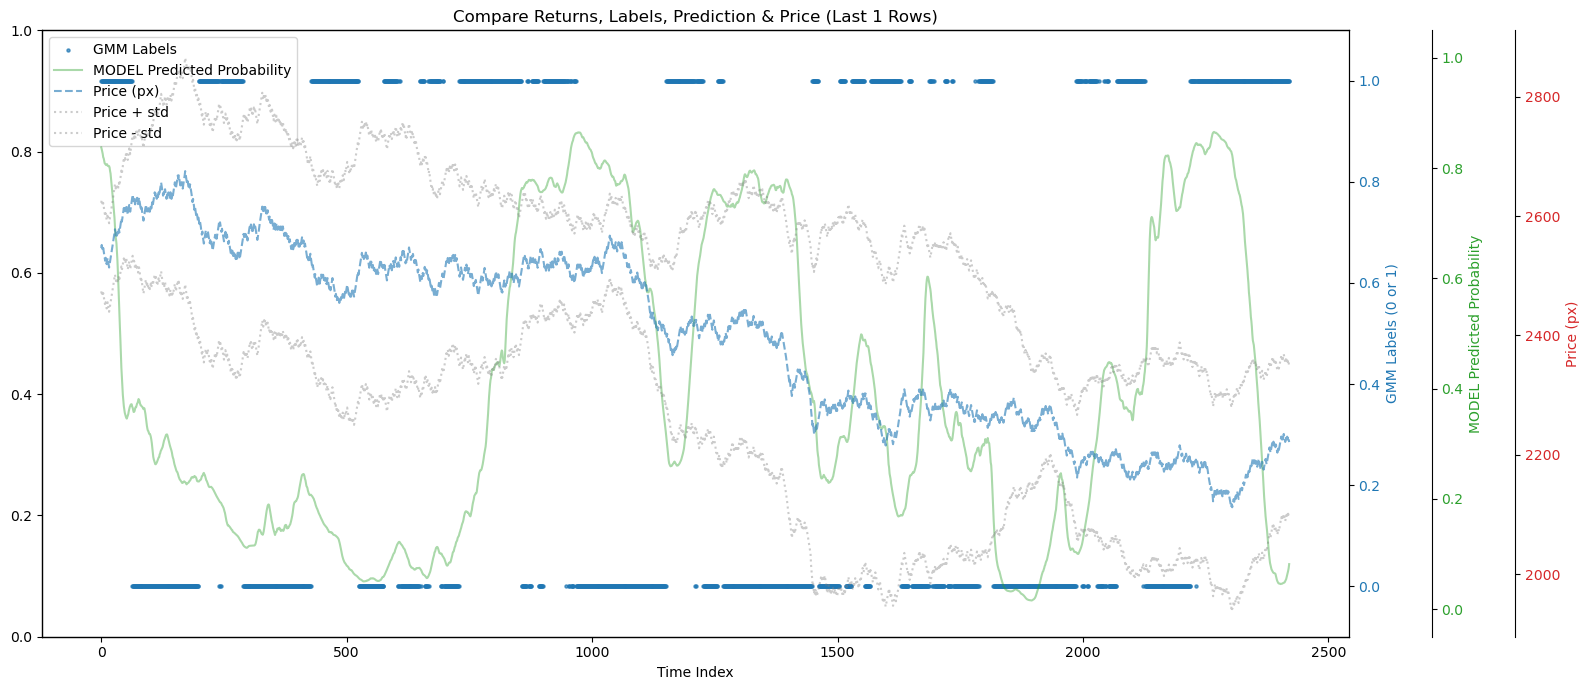

Test Week 9 Evaluation Completed
Fold 7: Train 7~9, Val 10, Test 11
Train: 2025-05-26 00:03:04.226000 to 2025-06-15 23:19:26.719000
Val: 2025-06-16 00:11:53.040000 to 2025-06-22 23:50:14.167000
Test: 2025-06-23 00:01:33.194000 to 2025-06-29 23:46:28.177000
GMM 分量均值: [ 0.01819938 -0.01104643]
上涨标签: 0, 下跌标签: 1

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: 0.018199) => 二元标签: 1
GMM 内部标签 1 (均值: -0.011046) => 二元标签: 0

--- 示例标签 ---
训练集原始收益: [0.00229329 0.00226657 0.00225418 0.00629772 0.0062947  0.01070934
 0.01073498 0.01024515 0.01020392 0.00616318]
训练集GMM标签: [1 1 1 1 1 0 0 0 0 1]
训练集二元标签: [0 0 0 0 0 1 1 1 1 0]

测试集原始收益: [0.01735972 0.01784583 0.01786363 0.01786361 0.02224344 0.02635421
 0.02642587 0.02686402 0.02703354 0.02285164]
测试集GMM标签: [0 0 0 0 0 0 0 0 0 0]
测试集二元标签: [1 1 1 1 1 1 1 1 1 1]
[0.75399217 0.75399217 0.75399217 ... 1.48428233 1.48428233 1.48428233]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.97778 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 10 | loss: 0.17219 | val_0_balanced_accuracy: 0.47063 |  0:00:05s
epoch 20 | loss: 0.12747 | val_0_balanced_accuracy: 0.51602 |  0:00:10s
epoch 30 | loss: 0.11425 | val_0_balanced_accuracy: 0.49404 |  0:00:16s
epoch 40 | loss: 0.09662 | val_0_balanced_accuracy: 0.53112 |  0:00:21s
epoch 50 | loss: 0.09028 | val_0_balanced_accuracy: 0.5509  |  0:00:26s
epoch 60 | loss: 0.08401 | val_0_balanced_accuracy: 0.54437 |  0:00:31s
epoch 70 | loss: 0.07428 | val_0_balanced_accuracy: 0.52508 |  0:00:36s
epoch 80 | loss: 0.07264 | val_0_balanced_accuracy: 0.59731 |  0:00:41s
epoch 90 | loss: 0.06822 | val_0_balanced_accuracy: 0.58873 |  0:00:46s
epoch 100| loss: 0.0655  | val_0_balanced_accuracy: 0.54234 |  0:00:51s
epoch 110| loss: 0.05812 | val_0_balanced_accuracy: 0.60288 |  0:00:57s
epoch 120| loss: 0.05912 | val_0_balanced_accuracy: 0.62266 |  0:01:02s
epoch 130| loss: 0.06191 | val_0_balanced_accuracy: 0.65585 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.7449
✅ 自信预测准确率: 0.7757 (阈值 0.2-0.8)
📈 出手率: 60.54%

🧮 自信预测混淆矩阵:
[[905 223]
 [106 233]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      1128
           1       0.51      0.69      0.59       339

    accuracy                           0.78      1467
   macro avg       0.70      0.74      0.72      1467
weighted avg       0.81      0.78      0.79      1467


=== tabnet 评估结果 ===
📊 全样本准确率: 0.6764
✅ 自信预测准确率: 0.7556 (阈值 0.2-0.8)
📈 出手率: 49.75%

🧮 自信预测混淆矩阵:
[[415  45]
 [150 188]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.73      0.90      0.81       460
           1       0.81      0.56      0.66       338

    accuracy                           0.76       798
   macro avg       0.77      0.73      0.73       798
weighted avg       0.77      0.76      0.75       798



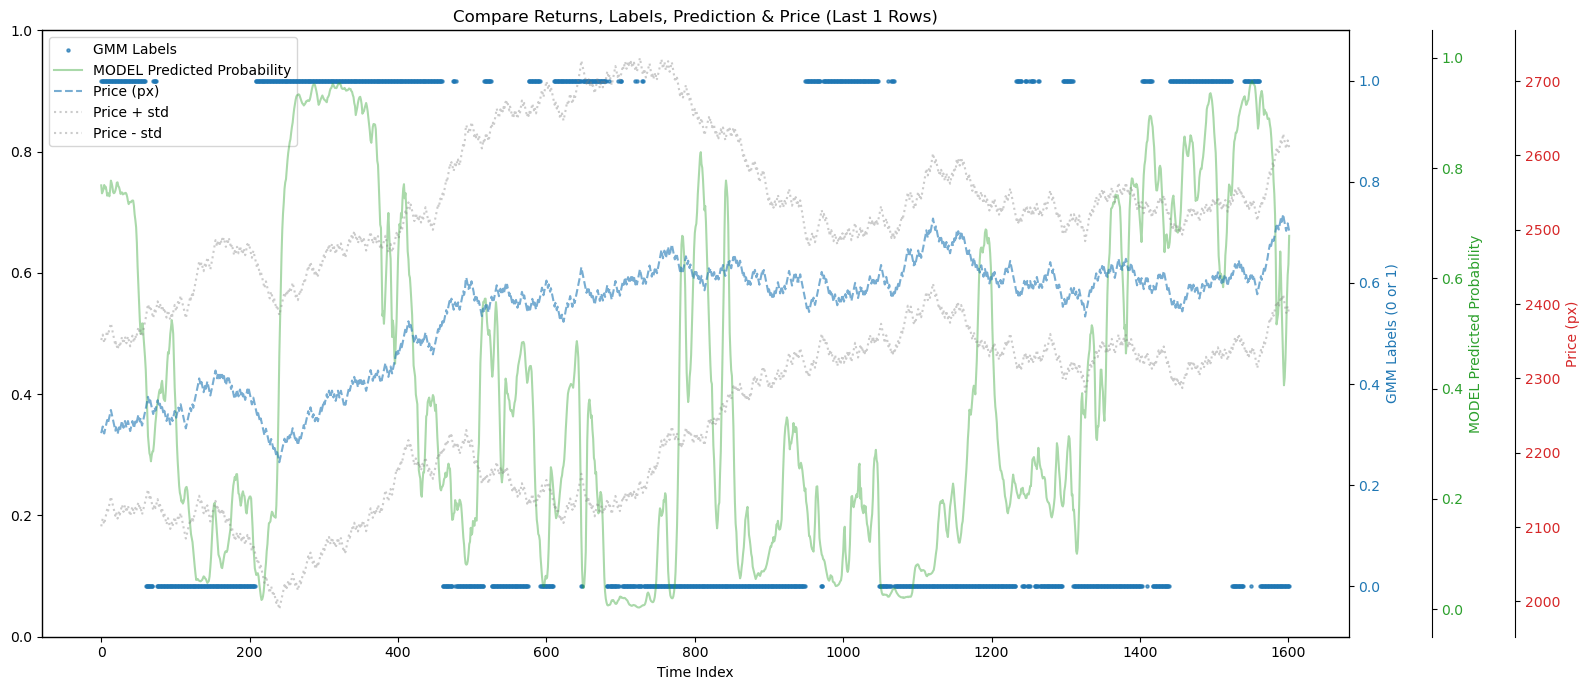

epoch 0  | loss: 0.45505 | val_0_balanced_accuracy: 0.4602  |  0:00:00s
epoch 10 | loss: 0.12379 | val_0_balanced_accuracy: 0.50605 |  0:00:05s
epoch 20 | loss: 0.09646 | val_0_balanced_accuracy: 0.54711 |  0:00:10s
epoch 30 | loss: 0.08188 | val_0_balanced_accuracy: 0.50903 |  0:00:16s

Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_balanced_accuracy = 0.54711


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6566
✅ 自信预测准确率: 0.6544 (阈值 0.2-0.8)
📈 出手率: 71.52%

🧮 自信预测混淆矩阵:
[[1037  304]
 [ 295   97]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1341
           1       0.24      0.25      0.24       392

    accuracy                           0.65      1733
   macro avg       0.51      0.51      0.51      1733
weighted avg       0.66      0.65      0.66      1733


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.4763
✅ 自信预测准确率: 0.4541 (阈值 0.2-0.8)
📈 出手率: 70.70%

🧮 自信预测混淆矩阵:
[[515  35]
 [584   0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.47      0.94      0.62       550
           1       0.00      0.00      0.00       584

    accuracy                           0.45      1134
   macro avg       0.23      0.47      0.31      1134
weighted avg       0.23      0.45      0.30      1134



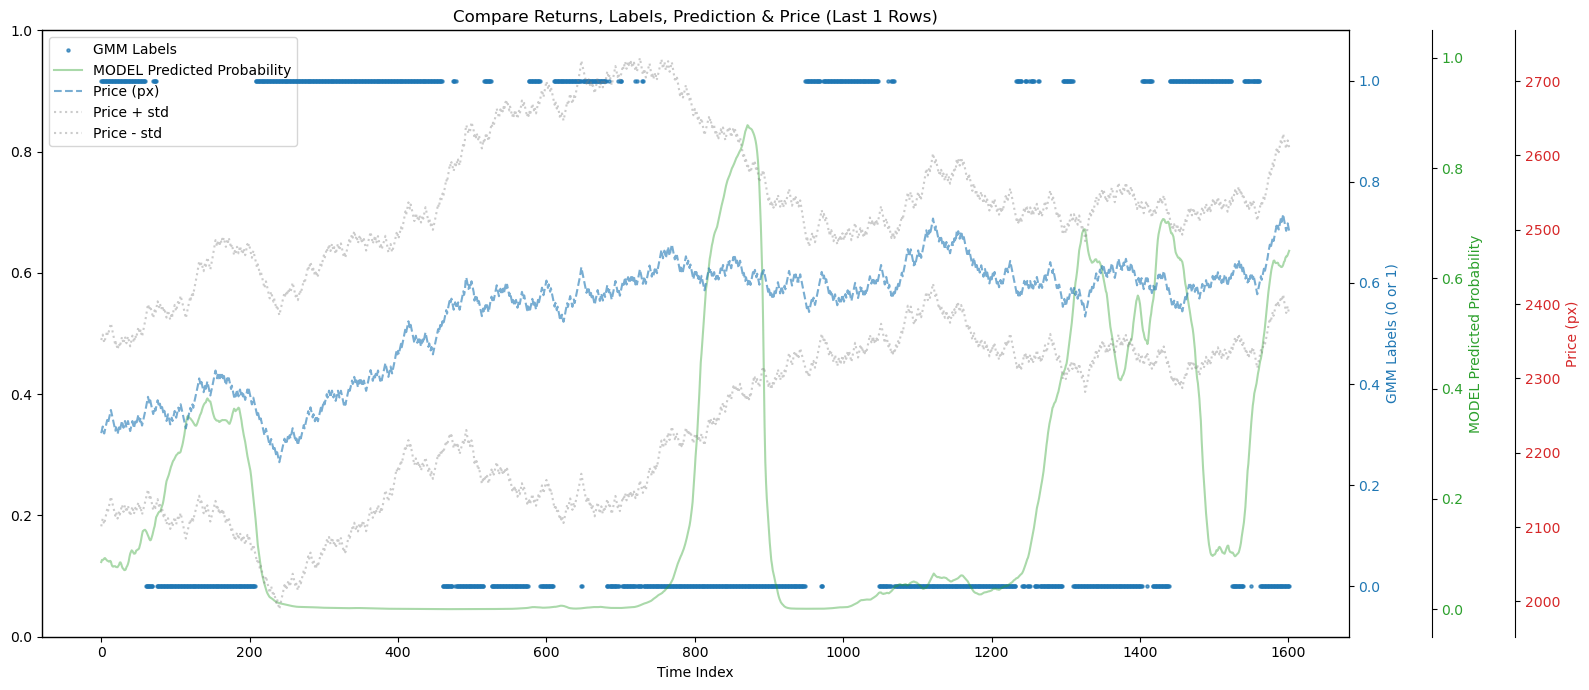

Test Week 10 Evaluation Completed
Fold 8: Train 8~10, Val 11, Test 12
Train: 2025-06-02 00:19:42.487000 to 2025-06-22 23:50:14.167000
Val: 2025-06-23 00:01:33.194000 to 2025-06-29 23:46:28.177000
Test: 2025-06-30 00:00:07.640000 to 2025-07-06 23:43:54.597000
GMM 分量均值: [-0.01846349  0.01036621]
上涨标签: 1, 下跌标签: 0

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: -0.018463) => 二元标签: 0
GMM 内部标签 1 (均值: 0.010366) => 二元标签: 1

--- 示例标签 ---
训练集原始收益: [0.0041259  0.00413421 0.00414569 0.00821725 0.00409048 0.0040275
 0.00399943 0.00399529 0.00802637 0.01216559]
训练集GMM标签: [1 1 1 1 1 1 1 1 1 1]
训练集二元标签: [1 1 1 1 1 1 1 1 1 1]

测试集原始收益: [-0.00632502 -0.00222865 -0.00624513 -0.01036404 -0.01044177 -0.00633554
 -0.01033129 -0.01038388 -0.01435156 -0.0143542 ]
测试集GMM标签: [1 1 1 0 0 1 0 0 0 0]
测试集二元标签: [1 1 1 0 0 1 0 0 0 0]
[0.80165174 0.80165174 0.80165174 ... 0.80165174 0.80165174 0.80165174]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00193 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 10 | loss: 0.20067 | val_0_balanced_accuracy: 0.5     |  0:00:06s
epoch 20 | loss: 0.13961 | val_0_balanced_accuracy: 0.5     |  0:00:12s
epoch 30 | loss: 0.10582 | val_0_balanced_accuracy: 0.5     |  0:00:18s
epoch 40 | loss: 0.10618 | val_0_balanced_accuracy: 0.5     |  0:00:25s
epoch 50 | loss: 0.09082 | val_0_balanced_accuracy: 0.48762 |  0:00:30s
epoch 60 | loss: 0.10118 | val_0_balanced_accuracy: 0.51452 |  0:00:37s
epoch 70 | loss: 0.09849 | val_0_balanced_accuracy: 0.5     |  0:00:43s
epoch 80 | loss: 0.09099 | val_0_balanced_accuracy: 0.50098 |  0:00:48s
epoch 90 | loss: 0.08617 | val_0_balanced_accuracy: 0.5245  |  0:00:54s
epoch 100| loss: 0.0919  | val_0_balanced_accuracy: 0.57071 |  0:01:00s
epoch 110| loss: 0.0933  | val_0_balanced_accuracy: 0.49793 |  0:01:04s
epoch 120| loss: 0.08156 | val_0_balanced_accuracy: 0.5734  |  0:01:09s
epoch 130| loss: 0.07963 | val_0_balanced_accuracy: 0.5647  |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.7157
✅ 自信预测准确率: 0.8009 (阈值 0.2-0.8)
📈 出手率: 54.49%

🧮 自信预测混淆矩阵:
[[ 53  70]
 [104 647]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.34      0.43      0.38       123
           1       0.90      0.86      0.88       751

    accuracy                           0.80       874
   macro avg       0.62      0.65      0.63       874
weighted avg       0.82      0.80      0.81       874


=== tabnet 评估结果 ===
📊 全样本准确率: 0.4969
✅ 自信预测准确率: 0.6280 (阈值 0.2-0.8)
📈 出手率: 46.73%

🧮 自信预测混淆矩阵:
[[ 25 133]
 [ 37 262]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.40      0.16      0.23       158
           1       0.66      0.88      0.76       299

    accuracy                           0.63       457
   macro avg       0.53      0.52      0.49       457
weighted avg       0.57      0.63      0.57       457



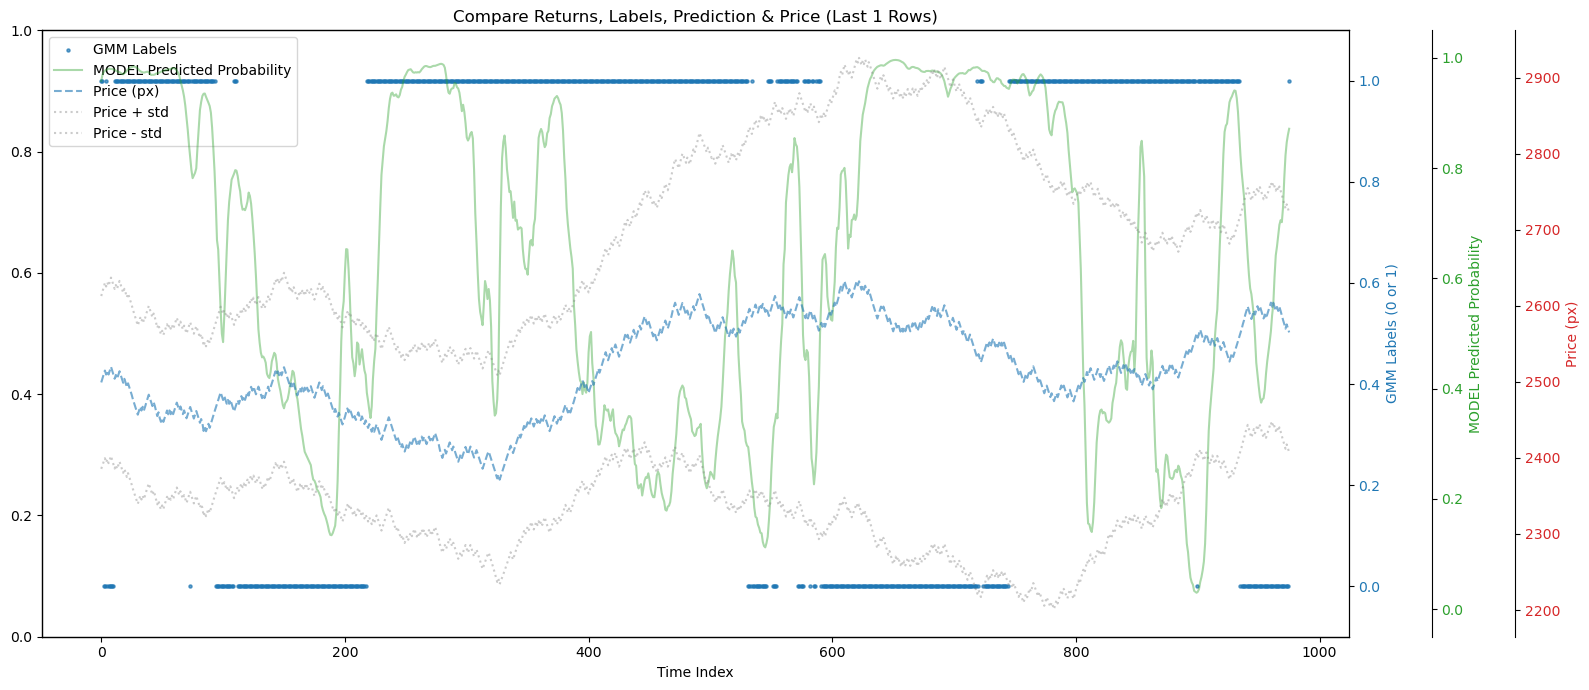

epoch 0  | loss: 0.61358 | val_0_balanced_accuracy: 0.50369 |  0:00:00s
epoch 10 | loss: 0.13847 | val_0_balanced_accuracy: 0.55617 |  0:00:05s

Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.57253


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.4738
✅ 自信预测准确率: 0.3487 (阈值 0.2-0.8)
📈 出手率: 73.13%

🧮 自信预测混淆矩阵:
[[222  40]
 [724 187]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.23      0.85      0.37       262
           1       0.82      0.21      0.33       911

    accuracy                           0.35      1173
   macro avg       0.53      0.53      0.35      1173
weighted avg       0.69      0.35      0.34      1173


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.4489
✅ 自信预测准确率: 0.2679 (阈值 0.2-0.8)
📈 出手率: 50.00%

🧮 自信预测混淆矩阵:
[[ 84 129]
 [229  47]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.27      0.39      0.32       213
           1       0.27      0.17      0.21       276

    accuracy                           0.27       489
   macro avg       0.27      0.28      0.26       489
weighted avg       0.27      0.27      0.26       489



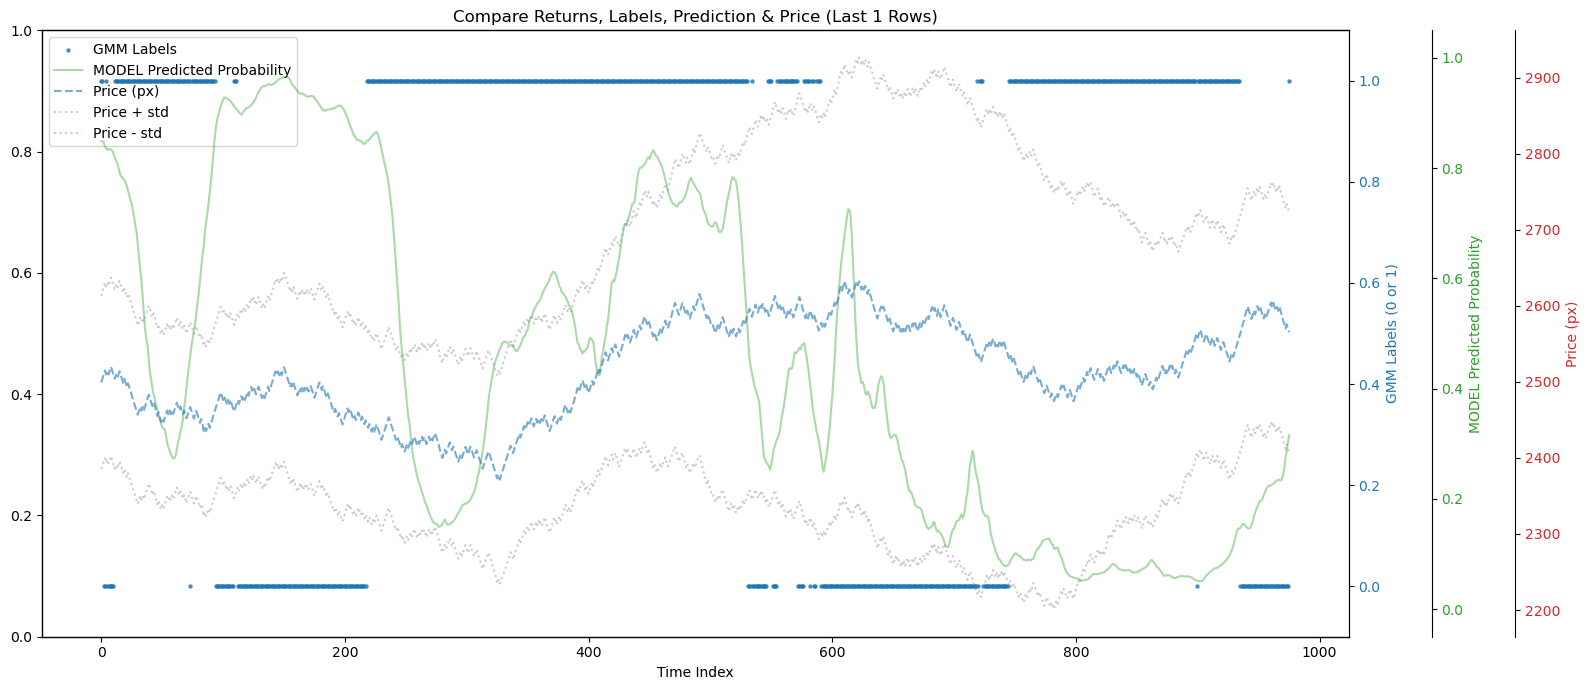

Test Week 11 Evaluation Completed
Fold 9: Train 9~11, Val 12, Test 13
Train: 2025-06-09 00:07:33.575000 to 2025-06-29 23:46:28.177000
Val: 2025-06-30 00:00:07.640000 to 2025-07-06 23:43:54.597000
Test: 2025-07-07 00:22:07.181000 to 2025-07-11 09:56:31.926000
GMM 分量均值: [-0.0135231   0.01392266]
上涨标签: 1, 下跌标签: 0

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: -0.013523) => 二元标签: 0
GMM 内部标签 1 (均值: 0.013923) => 二元标签: 1

--- 示例标签 ---
训练集原始收益: [0.0355201  0.03551678 0.03969094 0.04004704 0.04004394 0.04434988
 0.04436099 0.04859029 0.048567   0.04860669]
训练集GMM标签: [1 1 1 1 1 1 1 1 1 1]
训练集二元标签: [1 1 1 1 1 1 1 1 1 1]

测试集原始收益: [-0.00565133 -0.00560131 -0.00556963 -0.00956495 -0.00956887 -0.01358643
 -0.01810211 -0.01819563 -0.01818958 -0.02218141]
测试集GMM标签: [0 0 0 0 0 0 0 0 0 0]
测试集二元标签: [0 0 0 0 0 0 0 0 0 0]
[1.04843206 1.04843206 1.04843206 ... 0.95584498 0.95584498 0.95584498]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.97815 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 10 | loss: 0.2256  | val_0_balanced_accuracy: 0.5     |  0:00:04s
epoch 20 | loss: 0.16904 | val_0_balanced_accuracy: 0.58972 |  0:00:08s
epoch 30 | loss: 0.13103 | val_0_balanced_accuracy: 0.5     |  0:00:13s
epoch 40 | loss: 0.1205  | val_0_balanced_accuracy: 0.5     |  0:00:17s
epoch 50 | loss: 0.11287 | val_0_balanced_accuracy: 0.51778 |  0:00:21s
epoch 60 | loss: 0.08943 | val_0_balanced_accuracy: 0.51464 |  0:00:25s

Early stopping occurred at epoch 68 with best_epoch = 18 and best_val_0_balanced_accuracy = 0.60436


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.6104
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!

=== tabnet 评估结果 ===
📊 全样本准确率: 0.8423
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


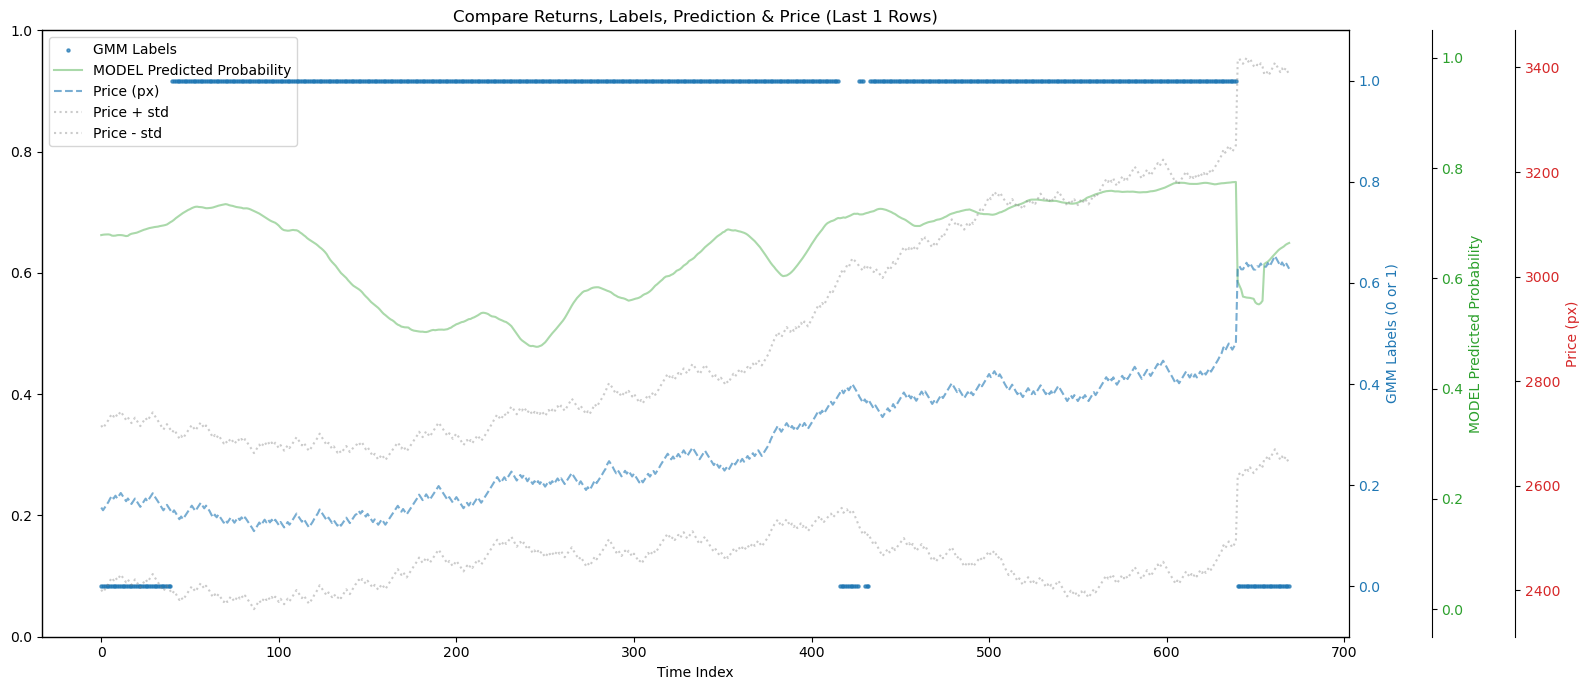

epoch 0  | loss: 0.44821 | val_0_balanced_accuracy: 0.38664 |  0:00:00s
epoch 10 | loss: 0.14159 | val_0_balanced_accuracy: 0.50003 |  0:00:04s
epoch 20 | loss: 0.10198 | val_0_balanced_accuracy: 0.50192 |  0:00:09s

Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_balanced_accuracy = 0.55031


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5450
✅ 自信预测准确率: 0.4906 (阈值 0.2-0.8)
📈 出手率: 49.18%

🧮 自信预测混淆矩阵:
[[190  35]
 [210  46]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.47      0.84      0.61       225
           1       0.57      0.18      0.27       256

    accuracy                           0.49       481
   macro avg       0.52      0.51      0.44       481
weighted avg       0.52      0.49      0.43       481


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.3036
✅ 自信预测准确率: 0.0423 (阈值 0.2-0.8)
📈 出手率: 49.26%

🧮 自信预测混淆矩阵:
[[ 14  39]
 [278   0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.05      0.26      0.08        53
           1       0.00      0.00      0.00       278

    accuracy                           0.04       331
   macro avg       0.02      0.13      0.04       331
weighted avg       0.01      0.04      0.01       331



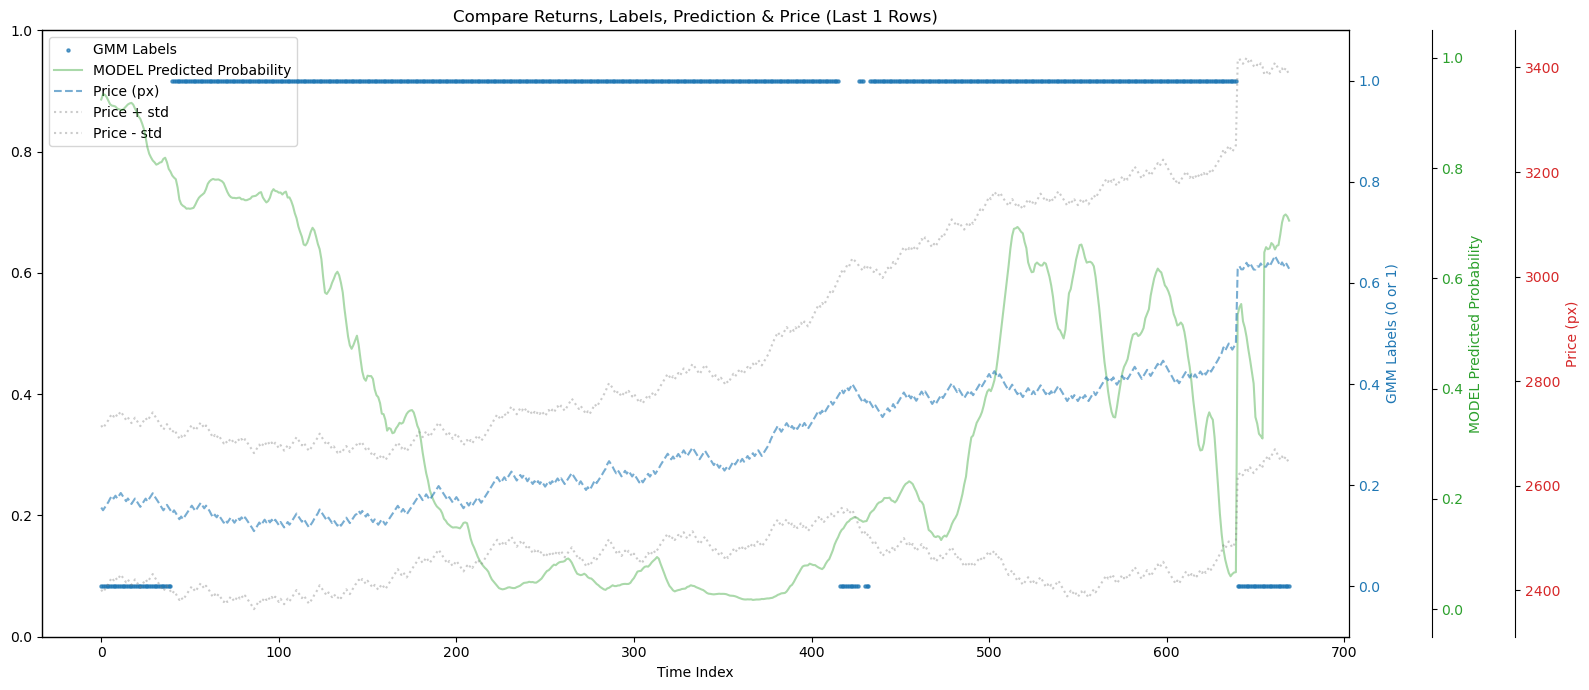

Test Week 12 Evaluation Completed

--- Final Predictions DataFrame for Backtesting ---
       timestamp   symbol  true_label  predicted_prob       px  rolling_std
0  1746403993815  BTCUSDT           1        0.515195  1811.61    15.320063
1  1746404934654  BTCUSDT           1        0.516692  1815.26    15.255311
2  1746407176678  BTCUSDT           1        0.517946  1811.38    15.177577
3  1746407938227  BTCUSDT           1        0.517458  1807.75    15.130294
4  1746408487452  BTCUSDT           1        0.516603  1804.07    15.077517
Total rows collected: 19994
整体训练时间范围：2025-04-07 15:31:03.701000 到 2025-07-11 09:56:31.926000


In [14]:
n_train_weeks = 3 # 可配置
n_val_weeks = 1    # 一般 1 周验证
n_test_weeks = 1   # 后 1 周做 test

exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
target_col = f"future_return_{step}"
feature_cols = [
    col for col in origin_df.columns
    if col.endswith("_scaled") 
        # and (col.startswith("z_")) 
        and all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "px"
]
# print(feature_cols)

# feature_cols = ["z_oi_di"]
results = []
all_tab_inc_test_predictions = []
all_tabnet_test_predictions = []
all_lgb_test_predictions = []

lgb_model = None
tab_inc = None
tab_inc_flag = 0

overall_start = None
overall_end = None


for i in range(len(weekly_dataframes) - n_train_weeks - n_val_weeks - n_test_weeks + 1):
    train_dfs = weekly_dataframes[i : i + n_train_weeks]
    val_dfs = weekly_dataframes[i + n_train_weeks : i + n_train_weeks + n_val_weeks]
    test_dfs = weekly_dataframes[i + n_train_weeks + n_val_weeks : i + n_train_weeks + n_val_weeks + n_test_weeks]
    
    train_df = pl.concat(train_dfs)
    val_df = pl.concat(val_dfs)
    test_df = pl.concat(test_dfs)

    print("=" * 60)
    print(f"Fold {i}: Train {i}~{i+n_train_weeks-1}, Val {i+n_train_weeks}, Test {i+n_train_weeks+1}")
    print("Train:", train_df['timestamp_dt'][0], "to", train_df['timestamp_dt'][-1])
    print("Val:", val_df['timestamp_dt'][0], "to", val_df['timestamp_dt'][-1])
    print("Test:", test_df['timestamp_dt'][0], "to", test_df['timestamp_dt'][-1])

    fold_start = train_df['timestamp_dt'][0]
    fold_end = test_df['timestamp_dt'][-1]

    # 更新 overall_start 和 overall_end
    if overall_start is None or fold_start < overall_start:
        overall_start = fold_start
    if overall_end is None or fold_end > overall_end:
        overall_end = fold_end
        
    # 处理 train
    train_df_processed = train_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_train = train_df_processed[feature_cols]
    y_train = train_df_processed[target_col]
    px_train = train_df_processed['px']
    std_train =train_df_processed['rolling_std']
    
    # 处理 val
    val_df_processed = val_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_val = val_df_processed[feature_cols]
    y_val = val_df_processed[target_col]
    px_val = val_df_processed['px']
    std_val =val_df_processed['rolling_std']
    timestamps_val = val_df_processed['timestamp'] # 收集时间戳

    # 处理 test
    test_df_processed = test_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_test = test_df_processed[feature_cols]
    y_test = test_df_processed[target_col]
    px_test = test_df_processed['px']
    std_test =test_df_processed['rolling_std']
    timestamps_test = test_df_processed['timestamp'] # 收集时间戳

    y_train, y_val, y_test, gmm_model = gmm_label_binarize(y_train, y_val, y_test, verbose=True)


    # modellllllll
    up_thresh = 0.2
    lower_thresh = 0.8

    # sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    # # # #LGBM
    # lgb_model = lgb.LGBMClassifier(n_estimators=2000, learning_rate=0.005, max_depth=7, verbose=-1)
    # early_stopping_callback = lgb.early_stopping(
    #     stopping_rounds=500,  # 耐心值：如果验证集性能在连续100轮内没有提升，就停止训练
    #     verbose=True,          # 打印早停信息，例如在第多少轮停止，最佳分数是多少
    # )
    # lgb_model.fit(
    #     X_train, y_train,
    #     sample_weight=sample_weights,  # ✅ 添加 sample_weight
    #     eval_set=[(X_val, y_val)],
    #     eval_metric='acc',
    #     # callbacks=[early_stopping_callback], # 将早停回调传入 callbacks 参数
    # )
    
    # lgb_eval = evaluate_with_confidence(
    #     y_true=y_val,
    #     y_pred_proba=lgb_model.predict_proba(X_val)[:, 1],
    #     model_name="lgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # # plot_last_n_rows_with_px(y_val, y_val, lgb_model.predict_proba(X_val)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
    # lgb_eval = evaluate_with_confidence(
    #     y_true=y_test,
    #     y_pred_proba=lgb_model.predict_proba(X_test)[:, 1],
    #     model_name="lgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(lgb_model.predict_proba(X_test)[:, 1], y_test, lgb_model.predict_proba(X_test)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)
    # lgb_test_pred_probs = lgb_model.predict_proba(X_test)[:, 1]

    # current_window_results = pd.DataFrame({
    #     'timestamp': timestamps_test,
    #     'symbol': "BTCUSDT", # 如果有多个股票，收集 symbol 是必要的
    #     'true_label': y_test,
    #     'predicted_prob': lgb_test_pred_probs,
    #     'px': px_test, # 收集价格，回测时需要
    #     'rolling_std': std_test # 收集波动率，可能用于策略或分析
    #     # 添加任何你回测需要的其他数据
    # })
    # all_lgb_test_predictions.append(current_window_results)

    # # CAT
    # cat_model = CatBoostClassifier(iterations=2000, learning_rate=0.005, depth=9, verbose=0)
    # cat_model.fit(
    #     X_train, y_train_bin,
    # )

    # cat_eval = evaluate_with_confidence(
    #     y_true=y_val_bin,
    #     y_pred_proba=cat_model.predict_proba(X_val)[:, 1],
    #     model_name="cat_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val_bin, cat_model.predict_proba(X_val)[:, 1], px_val, n=6199)
    
    # cat_eval = evaluate_with_confidence(
    #     y_true=y_test_bin,
    #     y_pred_proba=cat_model.predict_proba(X_test)[:, 1],
    #     model_name="cat_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_test, y_test_bin, cat_model.predict_proba(X_test)[:, 1], px_test, n=6199)

    # # XGB
    # xgb_model = xgb.XGBClassifier(n_estimators=2000, learning_rate=0.005, max_depth=9, verbosity=0, use_label_encoder=False)
    # xgb_model.fit(
    #     X_train, y_train,
    # )

    # xgb_eval = evaluate_with_confidence(
    #     y_true=y_val,
    #     y_pred_proba=xgb_model.predict_proba(X_val)[:, 1],
    #     model_name="xgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val, xgb_model.predict_proba(X_val)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    

    # xgb_eval = evaluate_with_confidence(
    #     y_true=y_test,
    #     y_pred_proba=xgb_model.predict_proba(X_test)[:, 1],
    #     model_name="xgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_test, y_test, xgb_model.predict_proba(X_test)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    params = {
        # 模型结构参数
        "n_d": 16,                      # 决策输出维度
        "n_a": 16,                      # 注意力机制维度
        "n_steps": 3,                  # 决策步数
        "gamma": 1.3,                  # 控制特征复用的程度（>1）
        "n_independent": 3,           # 每个 step 的独立 Feature Transformer 层数
        "n_shared": 2,                # 每个 step 的共享 Feature Transformer 层数
    
        # 分类特征嵌入（如果你用的都是 float 特征，可以全留空）
        "cat_idxs": [],               # 类别特征的列索引
        "cat_dims": [],               # 每个类别特征的类别数
        "cat_emb_dim": 1,             # 类别特征的嵌入维度（或 list）
    
        # 正则化与数值稳定性
        "lambda_sparse": 1e-4,        # 稀疏正则
        "epsilon": 1e-15,             # sparsemax 稳定项
        "momentum": 0.03,             # BatchNorm 的动量
        "clip_value": 3.0,            # 梯度裁剪
        
        # 注意力 mask 类型
        "mask_type": "entmax",     # sparsemax 或 entmax
    
        # 优化器设置（函数和参数）
        # "optimizer_fn": torch.optim.Adam,    
        "optimizer_params": {"lr": 1e-2},
    
        # 学习率调度器（可选）
        "scheduler_fn": None,         # torch.optim.lr_scheduler.StepLR 等
        "scheduler_params": {},       # 比如 {"step_size": 20, "gamma": 0.95}
    
        # 预训练解码器结构（一般用不到）
        "n_shared_decoder": 1,
        "n_indep_decoder": 1,
    
        # 训练环境和调试
        "seed": 7,
        "verbose": 10,
        "device_name": "cuda",        # auto / cpu / cuda
    }

    init_fit_params = {
        "eval_metric": ['balanced_accuracy'],
        "max_epochs": 300,
        "patience": 50,
        "batch_size": 1024,
        "virtual_batch_size": 256,
    }

    inc_fit_params = {
        "eval_metric": ['balanced_accuracy'],
        "max_epochs": 50,
        "patience": 10,
        "batch_size": 1024,
        "virtual_batch_size": 256,
        "warm_start": True,
    }

    # Label Encode y（如果是0/1就不用）
    y_train_enc = y_train.astype(int)
    y_val_enc = y_val.astype(int)
    
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_enc)
    print(sample_weights)
    # TabNet 训练
    tabnet = TabNetClassifier(**params)
    tabnet.fit(
        X_train=X_train.values, y_train=y_train_enc,
        eval_set=[(X_val.values, y_val_enc)],
        weights=sample_weights,
        **init_fit_params,
    )

    # proba_smooth = softmax_with_temperature(proba_raw, temperature=1.5)
    
    tabnet_eval = evaluate_with_confidence(
        y_true=y_val,
        y_pred_proba=tabnet.predict_proba(X_val.values)[:, 1],
        model_name="tabnet",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )
    # plot_last_n_rows_with_px(y_val, y_val, tabnet.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)


    tabnet_eval = evaluate_with_confidence(
        y_true=y_test,
        y_pred_proba=tabnet.predict_proba(X_test.values)[:, 1],
        model_name="tabnet",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )

    plot_last_n_rows_with_px(y_test, y_test, tabnet.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    current_window_results = pd.DataFrame({
        'timestamp': timestamps_test,
        'symbol': "BTCUSDT", # 如果有多个股票，收集 symbol 是必要的
        'true_label': y_test,
        'predicted_prob': tabnet.predict_proba(X_test.values)[:, 1],
        'px': px_test, # 收集价格，回测时需要
        'rolling_std': std_test # 收集波动率，可能用于策略或分析
        # 添加任何你回测需要的其他数据
    })
    all_tabnet_test_predictions.append(current_window_results)

    # TabNet_incremental 训练
    if tab_inc_flag == 0:
        tab_inc_flag = 1
        tab_inc = TabNetClassifier(**params)
        tab_inc.fit(
            X_train=X_train.values, y_train=y_train_enc,
            eval_set=[(X_val.values, y_val_enc)],
            weights=sample_weights,
            **init_fit_params,
        )

        tabnet_eval = evaluate_with_confidence(
            y_true=y_val,
            y_pred_proba=tab_inc.predict_proba(X_val.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        # plot_last_n_rows_with_px(y_val, y_val, tab_inc.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
        # proba_smooth = softmax_with_temperature(proba_raw, temperature=1.5)
        tabnet_eval = evaluate_with_confidence(
            y_true=y_test,
            y_pred_proba=tab_inc.predict_proba(X_test.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_test, y_test, tab_inc.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)
        

    else:
        tab_inc.fit(
            X_train=X_train.values, y_train=y_train_enc,
            eval_set=[(X_val.values, y_val_enc)],
            weights=sample_weights,
            **inc_fit_params,
        )

        
        tabnet_eval = evaluate_with_confidence(
            y_true=y_val,
            y_pred_proba=tab_inc.predict_proba(X_val.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        # plot_last_n_rows_with_px(y_val, y_val, tab_inc.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
        tabnet_eval = evaluate_with_confidence(
            y_true=y_test,
            y_pred_proba=tab_inc.predict_proba(X_test.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_test, y_test, tab_inc.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    current_window_results = pd.DataFrame({
        'timestamp': timestamps_test,
        'symbol': "BTCUSDT", # 如果有多个股票，收集 symbol 是必要的
        'true_label': y_test,
        'predicted_prob': tab_inc.predict_proba(X_test.values)[:, 1],
        'px': px_test, # 收集价格，回测时需要
        'rolling_std': std_test # 收集波动率，可能用于策略或分析
        # 添加任何你回测需要的其他数据
    })
    all_tab_inc_test_predictions.append(current_window_results)

    week_results = {
        'train_period': f"{train_df['timestamp_dt'][0]} to {train_df['timestamp_dt'][-1]}",
        'test_period': f"{test_df['timestamp_dt'][0]} to {test_df['timestamp_dt'][-1]}",
        # 'LGBM': lgb_eval,
        # 'CatBoost': cat_model,
        # 'XGBoost': xgb_eval,
        'TabNet': tabnet_eval,
    }
    
    results.append(week_results)
    print(f"Test Week {i+n_train_weeks} Evaluation Completed")
 
final_predictions_df = pd.concat(all_tab_inc_test_predictions).sort_values('timestamp').reset_index(drop=True)

print("\n--- Final Predictions DataFrame for Backtesting ---")
print(final_predictions_df.head())
print(f"Total rows collected: {len(final_predictions_df)}") 
print(f"整体训练时间范围：{overall_start} 到 {overall_end}")
overall_start = str(overall_start)
overall_end = str(overall_end)

In [15]:
print(tab_inc.classes_)  # 输出通常是 array([0, 1])


[0 1]


In [16]:
# import pickle

# pkl_path = "./saved_models/tabnet_inc/model_2025-06-22_19-51/auxiliary.pkl"

# with open(pkl_path, "rb") as f:
#     data = pickle.load(f)

# print(data)


In [17]:
print(len(X_test.columns))

4104


In [18]:
explain_matrix, masks = tab_inc.explain(X_test.values)


Top 20 Features by Importance:

z_oi_down_divergence_volatility_250_zd_scaled Importance: 0.321004
z_px_pct_rol_sum_10_diff_5_zd_scaled     Importance: 0.215088
z_bs_ratio_rol_mean_500_minus_z_oi_down_divergence_long_term_zd_scaled Importance: 0.161512
z_oi_down_divergence_short_term_scaled   Importance: 0.152313
z_sum_sz_rol_mean_500_minus_z_oi_down_divergence_long_term_zd_scaled Importance: 0.146170
z_px_pct_rol_sum_80_diff_5_zd_scaled     Importance: 0.132962
z_ts_velo_rol_mean_500_minus_z_factor_px_oi_force_zd_scaled Importance: 0.123650
z_px_pct_rol_sum_10_minus_z_factor_oi_momentum_long_term_punch_zd_scaled Importance: 0.122871
z_ask_px_gap_rol_mean_500_minus_z_lob_ratio_rol_mean_500_scaled Importance: 0.122130
z_px_pct_rol_sum_80_minus_z_factor_oi_momentum_punch_zd_scaled Importance: 0.113690
z_px_pct_rol_sum_20_lag_5_scaled         Importance: 0.103906
z_factor_oi_momentum_punch_diff_5_zd_scaled Importance: 0.095791
z_lob_ratio_rol_mean_500_second_order_diff_10_zd_scaled Import

C:\Users\Grayman\AppData\Local\Temp\ipykernel_16896\2508309008.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


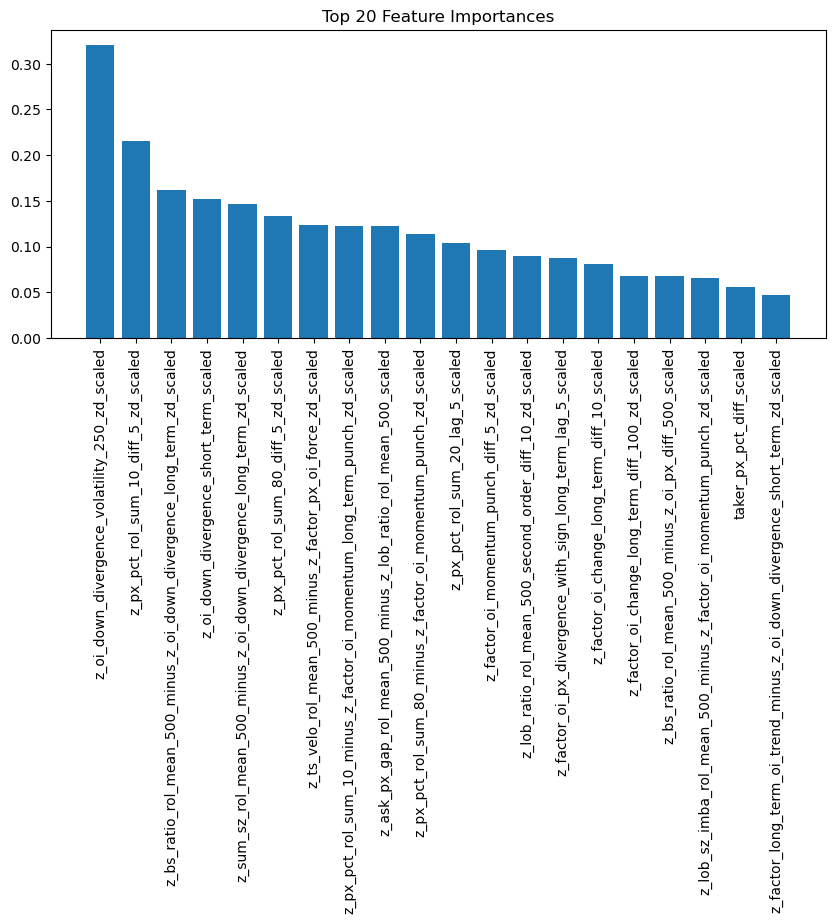

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 explain_matrix 是 TabNetClassifier 的解释矩阵 (n_samples, n_features)
mean_importance = np.mean(np.abs(explain_matrix), axis=0)
top_n = 20
top_indices = np.argsort(mean_importance)[::-1][:top_n]

# 特征名
top_feature_names = [X_train.columns[i] for i in top_indices]
top_importance_values = mean_importance[top_indices]

# 打印 Top N 特征名 + 权重
print(f"Top {top_n} Features by Importance:\n")
for name, score in zip(top_feature_names, top_importance_values):
    print(f"{name:<40} Importance: {score:.6f}")

# 画图
plt.figure(figsize=(10, 4))
plt.bar(range(top_n), top_importance_values)
plt.xticks(range(top_n), top_feature_names, rotation=90)
plt.title(f"Top {top_n} Feature Importances")
plt.tight_layout()
plt.show()


In [20]:
import numpy as np

mask_sample = masks[0][0]  # 第0步，第0个样本的mask
nonzero_indices = np.nonzero(mask_sample)[0]  # 找非零位置索引

print("被关注的特征索引:", nonzero_indices)
print("对应的权重:", mask_sample[nonzero_indices])

# 假设你的特征名列表是 feature_names（长度460）
for idx in nonzero_indices:
    print(f"特征: {X_train.columns[idx]}, 权重: {mask_sample[idx]:.4f}")


被关注的特征索引: [ 249  353  449  460  597  738  832  958  989 1016 1206 1348 1459 1492
 1501 1544 1634 1642 1917 2022 2210 2266 2358 2474 2575 2734 2802 2824
 2982 3039 3194 3354 3400 3444 3734 3749 3829 3849 4029]
对应的权重: [1.92121882e-02 5.51803550e-03 1.28539875e-02 2.07234244e-03
 1.20886890e-02 4.67813952e-05 1.22673362e-02 2.13682707e-02
 8.14559218e-03 1.34017039e-03 9.84390639e-03 3.52388178e-03
 1.34871132e-03 4.80605895e-03 7.84526616e-02 1.01385941e-03
 8.04315805e-02 2.47807917e-03 6.20792201e-03 3.18494835e-03
 8.02232325e-03 2.93063902e-04 1.04309872e-01 9.65011772e-03
 6.10944368e-02 5.16820606e-03 4.27143797e-02 2.81928405e-02
 1.19835529e-02 4.35374823e-05 1.12442859e-03 5.98314544e-03
 2.14752611e-02 1.05069266e-04 2.44140208e-01 1.60478111e-02
 1.43100908e-02 1.00867189e-01 3.82684916e-02]
特征: z_px_pct_rol_sum_10_lag_200_scaled, 权重: 0.0192
特征: z_ts_velo_rol_mean_500_volatility_250_scaled, 权重: 0.0055
特征: z_bs_imba_rol_mean_500_lag_200_scaled, 权重: 0.0129
特征: z_sum_sz_rol_mean_

In [21]:
import numpy as np
import pandas as pd

def show_tabnet_attention_masks(masks, feature_names, sample_idx=0, top_k=10):
    """
    显示 TabNet 对某个样本在每一步中关注的特征及其权重。

    参数:
    - masks: tabnet.explain(X)[1] 返回的字典
    - feature_names: list[str]，对应 X_train.columns
    - sample_idx: 选哪个样本
    - top_k: 最多展示前多少个非零特征
    """
    for step, mask_array in masks.items():
        mask_sample = mask_array[sample_idx]  # shape = (num_features,)
        nonzero_indices = np.nonzero(mask_sample)[0]
        weights = mask_sample[nonzero_indices]
        
        # 按照权重从高到低排序
        sorted_idx = np.argsort(-weights)
        top_indices = nonzero_indices[sorted_idx[:top_k]]
        
        print(f"\n🧭 Step {step}（共{len(nonzero_indices)}个非零特征）:")
        for i in top_indices:
            print(f"  特征: {feature_names[i]:<30} 权重: {mask_sample[i]:.4f}")


In [22]:
# 假设你已经有
# masks = tabnet.explain(X_test)[1]
# feature_names = list(X_test.columns)

show_tabnet_attention_masks(masks, X_train.columns, sample_idx=0, top_k=20)



🧭 Step 0（共39个非零特征）:
  特征: z_sum_sz_rol_mean_500_minus_z_oi_down_divergence_long_term_zd_scaled 权重: 0.2441
  特征: z_px_pct_rol_sum_80_diff_20_zd_scaled 权重: 0.1043
  特征: z_lob_sz_imba_rol_mean_500_minus_z_factor_oi_momentum_punch_zd_scaled 权重: 0.1009
  特征: z_lob_ratio_rol_mean_500_minus_z_factor_impact_sensitivity_scaled 权重: 0.0804
  特征: z_px_pct_rol_sum_500_minus_z_oi_up_divergence_short_term_scaled 权重: 0.0785
  特征: z_px_velo_rol_mean_500_diff_10_zd_scaled 权重: 0.0611
  特征: z_factor_oi_px_divergence_with_sign_second_order_diff_50_zd_scaled 权重: 0.0427
  特征: z_factor_oi_px_divergence_with_sign_long_term_minus_z_factor_oi_trend_slope_zd_scaled 权重: 0.0383
  特征: z_factor_oi_px_divergence_with_sign_long_term_diff_100_zd_scaled 权重: 0.0282
  特征: z_px_pct_rol_sum_10_minus_z_factor_oi_momentum_long_term_punch_zd_scaled 权重: 0.0215
  特征: z_factor_order_sentiment_divergence_diff_10_scaled 权重: 0.0214
  特征: z_px_pct_rol_sum_10_lag_200_scaled 权重: 0.0192
  特征: z_sum_sz_rol_mean_500_minus_z_factor_momentu

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_heatmap(masks, feature_names, sample_idx=0):
    """
    可视化 TabNet attention mask 热力图。
    """
    steps = sorted(masks.keys())
    mask_matrix = np.vstack([masks[step][sample_idx] for step in steps])

    plt.figure(figsize=(min(20, len(feature_names) * 0.3), len(steps)))
    sns.heatmap(mask_matrix, cmap="viridis", xticklabels=feature_names, yticklabels=[f"Step {s}" for s in steps])
    plt.title(f"TabNet Attention Heatmap for Sample {sample_idx}")
    plt.xlabel("Feature")
    plt.ylabel("Decision Step")
    plt.tight_layout()
    plt.show()


In [24]:
# plot_attention_heatmap(masks, X_train.columns, sample_idx=0)



=== model 评估结果 ===
📊 全样本准确率: 0.5620
✅ 自信预测准确率: 0.5372 (阈值 0.05-0.95)
📈 出手率: 11.82%

🧮 自信预测混淆矩阵:
[[946 397]
 [697 324]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.58      0.70      0.63      1343
           1       0.45      0.32      0.37      1021

    accuracy                           0.54      2364
   macro avg       0.51      0.51      0.50      2364
weighted avg       0.52      0.54      0.52      2364



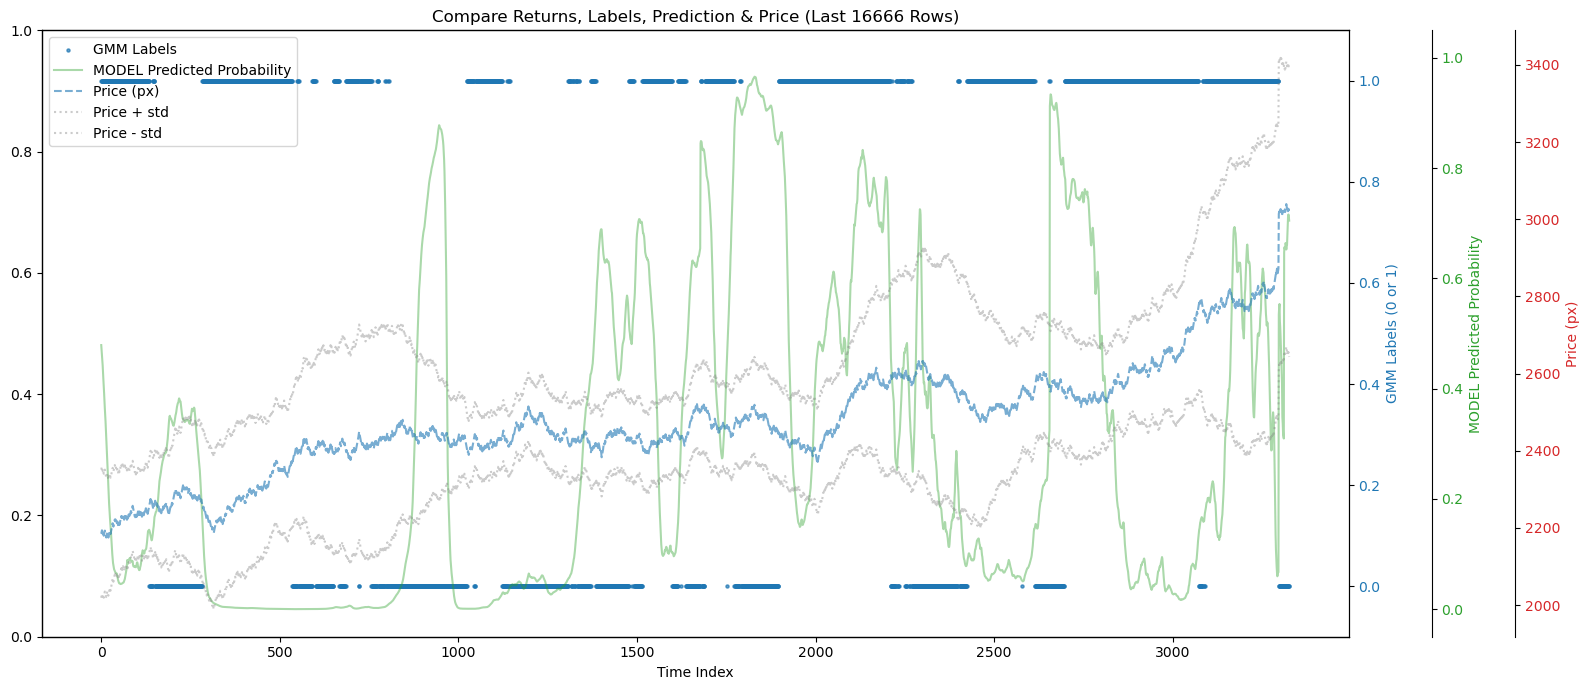

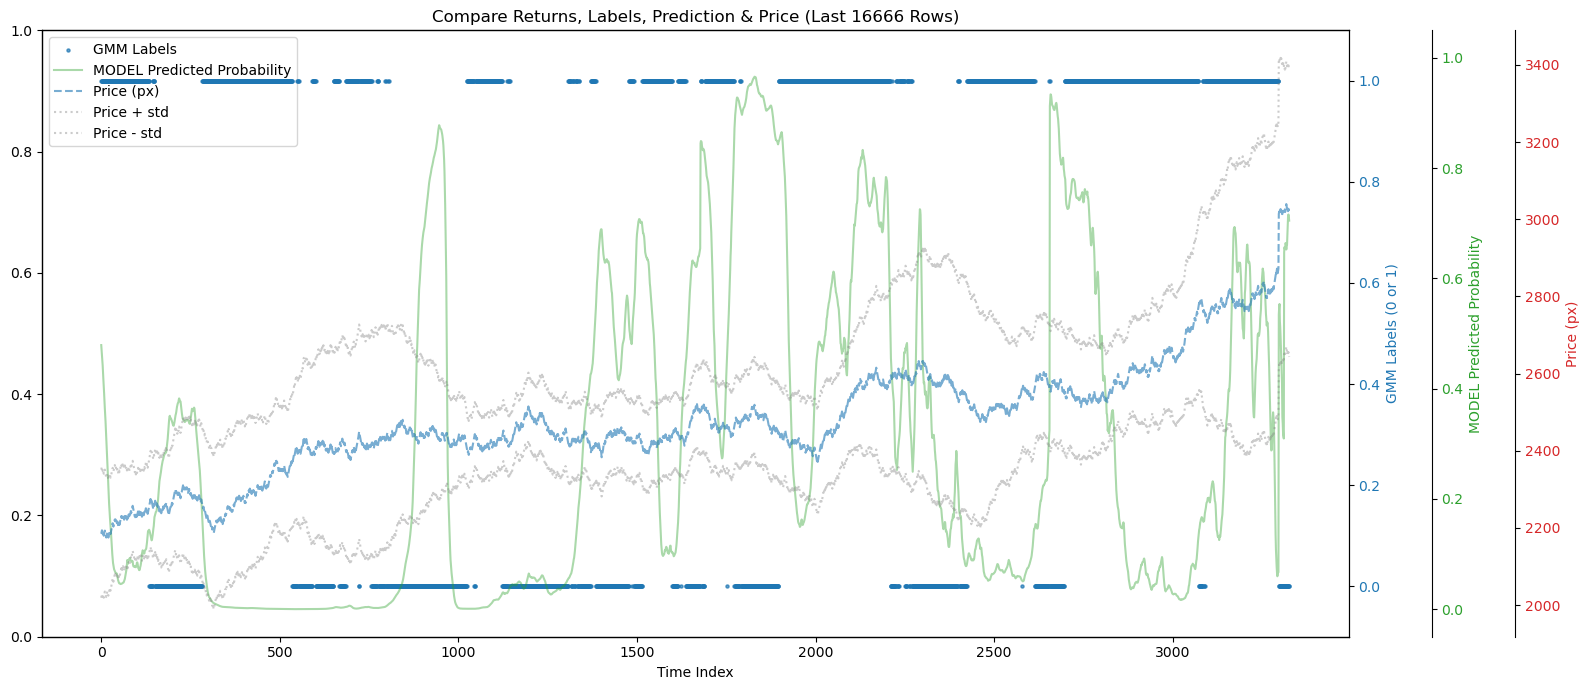

timestamp   symbol  true_label  predicted_prob       px  \
0      1746403993815  BTCUSDT           1        0.515195  1811.61   
1      1746404934654  BTCUSDT           1        0.516692  1815.26   
2      1746407176678  BTCUSDT           1        0.517946  1811.38   
3      1746407938227  BTCUSDT           1        0.517458  1807.75   
4      1746408487452  BTCUSDT           1        0.516603  1804.07   
...              ...      ...         ...             ...      ...   
19989  1752227123787  BTCUSDT           0        0.713412  3021.01   
19990  1752227200539  BTCUSDT           0        0.715997  3027.16   
19991  1752227617770  BTCUSDT           0        0.712183  3021.07   
19992  1752227775419  BTCUSDT           0        0.704787  3015.00   
19993  1752227791926  BTCUSDT           0        0.699380  3013.78   

       rolling_std  predicted_prob_rolling_mean  
0        15.320063                     0.515195  
1        15.255311                     0.516692  
2        15.177577                     0.517946  
3        15.130294                     0.517458  
4        15.077517                     0.516603  
...            ...                          ...  
19989    92.831758                     0.713412  
19990    92.901955                     0.715997  
19991    92.938633                     0.712183  
19992    92.938311                     0.704787  
19993    92.861193                     0.699380  

[19994 rows x 7 columns]

In [25]:
rolling_window_size = 1

final_predictions_df = pd.concat(all_tab_inc_test_predictions).sort_values('timestamp').reset_index(drop=True)

final_predictions_df['predicted_prob_rolling_mean'] = final_predictions_df['predicted_prob'].rolling(window=rolling_window_size, min_periods=1).mean()

tabnet_eval = evaluate_with_confidence(
    y_true=final_predictions_df["true_label"],
    y_pred_proba=final_predictions_df['predicted_prob_rolling_mean'],
    model_name="model",
    lower_thresh=0.05,
    upper_thresh=0.95,
    print_report=True,
)

plot_last_n_rows_with_px(
    final_predictions_df['predicted_prob_rolling_mean'], 
    final_predictions_df["true_label"],      
    final_predictions_df['predicted_prob_rolling_mean'], 
    final_predictions_df['px'],
    std_array=final_predictions_df['rolling_std'],
    n=16666,
    m=-1,
    alpha=alpha,
)
plot_last_n_rows_with_px(
    final_predictions_df['predicted_prob'], 
    final_predictions_df["true_label"], 
    final_predictions_df['predicted_prob'], 
    final_predictions_df['px'], 
    std_array=final_predictions_df['rolling_std'], 
    n=16666,
    m=-1, 
    alpha=alpha
)

final_predictions_df


=== model 评估结果 ===
📊 全样本准确率: 0.5625
✅ 自信预测准确率: 0.5768 (阈值 0.1-0.9)
📈 出手率: 23.66%

🧮 自信预测混淆矩阵:
[[1785  712]
 [1290  944]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.58      0.71      0.64      2497
           1       0.57      0.42      0.49      2234

    accuracy                           0.58      4731
   macro avg       0.58      0.57      0.56      4731
weighted avg       0.58      0.58      0.57      4731



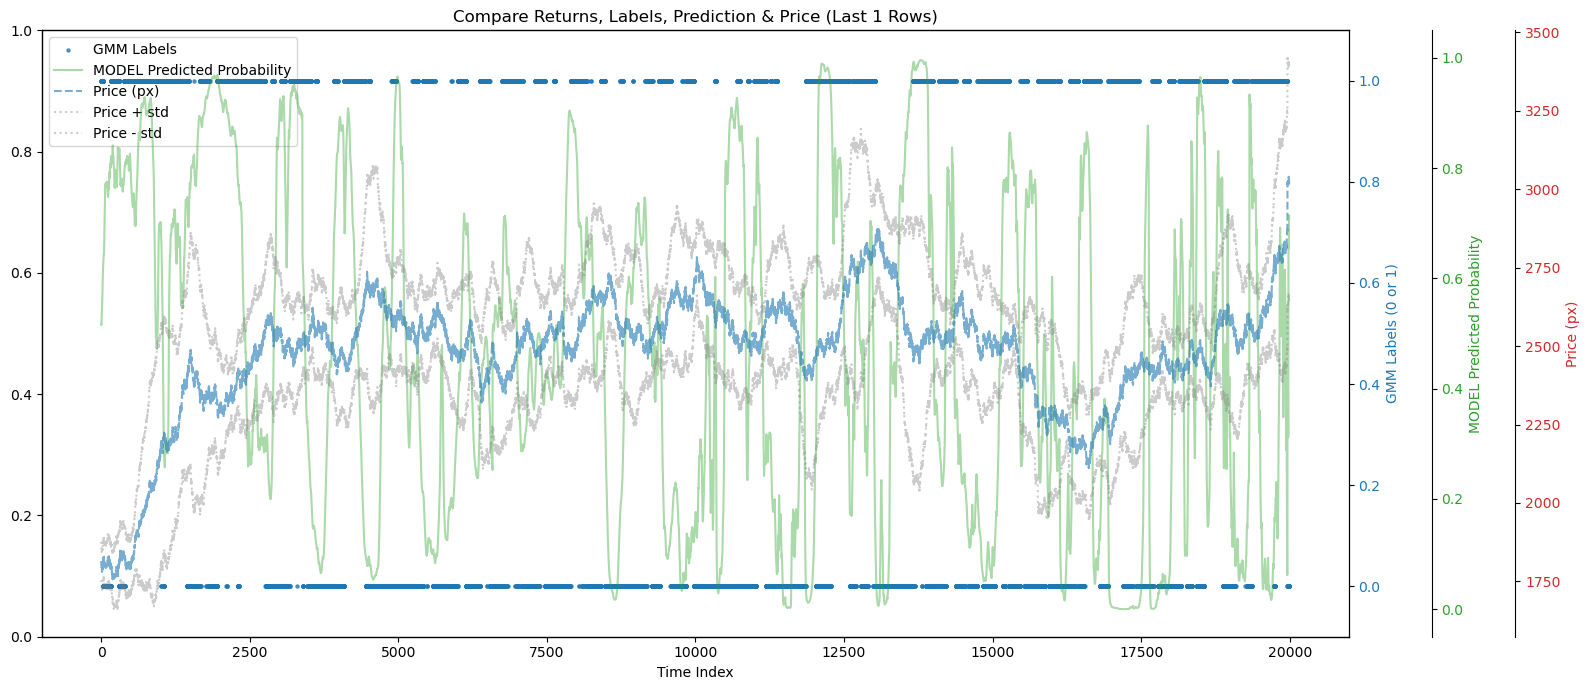

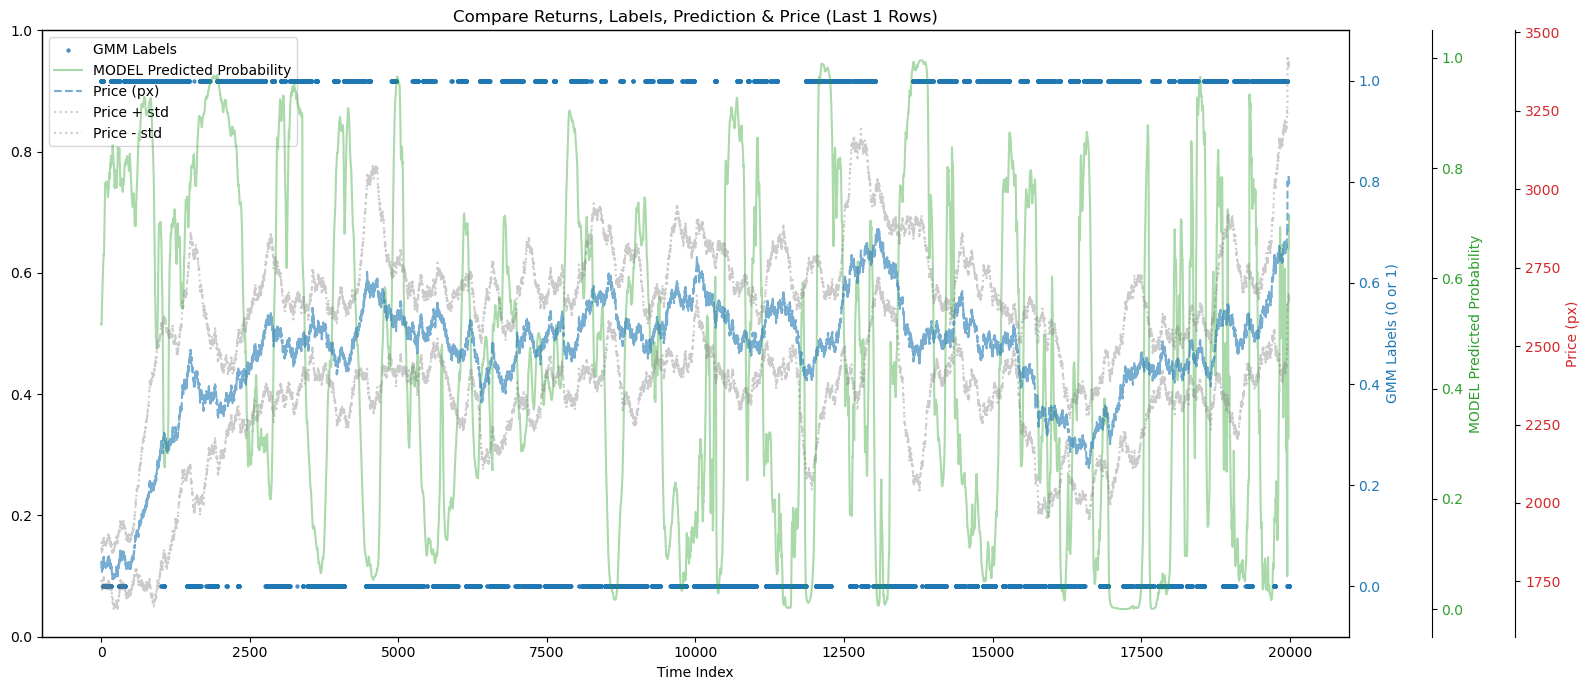

timestamp   symbol  true_label  predicted_prob       px  \
0      1746403993815  BTCUSDT           1        0.515195  1811.61   
1      1746404934654  BTCUSDT           1        0.516692  1815.26   
2      1746407176678  BTCUSDT           1        0.517946  1811.38   
3      1746407938227  BTCUSDT           1        0.517458  1807.75   
4      1746408487452  BTCUSDT           1        0.516603  1804.07   
...              ...      ...         ...             ...      ...   
19989  1752227123787  BTCUSDT           0        0.713412  3021.01   
19990  1752227200539  BTCUSDT           0        0.715997  3027.16   
19991  1752227617770  BTCUSDT           0        0.712183  3021.07   
19992  1752227775419  BTCUSDT           0        0.704787  3015.00   
19993  1752227791926  BTCUSDT           0        0.699380  3013.78   

       rolling_std  predicted_prob_rolling_mean  
0        15.320063                     0.515195  
1        15.255311                     0.515943  
2        15.177577                     0.517319  
3        15.130294                     0.517702  
4        15.077517                     0.517030  
...            ...                          ...  
19989    92.831758                     0.707439  
19990    92.901955                     0.714704  
19991    92.938633                     0.714090  
19992    92.938311                     0.708485  
19993    92.861193                     0.702083  

[19994 rows x 7 columns]

In [26]:
rolling_window_size = 2

final_predictions_df = pd.concat(all_tab_inc_test_predictions).sort_values('timestamp').reset_index(drop=True)

final_predictions_df['predicted_prob_rolling_mean'] = final_predictions_df['predicted_prob'].rolling(window=rolling_window_size, min_periods=1).mean()

tabnet_eval = evaluate_with_confidence(
    y_true=final_predictions_df["true_label"],
    y_pred_proba=final_predictions_df['predicted_prob_rolling_mean'],
    model_name="model",
    lower_thresh=0.1,
    upper_thresh=0.9,
    print_report=True,
)

plot_last_n_rows_with_px(
    final_predictions_df['predicted_prob_rolling_mean'], 
    final_predictions_df["true_label"],      
    final_predictions_df['predicted_prob_rolling_mean'], 
    final_predictions_df['px'],
    std_array=final_predictions_df['rolling_std'],
    n=1,
    m=-1,
    alpha=alpha,
)
plot_last_n_rows_with_px(
    final_predictions_df['predicted_prob'], 
    final_predictions_df["true_label"], 
    final_predictions_df['predicted_prob'], 
    final_predictions_df['px'], 
    std_array=final_predictions_df['rolling_std'], 
    n=1,
    m=-1, 
    alpha=alpha
)

final_predictions_df

In [27]:
from scipy.stats import spearmanr

signal_col = 'predicted_prob'
return_col = "true_label"

ic_df = final_predictions_df[[signal_col, return_col]].dropna()
rank_ic, p_value = spearmanr(ic_df[signal_col], ic_df[return_col])

print(f"100步 Rank IC: {rank_ic:.4f}, p-value: {p_value:.4g}")


100步 Rank IC: 0.1182, p-value: 4.437e-63


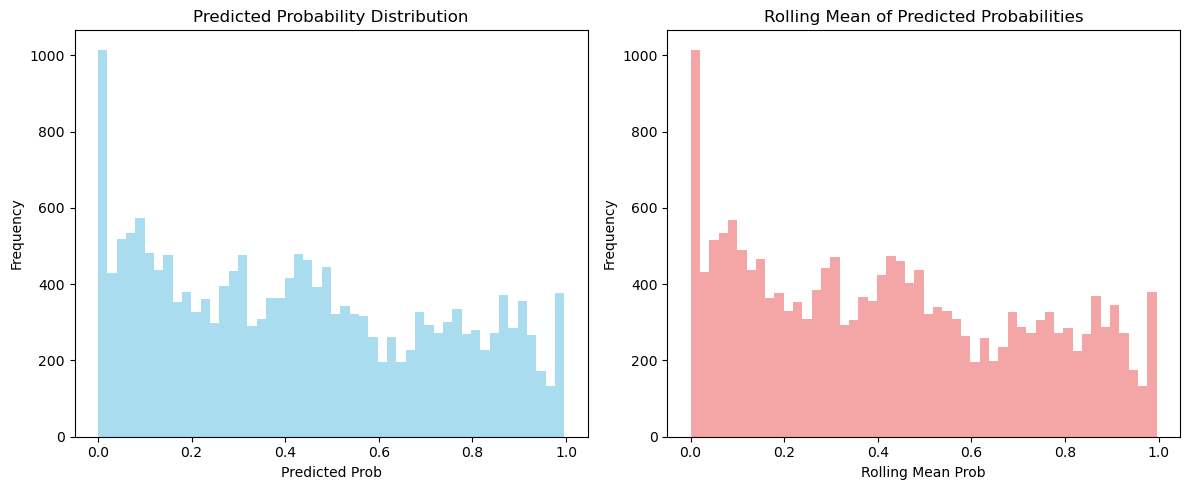

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 原始 predict_proba 分布
plt.subplot(1, 2, 1)
plt.hist(final_predictions_df['predicted_prob'][2000:], bins=50, alpha=0.7, color='skyblue')
plt.title('Predicted Probability Distribution')
plt.xlabel('Predicted Prob')
plt.ylabel('Frequency')

# 滚动均值分布
plt.subplot(1, 2, 2)
plt.hist(final_predictions_df['predicted_prob_rolling_mean'][2000:], bins=50, alpha=0.7, color='lightcoral')
plt.title('Rolling Mean of Predicted Probabilities')
plt.xlabel('Rolling Mean Prob')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



Backtesting Results Summary (Long-Short Strategy):
Initial Capital: 100000.00
Final Capital: 77592.38
Total Return: -22.41%
Total Realized PnL: -26382.64
年化收益 (近似): -74.69%
Maximum Drawdown: -34.37%
Sharpe Ratio (Risk-Free Rate = 0): -264.71
Number of Trades: 112
Win Rate: 42.86%


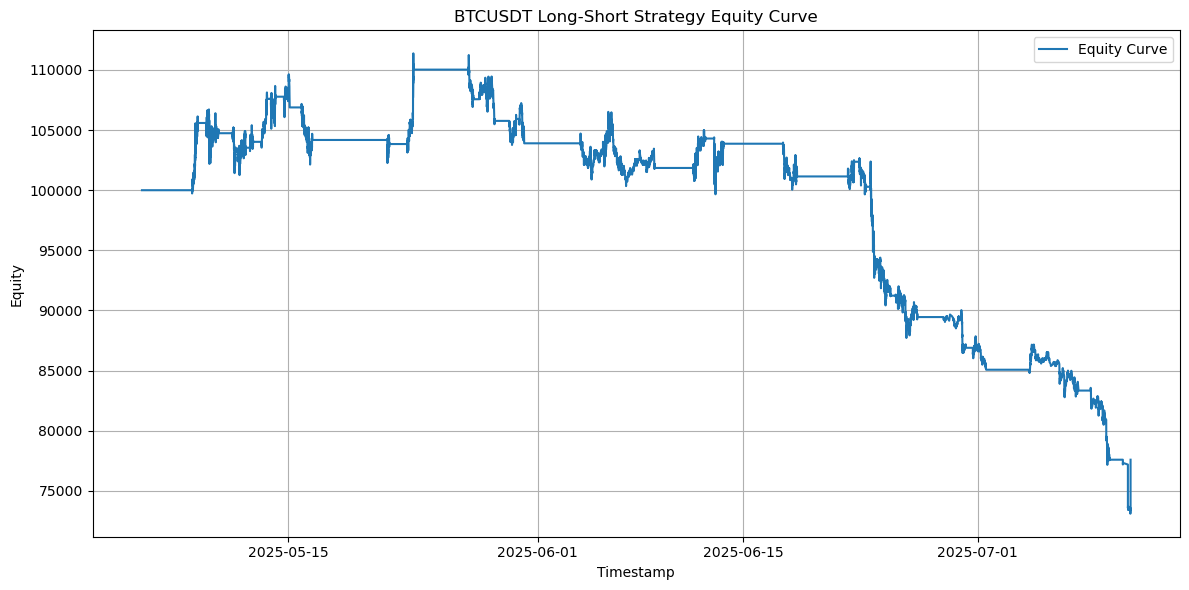

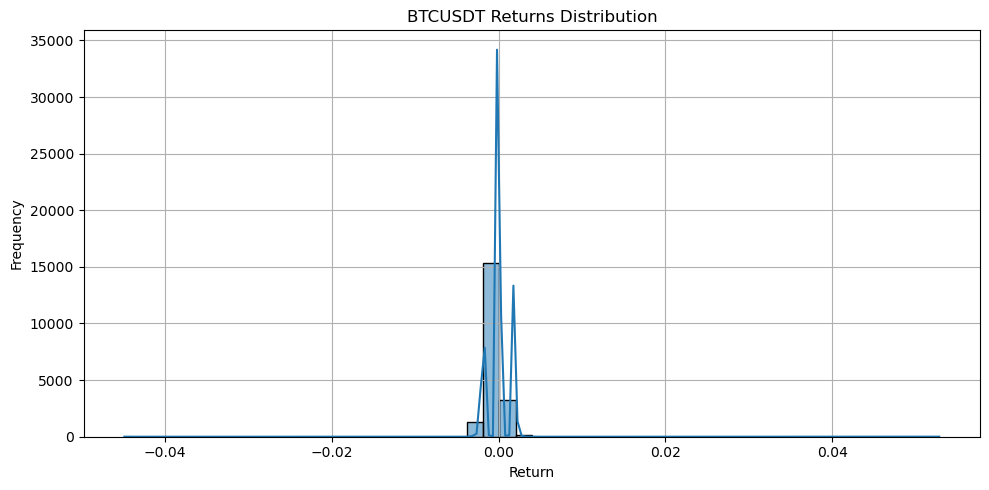

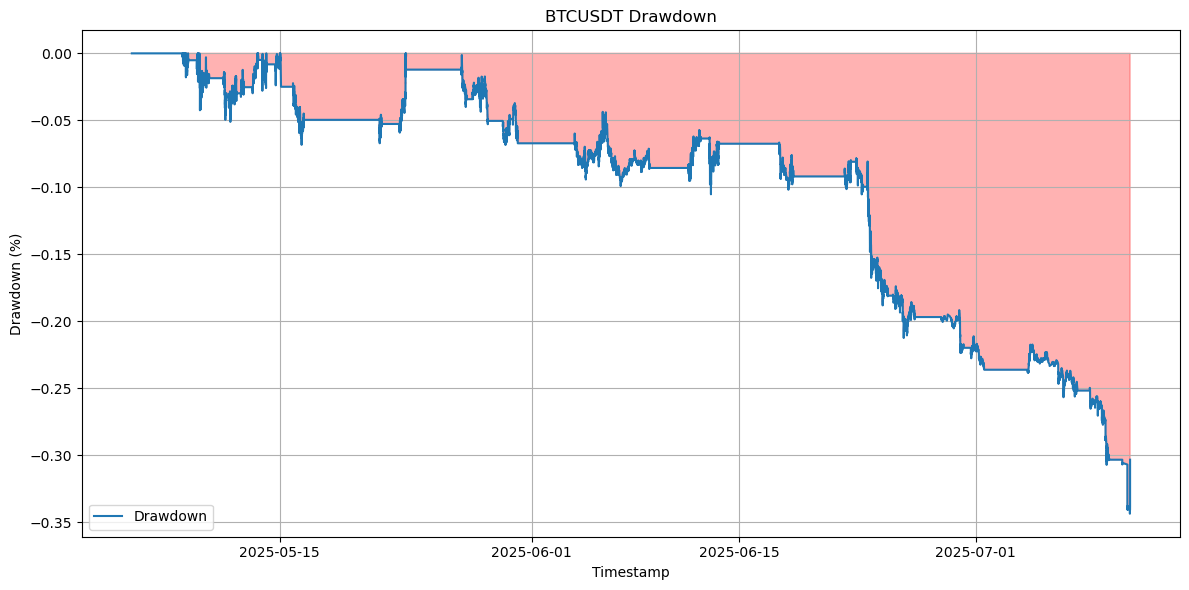

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

all_predictions_df = final_predictions_df
all_predictions_df['timestamp'] = pd.to_datetime(all_predictions_df['timestamp'], unit='ms') # Assuming microseconds

symbol_to_backtest = all_predictions_df['symbol'].iloc[0] # Take the first symbol for now
df = all_predictions_df[all_predictions_df['symbol'] == symbol_to_backtest].copy()
df = df.sort_values('timestamp').reset_index(drop=True)

# ===============================================
# Backtesting Parameters (Ratios for costs)
# ===============================================
initial_capital = 100000  # Initial capital
commission_ratio = 0.0005 # Commission ratio (e.0.05%)
slippage_ratio = 0.001   # Slippage ratio (e.g., 0.02%)

trade_size_ratio = 0.9    # Percentage of current equity to allocate per trade

# Strategy Thresholds (needs optimization)
long_threshold = 0.9 # Predicted probability above this to go long (buy)
short_threshold = 0.1 # Predicted probability below this to go short (sell)

beta = 4
# Dynamic Take Profit / Stop Loss (in multiples of rolling_std/px)
long_stop_loss_multiplier = beta
long_take_profit_multiplier = beta
short_stop_loss_multiplier = beta
short_take_profit_multiplier = beta

# ===============================================
# Backtesting Main Logic (No change here from previous version)
# ===============================================

# Initialize account state
capital = initial_capital
position = 0          # Position size (positive for long, negative for short, 0 for flat)
entry_price = 0       # Entry price for current position
realized_pnl = 0      # Realized PnL from closed trades
equity_curve = [initial_capital] # Equity curve
unrealized_pnl_series = [0]

# Record trades
trades = []

a = 0
for i in range(len(df)):
    current_time = df['timestamp'].iloc[i]
    current_px = df['px'].iloc[i]
    predicted_prob = df['predicted_prob_rolling_mean'].iloc[i]
    current_rolling_std = df['rolling_std'].iloc[i]

    # Calculate current total equity (capital + market value of position)
    if position > 0: # Long position
        unrealized_pnl = (current_px - entry_price) * position
    elif position < 0: # Short position
        unrealized_pnl = (entry_price - current_px) * abs(position) # Profit when price falls
    else: # Flat
        unrealized_pnl = 0

    current_equity = capital + unrealized_pnl
    equity_curve.append(current_equity)
    unrealized_pnl_series.append(unrealized_pnl)

    # -----------------------------------------------
    # Strategy Execution - Long-Short
    # -----------------------------------------------

    # Scenario 1: Currently FLAT (position == 0)
    if position == 0:
        if predicted_prob >= long_threshold: # Go Long Signal
            trade_type = 'BUY_OPEN'
            trade_price = current_px * (1 + slippage_ratio)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = num_shares
                entry_price = trade_price
                # capital -= (position * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

        elif predicted_prob <= short_threshold: # Go Short Signal
            trade_type = 'SELL_SHORT_OPEN'
            trade_price = current_px * (1 - slippage_ratio) # Price for short is lower (sell at market)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = -num_shares # Negative for short position
                entry_price = trade_price
                # capital -= (abs(position) * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

    # Scenario 2: Currently LONG (position > 0)
    elif position > 0:
        a += 1
        sl_price = entry_price - long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price + long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob <= short_threshold: # Changed from sell_threshold to short_threshold for consistent logic
            should_close = True
            reason = "Prediction below short threshold (close long)"
        # if current_px <= sl_price:
        #     should_close = True
        #     reason = "Long Stop Loss Hit"
        # elif current_px >= tp_price:
        #     should_close = True
        #     reason = "Long Take Profit Hit"
        elif a > step:
            should_close = True

        
        if should_close:
            a = 0
            trade_type = 'SELL_CLOSE_LONG'
            close_price = current_px * (1 - slippage_ratio)
            gross_pnl_on_trade = (close_price - entry_price) * position
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * position * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {position:.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0


    # Scenario 3: Currently SHORT (position < 0)
    elif position < 0:
        a += 1
        
        sl_price = entry_price + long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price - long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob >= long_threshold: # Changed from buy_threshold to long_threshold
            should_close = True
            reason = "Prediction above long threshold (close short)"
            
        # if current_px >= sl_price:
        #     should_close = True
        #     reason = "Short Stop Loss Hit"
        # elif current_px <= tp_price:
        #     should_close = True
        #     reason = "Short Take Profit Hit"
        elif a > step:
            should_close = True
            
        if should_close:
            a = 0
            trade_type = 'BUY_TO_COVER_SHORT'
            close_price = current_px * (1 + slippage_ratio)
            gross_pnl_on_trade = (entry_price - close_price) * abs(position)
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * abs(position) * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {abs(position):.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0

# Final close-out at the end of backtest if any position is open
final_equity_append_time = df['timestamp'].iloc[-1] + pd.Timedelta(seconds=1)
if position != 0:
    last_px = df['px'].iloc[-1]
    if position > 0: # Close long
        final_close_price = last_px * (1 - slippage_ratio)
        gross_pnl_on_trade = (final_close_price - entry_price) * position
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * position * commission_ratio)
        # capital += (position * final_close_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'SELL_FINAL_LONG', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: SELL_FINAL_LONG {position:.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    else: # Close short
        final_close_price = last_px * (1 + slippage_ratio)
        gross_pnl_on_trade = (entry_price - final_close_price) * abs(position)
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * abs(position) * commission_ratio)
        # capital += (abs(position) * entry_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'BUY_FINAL_SHORT', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: BUY_FINAL_SHORT {abs(position):.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    realized_pnl += net_pnl_on_trade
    position = 0

# Final equity curve update
equity_curve[-1] = capital
unrealized_pnl_series[-1] = 0
# ===============================================
# Performance Metrics Calculation (KEY CHANGES HERE)
# ===============================================
equity_series = pd.Series(equity_curve, index=df['timestamp'].tolist() + [final_equity_append_time])
returns = equity_series.pct_change().dropna()
unrealized_pnl_series = pd.Series(unrealized_pnl_series, index=equity_series.index)

# Total Return
total_return = (capital - initial_capital) / initial_capital

# Annualized Return - Based on Total Duration
annualized_return = total_return # Default value if not enough data

if len(df) > 1:
    # Get the total duration of the backtest data
    total_duration = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
    total_duration_seconds = total_duration.total_seconds()

    if total_duration_seconds > 0:
        # Number of seconds in a year
        seconds_in_year = 365 * 24 * 60 * 60

        # Annualization factor: (seconds in a year) / (total seconds in backtest)
        annualization_factor = seconds_in_year / total_duration_seconds

        # Apply annualization
        annualized_return = (1 + total_return)**annualization_factor - 1
    else:
        print("Warning: Total backtest duration is zero or invalid, cannot annualize return.")
else:
    print("Warning: Not enough data points to calculate total duration for annualization.")


# Max Drawdown
peak = equity_series.expanding(min_periods=1).max()
drawdown = (equity_series - peak) / peak
max_drawdown = drawdown.min()

# Sharpe Ratio (assuming risk-free rate is 0)
# For volatility, we use returns.std() and annualize it with the same factor
annualized_volatility = returns.std() * np.sqrt(annualization_factor) if 'annualization_factor' in locals() and annualization_factor > 0 else returns.std()
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

# Win Rate for closed trades
if len(trades) > 0:
    winning_trades = sum(1 for t in trades if 'pnl' in t and t['pnl'] > 0)
    total_closed_trades = sum(1 for t in trades if 'pnl' in t)
    win_rate = winning_trades / total_closed_trades if total_closed_trades > 0 else 0
else:
    win_rate = 0


print("\n" + "="*60)
print("Backtesting Results Summary (Long-Short Strategy):")
print(f"Initial Capital: {initial_capital:.2f}")
print(f"Final Capital: {capital:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Realized PnL: {realized_pnl:.2f}")
print(f"年化收益 (近似): {annualized_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Risk-Free Rate = 0): {sharpe_ratio:.2f}")
print(f"Number of Trades: {len(trades)}")
print(f"Win Rate: {win_rate:.2%}")
print("="*60)

# ===============================================
# Plotting
# ===============================================

# Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(equity_series.index, equity_series, label='Equity Curve')
plt.title(f'{symbol_to_backtest} Long-Short Strategy Equity Curve')
plt.xlabel('Timestamp')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Returns Distribution
if not returns.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(returns, kde=True, bins=50)
    plt.title(f'{symbol_to_backtest} Returns Distribution')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Drawdown Plot
if not drawdown.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown.index, drawdown, label='Drawdown')
    plt.fill_between(drawdown.index, drawdown, 0, where=(drawdown < 0), color='red', alpha=0.3)
    plt.title(f'{symbol_to_backtest} Drawdown')
    plt.xlabel('Timestamp')
    plt.ylabel('Drawdown (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(unrealized_pnl_series.index, unrealized_pnl_series, label="Unrealized PnL")
# plt.axhline(0, color='gray', linestyle='--')
# plt.title(f"{symbol_to_backtest} 浮动盈亏 (Unrealized PnL)")
# plt.xlabel("Timestamp")
# plt.ylabel("Unrealized PnL")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()



Backtesting Results Summary (Long-Short Strategy):
Initial Capital: 100000.00
Final Capital: 89635.25
Total Return: -10.36%
Total Realized PnL: -10364.75
年化收益 (近似): -44.71%
Maximum Drawdown: -21.21%
Sharpe Ratio (Risk-Free Rate = 0): -207.91
Number of Trades: 34
Win Rate: 47.06%


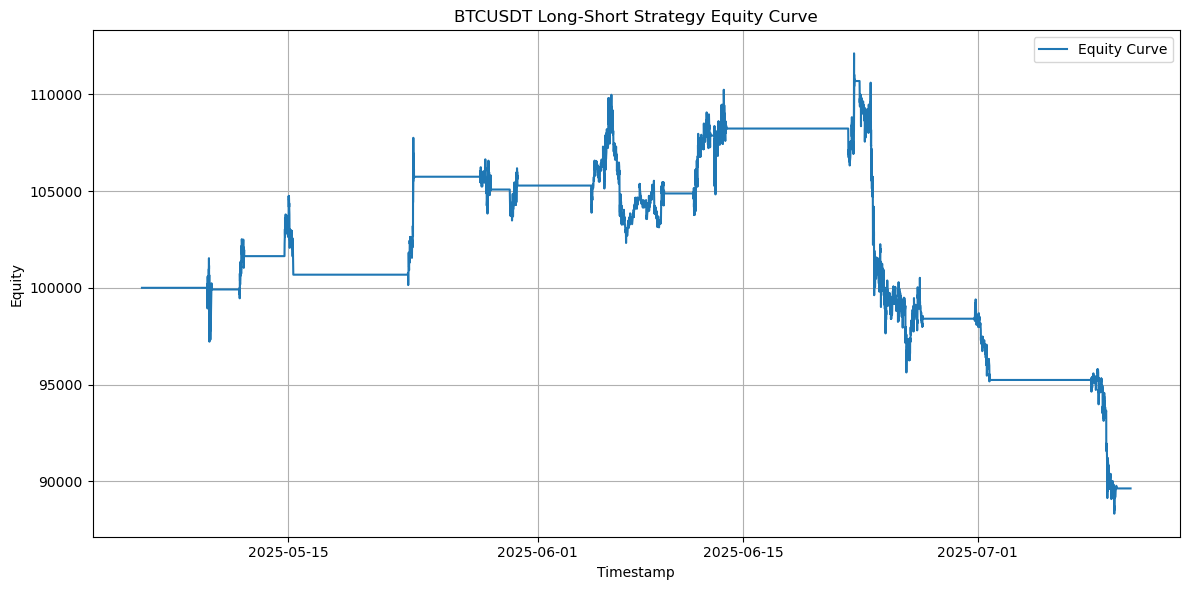

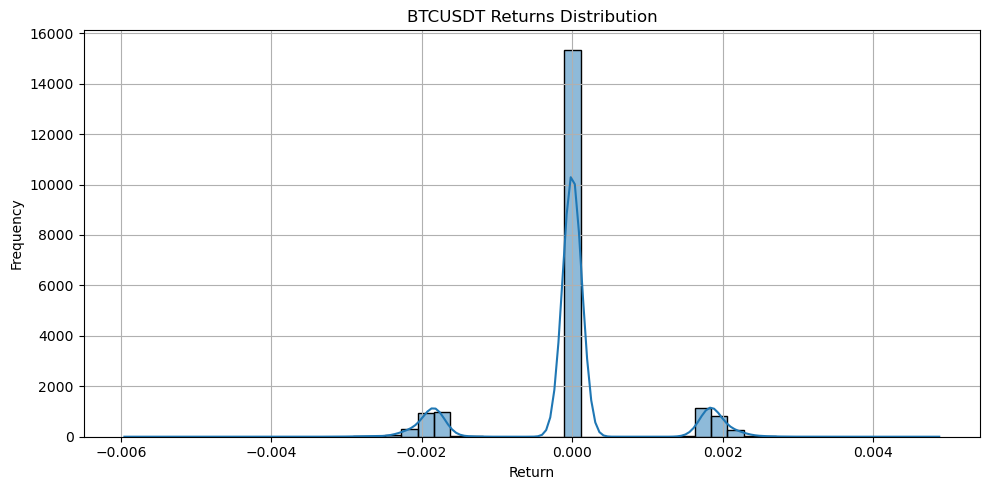

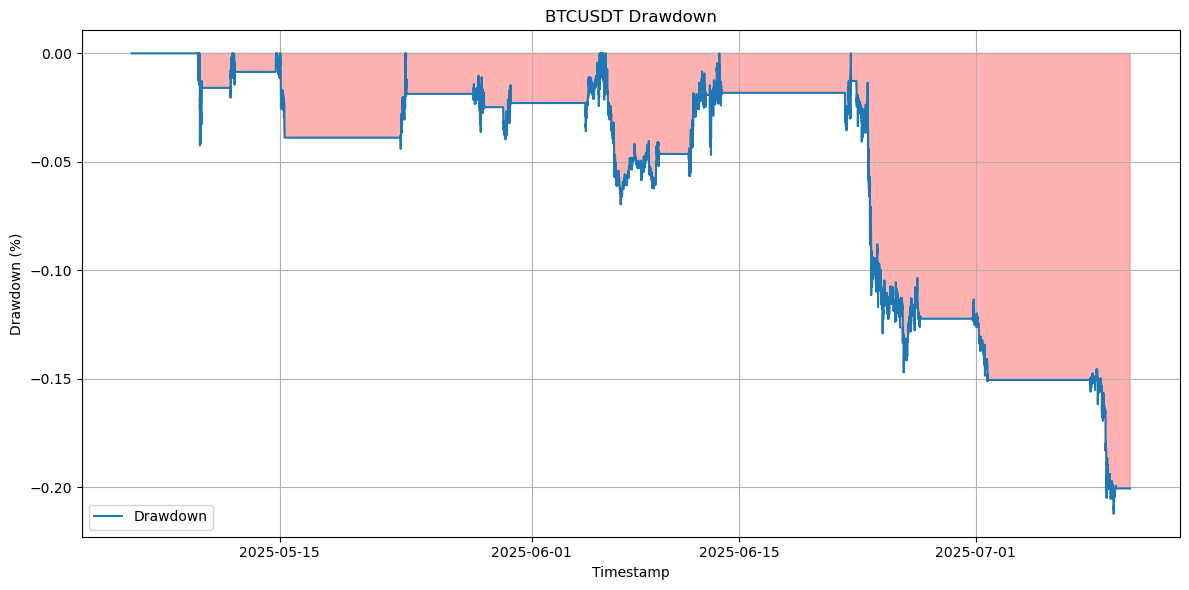

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

all_predictions_df = final_predictions_df
all_predictions_df['timestamp'] = pd.to_datetime(all_predictions_df['timestamp'], unit='ms') # Assuming microseconds

symbol_to_backtest = all_predictions_df['symbol'].iloc[0] # Take the first symbol for now
df = all_predictions_df[all_predictions_df['symbol'] == symbol_to_backtest].copy()
df = df.sort_values('timestamp').reset_index(drop=True)

# ===============================================
# Backtesting Parameters (Ratios for costs)
# ===============================================
initial_capital = 100000  # Initial capital
commission_ratio = 0.0005 # Commission ratio (e.0.05%)
slippage_ratio = 0.001   # Slippage ratio (e.g., 0.02%)

trade_size_ratio = 0.9    # Percentage of current equity to allocate per trade

# Strategy Thresholds (needs optimization)
long_threshold = 0.95 # Predicted probability above this to go long (buy)
short_threshold = 0.05 # Predicted probability below this to go short (sell)

beta = 4
# Dynamic Take Profit / Stop Loss (in multiples of rolling_std/px)
long_stop_loss_multiplier = beta
long_take_profit_multiplier = beta
short_stop_loss_multiplier = beta
short_take_profit_multiplier = beta

# ===============================================
# Backtesting Main Logic (No change here from previous version)
# ===============================================

# Initialize account state
capital = initial_capital
position = 0          # Position size (positive for long, negative for short, 0 for flat)
entry_price = 0       # Entry price for current position
realized_pnl = 0      # Realized PnL from closed trades
equity_curve = [initial_capital] # Equity curve
unrealized_pnl_series = [0]

# Record trades
trades = []
a = 0
step = 125
for i in range(len(df)):
    current_time = df['timestamp'].iloc[i]
    current_px = df['px'].iloc[i]
    predicted_prob = df['predicted_prob_rolling_mean'].iloc[i]
    current_rolling_std = df['rolling_std'].iloc[i]

    # Calculate current total equity (capital + market value of position)
    if position > 0: # Long position
        unrealized_pnl = (current_px - entry_price) * position
    elif position < 0: # Short position
        unrealized_pnl = (entry_price - current_px) * abs(position) # Profit when price falls
    else: # Flat
        unrealized_pnl = 0

    current_equity = capital + unrealized_pnl
    equity_curve.append(current_equity)
    unrealized_pnl_series.append(unrealized_pnl)

    # -----------------------------------------------
    # Strategy Execution - Long-Short
    # -----------------------------------------------

    # Scenario 1: Currently FLAT (position == 0)
    if position == 0:
        if predicted_prob >= long_threshold: # Go Long Signal
            trade_type = 'BUY_OPEN'
            trade_price = current_px * (1 + slippage_ratio)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = num_shares
                entry_price = trade_price
                # capital -= (position * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

        elif predicted_prob <= short_threshold: # Go Short Signal
            trade_type = 'SELL_SHORT_OPEN'
            trade_price = current_px * (1 - slippage_ratio) # Price for short is lower (sell at market)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = -num_shares # Negative for short position
                entry_price = trade_price
                # capital -= (abs(position) * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

    # Scenario 2: Currently LONG (position > 0)
    elif position > 0:
        a += 1
        sl_price = entry_price - long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price + long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob >= long_threshold: # Changed from sell_threshold to short_threshold for consistent logic
            a = 0
        
        if predicted_prob <= short_threshold: # Changed from sell_threshold to short_threshold for consistent logic
            should_close = True
            reason = "Prediction below short threshold (close long)"
        # if current_px <= sl_price:
        #     should_close = True
        #     reason = "Long Stop Loss Hit"
        # elif current_px >= tp_price:
        #     should_close = True
        #     reason = "Long Take Profit Hit"
        if a > step:
            should_close = True

        
        if should_close:
            a = 0
            trade_type = 'SELL_CLOSE_LONG'
            close_price = current_px * (1 - slippage_ratio)
            gross_pnl_on_trade = (close_price - entry_price) * position
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * position * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {position:.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0


    # Scenario 3: Currently SHORT (position < 0)
    elif position < 0:
        a += 1
        
        sl_price = entry_price + long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price - long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob <= short_threshold: # Changed from sell_threshold to short_threshold for consistent logic
            a = 0
            
        if predicted_prob >= long_threshold: # Changed from buy_threshold to long_threshold
            should_close = True
            reason = "Prediction above long threshold (close short)"
            
        # if current_px >= sl_price:
        #     should_close = True
        #     reason = "Short Stop Loss Hit"
        # elif current_px <= tp_price:
        #     should_close = True
        #     reason = "Short Take Profit Hit"
        if a > step:
            should_close = True
            
        if should_close:
            a = 0
            trade_type = 'BUY_TO_COVER_SHORT'
            close_price = current_px * (1 + slippage_ratio)
            gross_pnl_on_trade = (entry_price - close_price) * abs(position)
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * abs(position) * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {abs(position):.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0

# Final close-out at the end of backtest if any position is open
final_equity_append_time = df['timestamp'].iloc[-1] + pd.Timedelta(seconds=1)
if position != 0:
    last_px = df['px'].iloc[-1]
    if position > 0: # Close long
        final_close_price = last_px * (1 - slippage_ratio)
        gross_pnl_on_trade = (final_close_price - entry_price) * position
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * position * commission_ratio)
        # capital += (position * final_close_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'SELL_FINAL_LONG', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: SELL_FINAL_LONG {position:.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    else: # Close short
        final_close_price = last_px * (1 + slippage_ratio)
        gross_pnl_on_trade = (entry_price - final_close_price) * abs(position)
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * abs(position) * commission_ratio)
        # capital += (abs(position) * entry_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'BUY_FINAL_SHORT', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: BUY_FINAL_SHORT {abs(position):.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    realized_pnl += net_pnl_on_trade
    position = 0

# Final equity curve update
equity_curve[-1] = capital
unrealized_pnl_series[-1] = 0
# ===============================================
# Performance Metrics Calculation (KEY CHANGES HERE)
# ===============================================
equity_series = pd.Series(equity_curve, index=df['timestamp'].tolist() + [final_equity_append_time])
returns = equity_series.pct_change().dropna()
unrealized_pnl_series = pd.Series(unrealized_pnl_series, index=equity_series.index)

# Total Return
total_return = (capital - initial_capital) / initial_capital

# Annualized Return - Based on Total Duration
annualized_return = total_return # Default value if not enough data

if len(df) > 1:
    # Get the total duration of the backtest data
    total_duration = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
    total_duration_seconds = total_duration.total_seconds()

    if total_duration_seconds > 0:
        # Number of seconds in a year
        seconds_in_year = 365 * 24 * 60 * 60

        # Annualization factor: (seconds in a year) / (total seconds in backtest)
        annualization_factor = seconds_in_year / total_duration_seconds

        # Apply annualization
        annualized_return = (1 + total_return)**annualization_factor - 1
    else:
        print("Warning: Total backtest duration is zero or invalid, cannot annualize return.")
else:
    print("Warning: Not enough data points to calculate total duration for annualization.")


# Max Drawdown
peak = equity_series.expanding(min_periods=1).max()
drawdown = (equity_series - peak) / peak
max_drawdown = drawdown.min()

# Sharpe Ratio (assuming risk-free rate is 0)
# For volatility, we use returns.std() and annualize it with the same factor
annualized_volatility = returns.std() * np.sqrt(annualization_factor) if 'annualization_factor' in locals() and annualization_factor > 0 else returns.std()
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

# Win Rate for closed trades
if len(trades) > 0:
    winning_trades = sum(1 for t in trades if 'pnl' in t and t['pnl'] > 0)
    total_closed_trades = sum(1 for t in trades if 'pnl' in t)
    win_rate = winning_trades / total_closed_trades if total_closed_trades > 0 else 0
else:
    win_rate = 0


print("\n" + "="*60)
print("Backtesting Results Summary (Long-Short Strategy):")
print(f"Initial Capital: {initial_capital:.2f}")
print(f"Final Capital: {capital:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Realized PnL: {realized_pnl:.2f}")
print(f"年化收益 (近似): {annualized_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Risk-Free Rate = 0): {sharpe_ratio:.2f}")
print(f"Number of Trades: {len(trades)}")
print(f"Win Rate: {win_rate:.2%}")
print("="*60)

# ===============================================
# Plotting
# ===============================================

# Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(equity_series.index, equity_series, label='Equity Curve')
plt.title(f'{symbol_to_backtest} Long-Short Strategy Equity Curve')
plt.xlabel('Timestamp')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Returns Distribution
if not returns.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(returns, kde=True, bins=50)
    plt.title(f'{symbol_to_backtest} Returns Distribution')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Drawdown Plot
if not drawdown.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown.index, drawdown, label='Drawdown')
    plt.fill_between(drawdown.index, drawdown, 0, where=(drawdown < 0), color='red', alpha=0.3)
    plt.title(f'{symbol_to_backtest} Drawdown')
    plt.xlabel('Timestamp')
    plt.ylabel('Drawdown (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(unrealized_pnl_series.index, unrealized_pnl_series, label="Unrealized PnL")
# plt.axhline(0, color='gray', linestyle='--')
# plt.title(f"{symbol_to_backtest} 浮动盈亏 (Unrealized PnL)")
# plt.xlabel("Timestamp")
# plt.ylabel("Unrealized PnL")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()



Backtesting Results Summary (Long-Short Strategy):
Initial Capital: 100000.00
Final Capital: 89266.71
Total Return: -10.73%
Total Realized PnL: -10733.29
年化收益 (近似): -45.93%
Maximum Drawdown: -15.07%
Sharpe Ratio (Risk-Free Rate = 0): -258.98
Number of Trades: 24
Win Rate: 50.00%


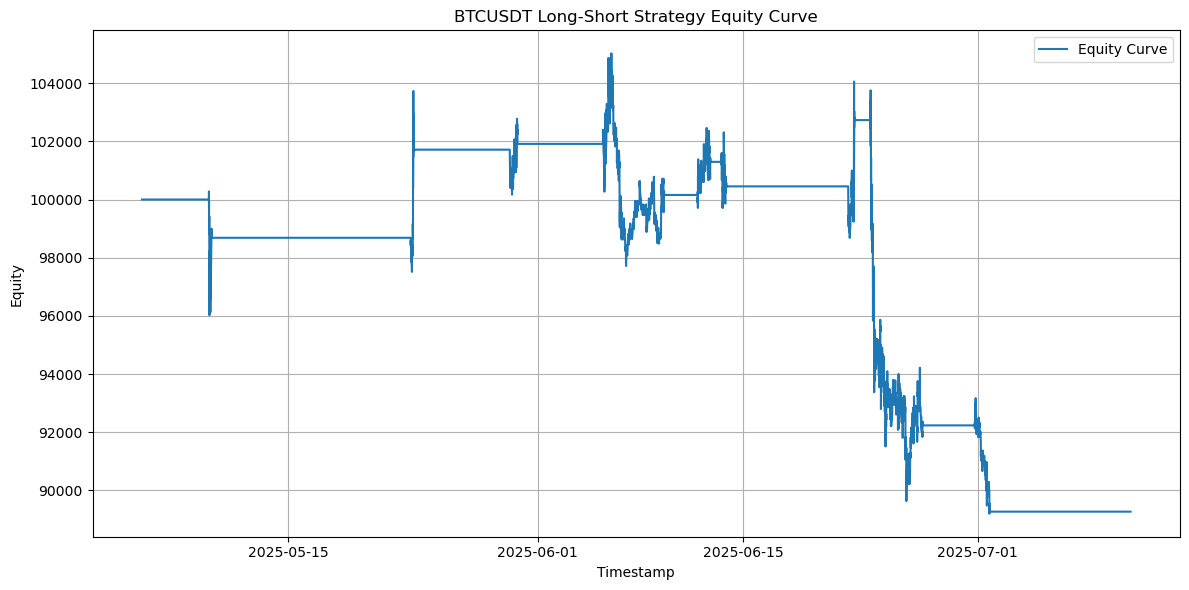

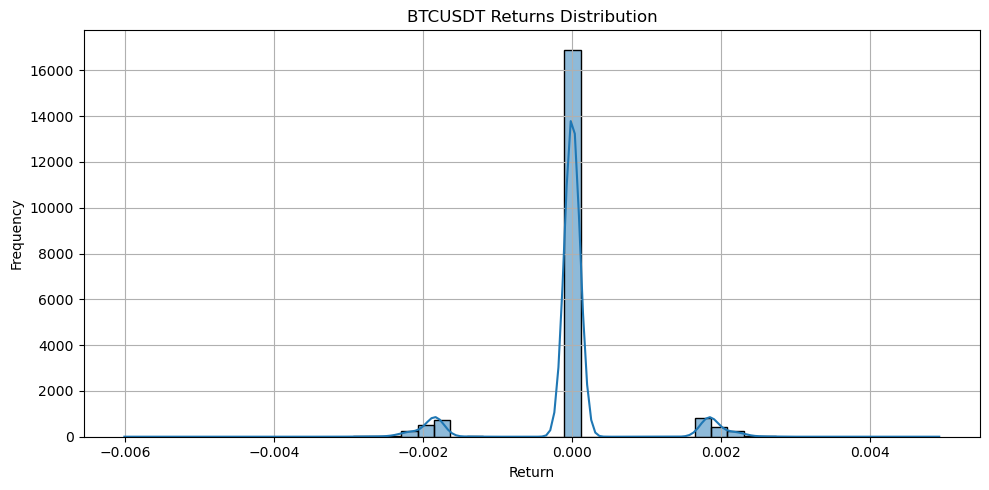

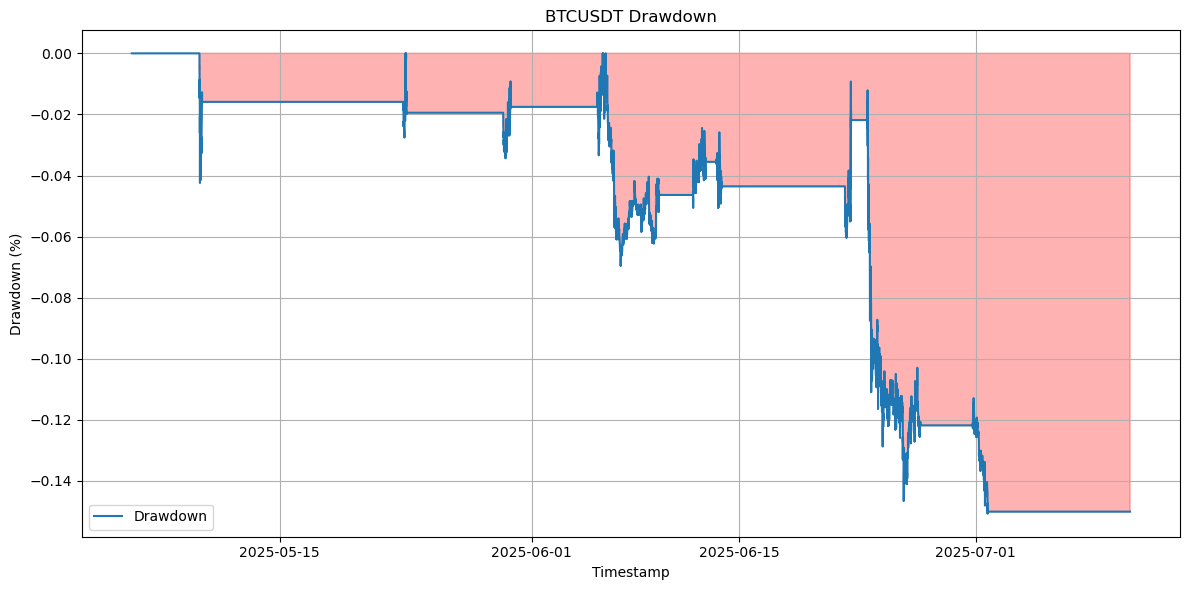

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

all_predictions_df = final_predictions_df
all_predictions_df['timestamp'] = pd.to_datetime(all_predictions_df['timestamp'], unit='ms') # Assuming microseconds
all_predictions_df['ma'] = all_predictions_df['px'].rolling(window=500).mean()

symbol_to_backtest = all_predictions_df['symbol'].iloc[0] # Take the first symbol for now
df = all_predictions_df[all_predictions_df['symbol'] == symbol_to_backtest].copy()
df = df.sort_values('timestamp').reset_index(drop=True)

# ===============================================
# Backtesting Parameters (Ratios for costs)
# ===============================================
initial_capital = 100000  # Initial capital
commission_ratio = 0.0005 # Commission ratio (e.0.05%)
slippage_ratio = 0.001   # Slippage ratio (e.g., 0.02%)

trade_size_ratio = 0.9    # Percentage of current equity to allocate per trade

# Strategy Thresholds (needs optimization)
long_threshold = 0.95 # Predicted probability above this to go long (buy)
short_threshold = 0.05 # Predicted probability below this to go short (sell)

beta = 4
# Dynamic Take Profit / Stop Loss (in multiples of rolling_std/px)
long_stop_loss_multiplier = beta
long_take_profit_multiplier = beta
short_stop_loss_multiplier = beta
short_take_profit_multiplier = beta

# ===============================================
# Backtesting Main Logic (No change here from previous version)
# ===============================================

# Initialize account state
capital = initial_capital
position = 0          # Position size (positive for long, negative for short, 0 for flat)
entry_price = 0       # Entry price for current position
realized_pnl = 0      # Realized PnL from closed trades
equity_curve = [initial_capital] # Equity curve
unrealized_pnl_series = [0]

# Record trades
trades = []
a = 0
step = 125
for i in range(len(df)):
    current_time = df['timestamp'].iloc[i]
    current_px = df['px'].iloc[i]
    predicted_prob = df['predicted_prob_rolling_mean'].iloc[i]
    current_rolling_std = df['rolling_std'].iloc[i]
    ma = df['ma'].iloc[i]

    # Calculate current total equity (capital + market value of position)
    if position > 0: # Long position
        unrealized_pnl = (current_px - entry_price) * position
    elif position < 0: # Short position
        unrealized_pnl = (entry_price - current_px) * abs(position) # Profit when price falls
    else: # Flat
        unrealized_pnl = 0

    current_equity = capital + unrealized_pnl
    equity_curve.append(current_equity)
    unrealized_pnl_series.append(unrealized_pnl)

    # -----------------------------------------------
    # Strategy Execution - Long-Short
    # -----------------------------------------------

    # Scenario 1: Currently FLAT (position == 0)
    if position == 0:
        if predicted_prob >= long_threshold and current_px > ma: # Go Long Signal
            trade_type = 'BUY_OPEN'
            trade_price = current_px * (1 + slippage_ratio)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = num_shares
                entry_price = trade_price
                # capital -= (position * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

        elif predicted_prob <= short_threshold and current_px < ma: # Go Short Signal
            trade_type = 'SELL_SHORT_OPEN'
            trade_price = current_px * (1 - slippage_ratio) # Price for short is lower (sell at market)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = -num_shares # Negative for short position
                entry_price = trade_price
                # capital -= (abs(position) * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

    # Scenario 2: Currently LONG (position > 0)
    elif position > 0:
        a += 1
        sl_price = entry_price - long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price + long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob >= long_threshold: # Changed from sell_threshold to short_threshold for consistent logic
            a = 0
        
        if predicted_prob <= short_threshold: # Changed from sell_threshold to short_threshold for consistent logic
            should_close = True
            reason = "Prediction below short threshold (close long)"
        # if current_px <= sl_price:
        #     should_close = True
        #     reason = "Long Stop Loss Hit"
        # elif current_px >= tp_price:
        #     should_close = True
        #     reason = "Long Take Profit Hit"
        if a > step:
            should_close = True

        
        if should_close:
            a = 0
            trade_type = 'SELL_CLOSE_LONG'
            close_price = current_px * (1 - slippage_ratio)
            gross_pnl_on_trade = (close_price - entry_price) * position
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * position * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {position:.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0


    # Scenario 3: Currently SHORT (position < 0)
    elif position < 0:
        a += 1
        
        sl_price = entry_price + long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price - long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob <= short_threshold: # Changed from sell_threshold to short_threshold for consistent logic
            a = 0
            
        if predicted_prob >= long_threshold: # Changed from buy_threshold to long_threshold
            should_close = True
            reason = "Prediction above long threshold (close short)"
            
        # if current_px >= sl_price:
        #     should_close = True
        #     reason = "Short Stop Loss Hit"
        # elif current_px <= tp_price:
        #     should_close = True
        #     reason = "Short Take Profit Hit"
        if a > step:
            should_close = True
            
        if should_close:
            a = 0
            trade_type = 'BUY_TO_COVER_SHORT'
            close_price = current_px * (1 + slippage_ratio)
            gross_pnl_on_trade = (entry_price - close_price) * abs(position)
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * abs(position) * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {abs(position):.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0

# Final close-out at the end of backtest if any position is open
final_equity_append_time = df['timestamp'].iloc[-1] + pd.Timedelta(seconds=1)
if position != 0:
    last_px = df['px'].iloc[-1]
    if position > 0: # Close long
        final_close_price = last_px * (1 - slippage_ratio)
        gross_pnl_on_trade = (final_close_price - entry_price) * position
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * position * commission_ratio)
        # capital += (position * final_close_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'SELL_FINAL_LONG', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: SELL_FINAL_LONG {position:.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    else: # Close short
        final_close_price = last_px * (1 + slippage_ratio)
        gross_pnl_on_trade = (entry_price - final_close_price) * abs(position)
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * abs(position) * commission_ratio)
        # capital += (abs(position) * entry_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'BUY_FINAL_SHORT', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: BUY_FINAL_SHORT {abs(position):.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    realized_pnl += net_pnl_on_trade
    position = 0

# Final equity curve update
equity_curve[-1] = capital
unrealized_pnl_series[-1] = 0
# ===============================================
# Performance Metrics Calculation (KEY CHANGES HERE)
# ===============================================
equity_series = pd.Series(equity_curve, index=df['timestamp'].tolist() + [final_equity_append_time])
returns = equity_series.pct_change().dropna()
unrealized_pnl_series = pd.Series(unrealized_pnl_series, index=equity_series.index)

# Total Return
total_return = (capital - initial_capital) / initial_capital

# Annualized Return - Based on Total Duration
annualized_return = total_return # Default value if not enough data

if len(df) > 1:
    # Get the total duration of the backtest data
    total_duration = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
    total_duration_seconds = total_duration.total_seconds()

    if total_duration_seconds > 0:
        # Number of seconds in a year
        seconds_in_year = 365 * 24 * 60 * 60

        # Annualization factor: (seconds in a year) / (total seconds in backtest)
        annualization_factor = seconds_in_year / total_duration_seconds

        # Apply annualization
        annualized_return = (1 + total_return)**annualization_factor - 1
    else:
        print("Warning: Total backtest duration is zero or invalid, cannot annualize return.")
else:
    print("Warning: Not enough data points to calculate total duration for annualization.")


# Max Drawdown
peak = equity_series.expanding(min_periods=1).max()
drawdown = (equity_series - peak) / peak
max_drawdown = drawdown.min()

# Sharpe Ratio (assuming risk-free rate is 0)
# For volatility, we use returns.std() and annualize it with the same factor
annualized_volatility = returns.std() * np.sqrt(annualization_factor) if 'annualization_factor' in locals() and annualization_factor > 0 else returns.std()
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

# Win Rate for closed trades
if len(trades) > 0:
    winning_trades = sum(1 for t in trades if 'pnl' in t and t['pnl'] > 0)
    total_closed_trades = sum(1 for t in trades if 'pnl' in t)
    win_rate = winning_trades / total_closed_trades if total_closed_trades > 0 else 0
else:
    win_rate = 0


print("\n" + "="*60)
print("Backtesting Results Summary (Long-Short Strategy):")
print(f"Initial Capital: {initial_capital:.2f}")
print(f"Final Capital: {capital:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Realized PnL: {realized_pnl:.2f}")
print(f"年化收益 (近似): {annualized_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Risk-Free Rate = 0): {sharpe_ratio:.2f}")
print(f"Number of Trades: {len(trades)}")
print(f"Win Rate: {win_rate:.2%}")
print("="*60)

# ===============================================
# Plotting
# ===============================================

# Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(equity_series.index, equity_series, label='Equity Curve')
plt.title(f'{symbol_to_backtest} Long-Short Strategy Equity Curve')
plt.xlabel('Timestamp')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Returns Distribution
if not returns.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(returns, kde=True, bins=50)
    plt.title(f'{symbol_to_backtest} Returns Distribution')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Drawdown Plot
if not drawdown.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown.index, drawdown, label='Drawdown')
    plt.fill_between(drawdown.index, drawdown, 0, where=(drawdown < 0), color='red', alpha=0.3)
    plt.title(f'{symbol_to_backtest} Drawdown')
    plt.xlabel('Timestamp')
    plt.ylabel('Drawdown (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(unrealized_pnl_series.index, unrealized_pnl_series, label="Unrealized PnL")
# plt.axhline(0, color='gray', linestyle='--')
# plt.title(f"{symbol_to_backtest} 浮动盈亏 (Unrealized PnL)")
# plt.xlabel("Timestamp")
# plt.ylabel("Unrealized PnL")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


In [32]:
# save_tabnet_checkpoint(
#     model=tab_inc,
#     symbol=symbol,
#     base_save_dir="./saved_models/tabnet_inc_future_k",
#     model_params=params,
#     feature_names=X_test.columns,
#     training_meta={
#         "symbol": symbol,
#         "feat_cal_window": feat_cal_window,
#         "feat_trans_window": feat_trans_window,
#         "feat_trans_lag": feat_trans_lag,
#         "feat_norm_window": feat_norm_window,
#         "train_target": file,
#         "train_n_week": n_train_weeks,
#         "class_weight_strategy": "balanced",
#         "init_fit_params": init_fit_params,
#         "inc_fit_params": inc_fit_params,
#         # "label_alpha": alpha,
#         # "label_window": rolling_window,
#         "fit_start_date": overall_start,
#         "fit_end_date": overall_end,
#         "saved_timestamp": str(pd.Timestamp.now()),
#         "label_step": step,
#         "bt_up_thresh": long_threshold,
#         "bt_dn_thresh": short_threshold,
#         "bt_beta": beta,
#         "bt_ret": total_return,
#         "bt_dd": max_drawdown,
#         "bt_n_trade": len(trades),
#     },
# )

In [33]:
# save_tabnet_checkpoint(
#     model=tab_inc,
#     symbol=symbol,
#     base_save_dir="./saved_models/tabnet_inc",
#     model_params=params,
#     feature_names=X_test.columns,
#     training_meta={
#         "symbol": symbol,
#         "feat_cal_window": feat_cal_window,
#         "feat_trans_window": feat_trans_window,
#         "feat_trans_lag": feat_trans_lag,
#         "feat_norm_window": feat_norm_window,
#         "train_target": file,
#         "train_n_week": n_train_weeks,
#         "class_weight_strategy": "balanced",
#         "init_fit_params": init_fit_params,
#         "inc_fit_params": inc_fit_params,
#         "label_alpha": alpha,
#         "label_window": rolling_window,
#         "fit_start_date": overall_start,
#         "fit_end_date": overall_end,
#         "saved_timestamp": str(pd.Timestamp.now()),
#         "bt_up_thresh": long_threshold,
#         "bt_dn_thresh": short_threshold,
#         "bt_beta": beta,
#     },
# )

In [34]:
# all_df_processed = a_df_filtered.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
# X_all = all_df_processed[feature_cols]
# y_all = all_df_processed[target_col]
# px_all = all_df_processed['px']
# std_all = all_df_processed['rolling_std']
# timestamps_all = all_df_processed['timestamp'] # 收集时间戳

# a = tab_inc.predict_proba(X_train.values)[:, 1]
# print(a)
# all_tab_inc_test_verify = []
# current_window_results = pd.DataFrame({
#     'timestamp': timestamps_all,
#     'symbol': "tst", # 如果有多个股票，收集 symbol 是必要的
#     'true_label': y_all,
#     'predicted_prob': tab_inc.predict_proba(X_all.values)[:, 1],
#     'px': px_all, # 收集价格，回测时需要
#     'rolling_std': std_all # 收集波动率，可能用于策略或分析
#     # 添加任何你回测需要的其他数据
# })
# all_tab_inc_test_verify.append(current_window_results)


In [35]:
# rolling_window_size = 10

# final_predictions_df = pd.concat(all_tab_inc_test_verify).sort_values('timestamp').reset_index(drop=True)

# final_predictions_df['predicted_prob_rolling_mean'] = final_predictions_df['predicted_prob'].rolling(window=rolling_window_size, min_periods=1).mean()

# # tabnet_eval = evaluate_with_confidence(
# #     y_true=final_predictions_df['true_label'],
# #     y_pred_proba=final_predictions_df['predicted_prob_rolling_mean'],
# #     model_name="model",
# #     lower_thresh=0.05,
# #     upper_thresh=0.95,
# #     print_report=True,
# # )

# plot_last_n_rows_with_px(
#     final_predictions_df['predicted_prob_rolling_mean'], 
#     final_predictions_df['true_label'],      
#     final_predictions_df['predicted_prob_rolling_mean'], 
#     final_predictions_df['px'],
#     std_array=final_predictions_df['rolling_std'],
#     n=1,
#     m=-1,
#     alpha=alpha,
# )
# plot_last_n_rows_with_px(
#     final_predictions_df['predicted_prob'], 
#     final_predictions_df['true_label'], 
#     final_predictions_df['predicted_prob'], 
#     final_predictions_df['px'], 
#     std_array=final_predictions_df['rolling_std'], 
#     n=1,
#     m=-1, 
#     alpha=alpha
# )

# final_predictions_df